In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import datetime
import calendar
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import select_coint_rank
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX





from statsmodels.tsa.stattools import grangercausalitytests

from pylab import rcParams
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# 1. Data loading and data inspection

In [2]:
#Read train dataset
train = pd.read_csv('train.csv')
train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [3]:
train.Store.value_counts()

233     942
836     942
308     942
309     942
821     942
       ... 
778     758
677     758
952     758
1065    758
512     758
Name: Store, Length: 1115, dtype: int64

#### We hava sales and customers data for 1115 stores.

In [4]:
original_row_size_train=train.shape[0]
original_col_size_train=train.shape[1]
print('No of rows in train dataset is {}',original_row_size_train)
print('No of cols in train dataset is{}',original_col_size_train)

No of rows in train dataset is {} 1017209
No of cols in train dataset is{} 9


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


#### We can see there is no missing values in data set

In [6]:
train.describe()

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  
count  1.017209e+06   1.017209e+06  
mean   3.815145e-01   1.786467e-01  
std    4.857586e-01   3.830564e-01  
min    0.000000e+00   0.000000e+00  
25%    0.000000e+00   0.000000e+00  
50%    0.000000e+00   0.000000e+00  
75%    1.000000e+00   0.000000e+00  
max    1.000000e+00   1.000000e+00

#### The average value of sales is 5774 whereas average value for customers is 633.

In [7]:
#Read store dataset
store = pd.read_csv('store.csv')
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [8]:
store.Store.value_counts()

1       1
742     1
748     1
747     1
746     1
       ..
378     1
379     1
380     1
381     1
1115    1
Name: Store, Length: 1115, dtype: int64

#### We have details for 1115 stores

In [9]:
original_row_size_store=store.shape[0]
original_col_size_store=store.shape[1]
print('No of rows in store dataset is {}',original_row_size_store)
print('No of cols in store dataset is{}',original_col_size_store)

No of rows in store dataset is {} 1115
No of cols in store dataset is{} 10


In [10]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


#### We can see missing values in CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek,Promo2SinceYear,PromoInterval 

In [11]:
store.describe()

Store  CompetitionDistance  CompetitionOpenSinceMonth  \
count  1115.00000          1112.000000                 761.000000   
mean    558.00000          5404.901079                   7.224704   
std     322.01708          7663.174720                   3.212348   
min       1.00000            20.000000                   1.000000   
25%     279.50000           717.500000                   4.000000   
50%     558.00000          2325.000000                   8.000000   
75%     836.50000          6882.500000                  10.000000   
max    1115.00000         75860.000000                  12.000000   

       CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear  
count                761.000000  1115.000000       571.000000       571.000000  
mean                2008.668857     0.512108        23.595447      2011.763573  
std                    6.195983     0.500078        14.141984         1.674935  
min                 1900.000000     0.000000         1.000000      2009.000000  
25%                 2006.000000     0.000000        13.000000      2011.000000  
50%                 2010.000000     1.000000        22.000000      2012.000000  
75%                 2013.000000     1.000000        37.000000      2013.000000  
max                 2015.000000     1.000000        50.000000      2015.000000

# 2.Data Cleaning (Missing value treatment)

#### Common method for visualization and to get metadata 

In [12]:
def createCountPlot(features,df):
    cols=3
    rows = len(features)//cols +1
    fig = plt.figure(figsize=(16, rows*5))
    dataframe = df.copy()
    for plot, feature in enumerate(features):
        fig.add_subplot(rows,cols,plot+1)
        fig.tight_layout(h_pad=5, w_pad=5)
        dataframe[feature] = dataframe[feature].fillna('Missing')
        ax = sns.countplot(x=feature, data=dataframe,order = dataframe[feature].value_counts().index)
        plt.xticks(rotation = 90)
        plt.title("for {}".format(feature))
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}'.format(height/len(dataframe) * 100),
                    ha="center")

In [13]:
#Common method to plot box plot
def boxPlot(df,features):
    cols=3
    rows = len(features)//cols +1
    fig = plt.figure(figsize=(15, rows*5))
    for plot, feature in enumerate(features):
        fig.add_subplot(rows,cols,plot+1)
        fig.tight_layout(h_pad=5, w_pad=5)
        sns.boxplot(df[feature])
        plt.title("for {}".format(feature))

In [14]:
def get_meta_data(df) :
    metadata = pd.DataFrame({
                    'Datatype' : df.dtypes,  
                    'Null_Percentage': round(df.isnull().sum()/len(df) * 100,2),
                    'Null count':df.isnull().sum(),
                    'No_Of_Unique_Values':df.nunique()
        
                       })
    return metadata

### Univariant analysis and Missing value and outlier treatment for train dataset

In [15]:
train_metadata=get_meta_data(train)
train_metadata

Datatype  Null_Percentage  Null count  No_Of_Unique_Values
Store            int64              0.0           0                 1115
DayOfWeek        int64              0.0           0                    7
Date            object              0.0           0                  942
Sales            int64              0.0           0                21734
Customers        int64              0.0           0                 4086
Open             int64              0.0           0                    2
Promo            int64              0.0           0                    2
StateHoliday    object              0.0           0                    5
SchoolHoliday    int64              0.0           0                    2

#### We can see there is no missing values in dataset

In [16]:
train_categorical_fields=list(train_metadata[train_metadata.No_Of_Unique_Values<=30].index)
train_categorical_fields

['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']

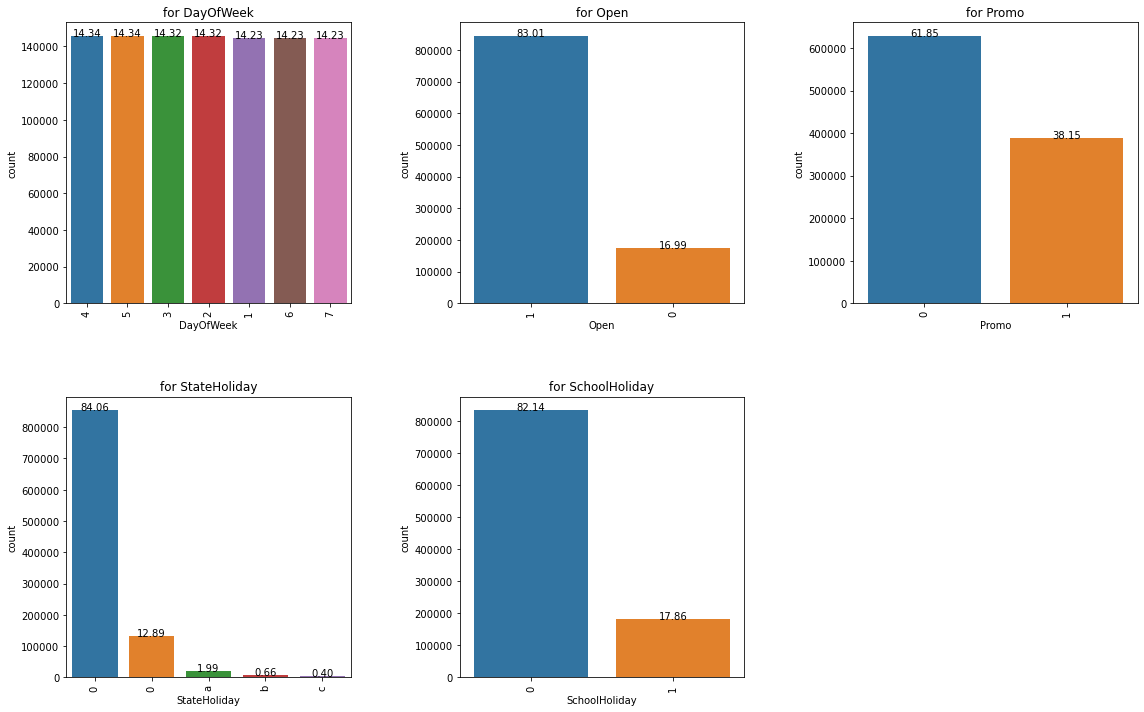

In [17]:
createCountPlot(train_categorical_fields,train)

#### DayOfWeek: The values ar like 1,2,3,4,5,6,7 for all 7 days of the week. The count is almost same for all day
#### Open : 83% records are saying store is open.Only 17% records are with closed state of store.
#### Promo: Only 38% records are with promo value 1.
#### StateHoliday: We can see there are 2 bars with category 0. We will investigate more for this.
#### SchoolHoliday : Most of the records are with value 0 which means no SchoolHoliday.

In [18]:
train.StateHoliday.value_counts()

0    855087
0    131072
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

In [19]:
train.StateHoliday.dtype

dtype('O')

In [20]:
train[train.StateHoliday=='0'].head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [21]:
train[train.StateHoliday==0].head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo  \
327680    730          4  2014-09-25   5732        722     1      0   
327681    731          4  2014-09-25   7470        802     1      0   
327682    732          4  2014-09-25   5484        730     1      0   
327683    733          4  2014-09-25  13801       3392     1      0   
327684    734          4  2014-09-25   3519        404     1      0   

       StateHoliday  SchoolHoliday  
327680            0              0  
327681            0              0  
327682            0              0  
327683            0              0  
327684            0              0

In [22]:
train.loc[train.StateHoliday==0,'StateHoliday']='0'

In [23]:
train.StateHoliday.value_counts()

0    986159
a     20260
b      6690
c      4100
Name: StateHoliday, dtype: int64

#### Most of the records are with 0 value . After that most of the records are for  public holiday.

In [24]:
#Change data type of Date to pandas date time
train['Date']=pd.to_datetime(train['Date'])

In [25]:
train.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [26]:
train.Date.min()

Timestamp('2013-01-01 00:00:00')

In [27]:
train.Date.max()

Timestamp('2015-07-31 00:00:00')

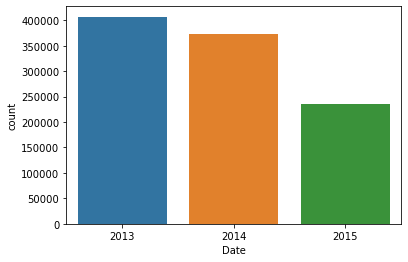

In [28]:
sns.countplot(train.Date.dt.year)
plt.show()

#### We are having more data for 2013 and 2014 than 2015

In [29]:
train_metadata=get_meta_data(train)
train_metadata

Datatype  Null_Percentage  Null count  \
Store                   int64              0.0           0   
DayOfWeek               int64              0.0           0   
Date           datetime64[ns]              0.0           0   
Sales                   int64              0.0           0   
Customers               int64              0.0           0   
Open                    int64              0.0           0   
Promo                   int64              0.0           0   
StateHoliday           object              0.0           0   
SchoolHoliday           int64              0.0           0   

               No_Of_Unique_Values  
Store                         1115  
DayOfWeek                        7  
Date                           942  
Sales                        21734  
Customers                     4086  
Open                             2  
Promo                            2  
StateHoliday                     4  
SchoolHoliday                    2

In [30]:
train_numerical_fields=list(train_metadata[(train_metadata.No_Of_Unique_Values>30) & (train_metadata.Datatype=='int64')].index)
train_numerical_fields

['Store', 'Sales', 'Customers']

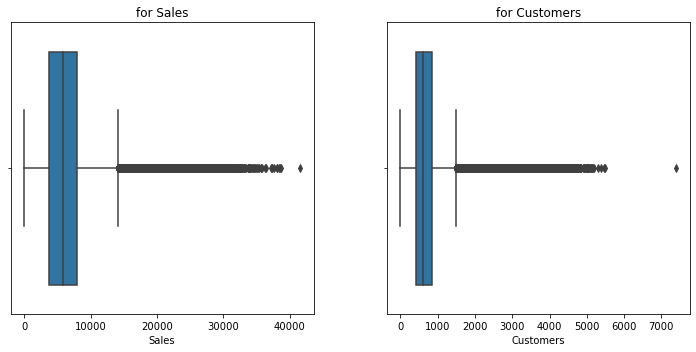

In [31]:
train_numerical_fields.remove('Store')
boxPlot(train,train_numerical_fields)

#### We can clearly see outliers in case of sales and customers. Let's check the quantile values

In [32]:
round(train[['Sales','Customers']].describe(),2)

Sales   Customers
count  1017209.00  1017209.00
mean      5773.82      633.15
std       3849.93      464.41
min          0.00        0.00
25%       3727.00      405.00
50%       5744.00      609.00
75%       7856.00      837.00
max      41551.00     7388.00

In [33]:
train[['Sales','Customers']].quantile([.9,.95,.99])

Sales  Customers
0.90  10288.0     1116.0
0.95  12137.0     1362.0
0.99  17160.0     2267.0

In [34]:
train[train.Sales>train.Sales.quantile(.99)].head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
124    125          5 2015-07-31  18227       2041     1      1            0   
210    211          5 2015-07-31  17286       1659     1      1            0   
250    251          5 2015-07-31  22205       2508     1      1            0   
261    262          5 2015-07-31  25774       3669     1      1            0   
319    320          5 2015-07-31  19898       2316     1      1            0   

     SchoolHoliday  
124              1  
210              1  
250              1  
261              1  
319              1

In [35]:
round(100*train[train.Sales>train.Sales.quantile(.99)].shape[0]/original_row_size_train,3)

1.0

In [36]:
round(100*train[train.Customers>train.Customers.quantile(.99)].shape[0]/original_row_size_train,3)

0.999

#### Only 1% Sales values are above 99% value and same for sales also. Let's delete these records as suggested in problem statement.

In [37]:
train = train.loc[train.Customers<=train.Customers.quantile(.99),:]
train.shape

(1007044, 9)

In [38]:
train = train.loc[train.Sales<=train.Sales.quantile(.99),:]
train.shape

(996974, 9)

In [39]:
train.shape[0]/original_row_size_train

0.9801073329079865

#### We are left with 98% data . Now check for outliers

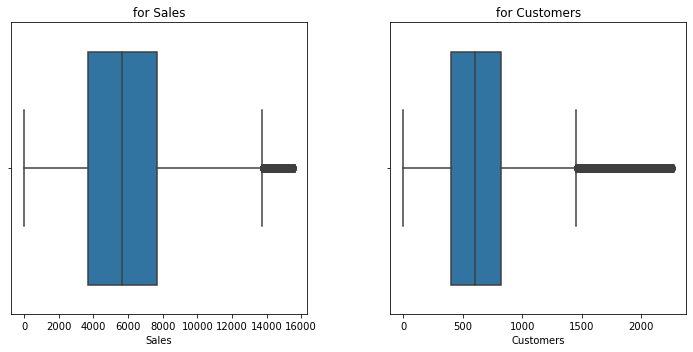

In [40]:
boxPlot(train,train_numerical_fields)

#### We can see, there is no outliers now

In [41]:
train_metadata=get_meta_data(train)
train_metadata

Datatype  Null_Percentage  Null count  \
Store                   int64              0.0           0   
DayOfWeek               int64              0.0           0   
Date           datetime64[ns]              0.0           0   
Sales                   int64              0.0           0   
Customers               int64              0.0           0   
Open                    int64              0.0           0   
Promo                   int64              0.0           0   
StateHoliday           object              0.0           0   
SchoolHoliday           int64              0.0           0   

               No_Of_Unique_Values  
Store                         1115  
DayOfWeek                        7  
Date                           942  
Sales                        14694  
Customers                     2206  
Open                             2  
Promo                            2  
StateHoliday                     4  
SchoolHoliday                    2

### Univariant analysis and Missing value and outlier treatment for store dataset

In [42]:
store_metadata=get_meta_data(store)
store_metadata

Datatype  Null_Percentage  Null count  \
Store                        int64             0.00           0   
StoreType                   object             0.00           0   
Assortment                  object             0.00           0   
CompetitionDistance        float64             0.27           3   
CompetitionOpenSinceMonth  float64            31.75         354   
CompetitionOpenSinceYear   float64            31.75         354   
Promo2                       int64             0.00           0   
Promo2SinceWeek            float64            48.79         544   
Promo2SinceYear            float64            48.79         544   
PromoInterval               object            48.79         544   

                           No_Of_Unique_Values  
Store                                     1115  
StoreType                                    4  
Assortment                                   3  
CompetitionDistance                        654  
CompetitionOpenSinceMonth                   12  
CompetitionOpenSinceYear                    23  
Promo2                                       2  
Promo2SinceWeek                             24  
Promo2SinceYear                              7  
PromoInterval                                3

In [43]:
store_categorical_fields=['StoreType','Assortment','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval']

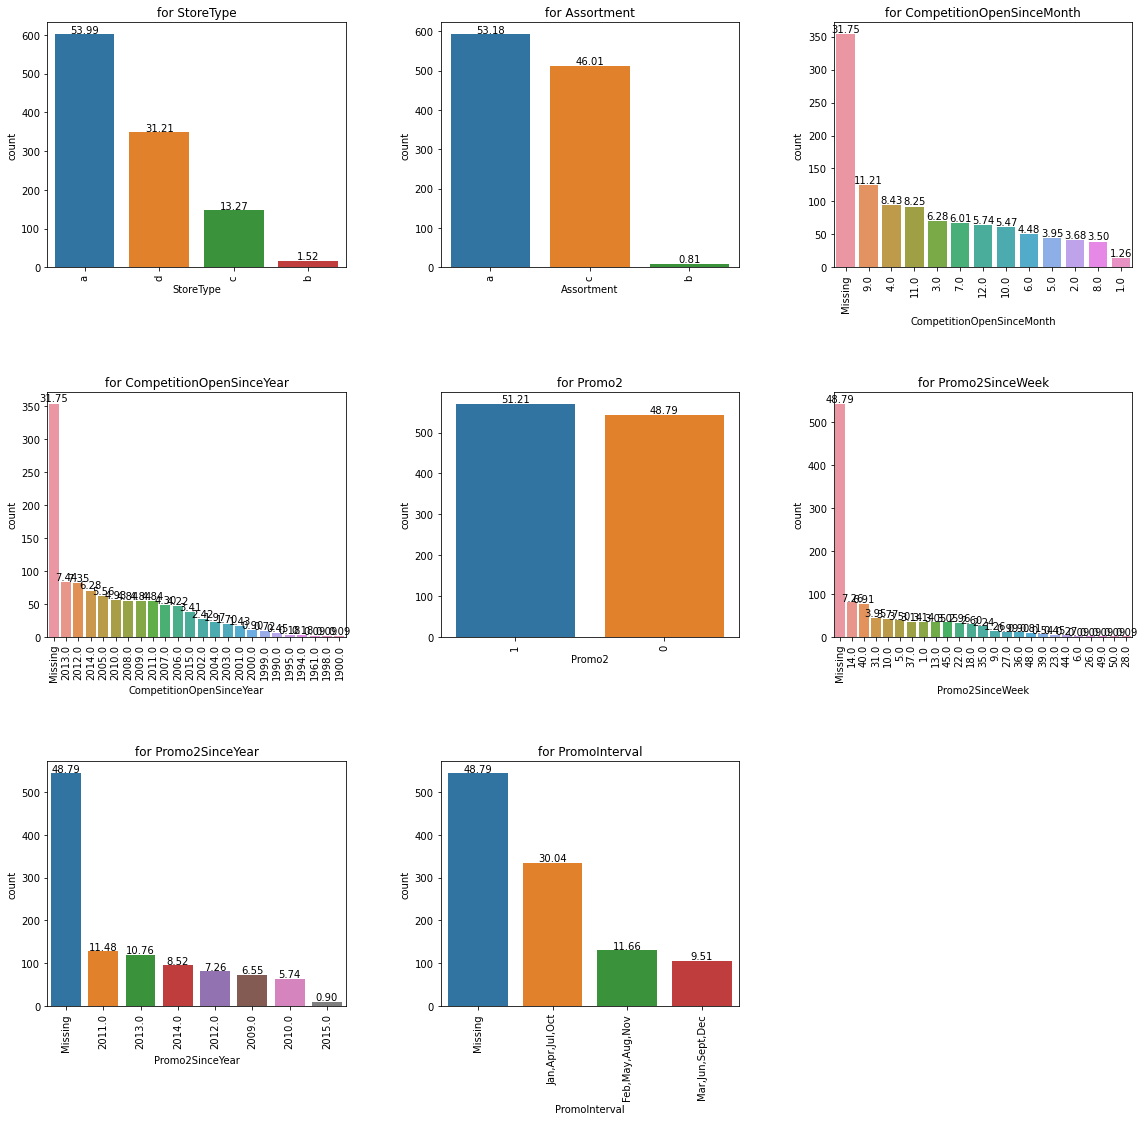

In [44]:
createCountPlot(store_categorical_fields,store)

#### StoreType : We can see there are 4 types of store as a,b,c,d 53.99% stores are of type a and very few stores are of type b.
#### Assortment : We can see there are 3 kind of assortments. Most of those are either a or c.
#### CompetitionOpenSinceMonth : We can see , around 31.75% missing vlues present . Most of the compititors are opened in the month of 9/4/11/3/7.
#### CompetitionOpenSinceYear : We can see , around 31.75% missing values present. Most of the compitiotors have opened during 2006-2014.
#### Promo2: We can see, 48.79% follow up promo value is 0.
#### Promo2SinceWeek : We can see, 48.79% values are missing.Most of the prom happened in the week of 14, 40.
#### Promo2SinceYear : We can see, 48.79% values are missing. Most of the prom happened in the year of 2011, 2013.
#### PromoInterval : We can se , 48.79% values are missing. Most of the promo happened in the month of Jun,Apr,Jul,Oct
#### We can see , for 'Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval' , there is a pattern in missing values. Let's find out more.

In [45]:
store.loc[store['Promo2SinceWeek'].isnull(),:].head(5)

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   
5      6         a          a                310.0                       12.0   
6      7         a          c              24000.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   
5                    2013.0       0              NaN              NaN   
6                    2013.0       0              NaN              NaN   

  PromoInterval  
0           NaN  
3           NaN  
4           NaN  
5           NaN  
6           NaN

In [46]:
store.loc[store['Promo2SinceWeek'].isnull(),:].tail(5)

Store StoreType Assortment  CompetitionDistance  \
1107   1108         a          a                540.0   
1109   1110         c          c                900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
1107                        4.0                    2004.0       0   
1109                        9.0                    2010.0       0   
1111                        4.0                    2006.0       0   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   

      Promo2SinceWeek  Promo2SinceYear PromoInterval  
1107              NaN              NaN           NaN  
1109              NaN              NaN           NaN  
1111              NaN              NaN           NaN  
1112              NaN              NaN           NaN  
1113              NaN              NaN           NaN

In [47]:
store.loc[store.Promo2==0,'Promo2SinceWeek'].unique()

array([nan])

In [48]:
store.loc[store.Promo2==0,'Promo2SinceYear'].unique()

array([nan])

In [49]:
store.loc[store.Promo2==0,'PromoInterval'].unique()

array([nan], dtype=object)

In [50]:
store.loc[store.Promo2==1,'Promo2SinceWeek'].unique()

array([13., 14.,  1., 45., 40., 26., 22.,  5.,  6., 10., 31., 37.,  9.,
       39., 27., 18., 35., 23., 48., 36., 50., 44., 49., 28.])

In [51]:
store.loc[store.Promo2==1,'Promo2SinceYear'].unique()

array([2010., 2011., 2012., 2009., 2014., 2015., 2013.])

In [52]:
store.loc[store.Promo2==1,'PromoInterval'].unique()

array(['Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

#### We can see that, when promo2 value is 0(promo did not happen), the value for Promo2SinceWeek,Promo2SinceYear,PromoInterval are missing. Which is expected.Let's impute these values with 0.

In [53]:
store['Promo2SinceYear'].fillna(0,inplace=True)

In [54]:
store['Promo2SinceWeek'].fillna(0,inplace=True)
store['PromoInterval'].fillna(0,inplace=True)

In [55]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              0.0              0.0   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              0.0              0.0   
4                    2015.0       0              0.0              0.0   

     PromoInterval  
0                0  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3                0  
4                0

In [56]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              0.0              0.0   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              0.0              0.0   
4                    2015.0       0              0.0              0.0   

     PromoInterval  
0                0  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3                0  
4                0

In [57]:
store_metadata=get_meta_data(store)
store_metadata

Datatype  Null_Percentage  Null count  \
Store                        int64             0.00           0   
StoreType                   object             0.00           0   
Assortment                  object             0.00           0   
CompetitionDistance        float64             0.27           3   
CompetitionOpenSinceMonth  float64            31.75         354   
CompetitionOpenSinceYear   float64            31.75         354   
Promo2                       int64             0.00           0   
Promo2SinceWeek            float64             0.00           0   
Promo2SinceYear            float64             0.00           0   
PromoInterval               object             0.00           0   

                           No_Of_Unique_Values  
Store                                     1115  
StoreType                                    4  
Assortment                                   3  
CompetitionDistance                        654  
CompetitionOpenSinceMonth                   12  
CompetitionOpenSinceYear                    23  
Promo2                                       2  
Promo2SinceWeek                             25  
Promo2SinceYear                              8  
PromoInterval                                4

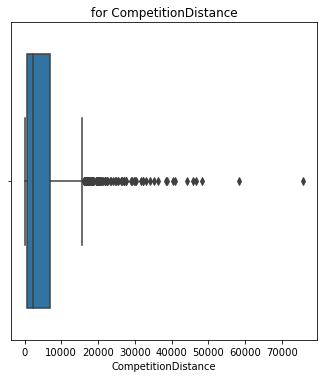

In [58]:
boxPlot(store,['CompetitionDistance'])
# sns.boxplot(df[feature])
# plt.title("for {}".format(feature))

#### We can see clear outliers hear. Let's dig more into this

In [59]:
store[['CompetitionDistance']].quantile([.9,.95,.99])

CompetitionDistance
0.90              15679.0
0.95              20144.5
0.99              35144.7

#### Here we can not delete any records as every record gives details about a store. Let's cap the higher values to 95% value.

In [60]:
store.loc[store.CompetitionDistance>store.CompetitionDistance.quantile(.99),'CompetitionDistance']=store.CompetitionDistance.quantile(.99)
store.shape

(1115, 10)

In [61]:
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              0.0              0.0   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              0.0              0.0   
4                    2015.0       0              0.0              0.0   

     PromoInterval  
0                0  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3                0  
4                0

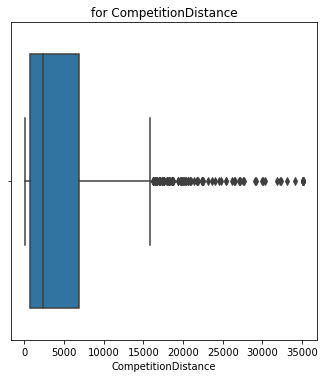

In [62]:
boxPlot(store,['CompetitionDistance'])

#### We can see , Most of the data is distributed within 100-5500.

In [63]:
store_metadata=get_meta_data(store)
store_metadata

Datatype  Null_Percentage  Null count  \
Store                        int64             0.00           0   
StoreType                   object             0.00           0   
Assortment                  object             0.00           0   
CompetitionDistance        float64             0.27           3   
CompetitionOpenSinceMonth  float64            31.75         354   
CompetitionOpenSinceYear   float64            31.75         354   
Promo2                       int64             0.00           0   
Promo2SinceWeek            float64             0.00           0   
Promo2SinceYear            float64             0.00           0   
PromoInterval               object             0.00           0   

                           No_Of_Unique_Values  
Store                                     1115  
StoreType                                    4  
Assortment                                   3  
CompetitionDistance                        643  
CompetitionOpenSinceMonth                   12  
CompetitionOpenSinceYear                    23  
Promo2                                       2  
Promo2SinceWeek                             25  
Promo2SinceYear                              8  
PromoInterval                                4

In [64]:
store.loc[store.CompetitionDistance.isnull(),['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Store']]

CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
290                  NaN                        NaN                       NaN   
621                  NaN                        NaN                       NaN   
878                  NaN                        NaN                       NaN   

     Store  
290    291  
621    622  
878    879

#### We can assume, there are no Comptitors till today, hence everything is NaN.
#### Let's impute all values with 0.

In [65]:
store.loc[store.CompetitionDistance.isnull(),'CompetitionOpenSinceMonth']=0
store.loc[store.CompetitionDistance.isnull(),'CompetitionOpenSinceYear']=0
store.loc[store.CompetitionDistance.isnull(),'CompetitionDistance']=0

In [66]:
store[store.Store.isin([291,622,879])]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  0.0   
621    622         a          c                  0.0   
878    879         d          a                  0.0   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        0.0                       0.0       0   
621                        0.0                       0.0       0   
878                        0.0                       0.0       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              0.0              0.0                0  
621              0.0              0.0                0  
878              5.0           2013.0  Feb,May,Aug,Nov

In [67]:
store.loc[store.CompetitionOpenSinceYear.isnull(),['CompetitionDistance','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Store']]

CompetitionDistance  CompetitionOpenSinceYear  \
11                 1070.0                       NaN   
12                  310.0                       NaN   
15                 3270.0                       NaN   
18                 3240.0                       NaN   
21                 1040.0                       NaN   
...                   ...                       ...   
1095               1130.0                       NaN   
1099                540.0                       NaN   
1112               9260.0                       NaN   
1113                870.0                       NaN   
1114               5350.0                       NaN   

      CompetitionOpenSinceMonth  Store  
11                          NaN     12  
12                          NaN     13  
15                          NaN     16  
18                          NaN     19  
21                          NaN     22  
...                         ...    ...  
1095                        NaN   1096  
1099                        NaN   1100  
1112                        NaN   1113  
1113                        NaN   1114  
1114                        NaN   1115  

[351 rows x 4 columns]

In [68]:
store[store.CompetitionDistance==0]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  0.0   
621    622         a          c                  0.0   
878    879         d          a                  0.0   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        0.0                       0.0       0   
621                        0.0                       0.0       0   
878                        0.0                       0.0       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              0.0              0.0                0  
621              0.0              0.0                0  
878              5.0           2013.0  Feb,May,Aug,Nov

#### We can see , there are many records for which CompetitionDistance value is not 0, but CompetitionOpenSinceYear,CompetitionOpenSinceMonth values are missing.

In [69]:
store_metadata=get_meta_data(store)
store_metadata

Datatype  Null_Percentage  Null count  \
Store                        int64             0.00           0   
StoreType                   object             0.00           0   
Assortment                  object             0.00           0   
CompetitionDistance        float64             0.00           0   
CompetitionOpenSinceMonth  float64            31.48         351   
CompetitionOpenSinceYear   float64            31.48         351   
Promo2                       int64             0.00           0   
Promo2SinceWeek            float64             0.00           0   
Promo2SinceYear            float64             0.00           0   
PromoInterval               object             0.00           0   

                           No_Of_Unique_Values  
Store                                     1115  
StoreType                                    4  
Assortment                                   3  
CompetitionDistance                        644  
CompetitionOpenSinceMonth                   13  
CompetitionOpenSinceYear                    24  
Promo2                                       2  
Promo2SinceWeek                             25  
Promo2SinceYear                              8  
PromoInterval                                4

#### Lets merge train and store table to analyze more.

In [70]:
train.shape

(996974, 9)

In [71]:
store.shape

(1115, 10)

In [72]:
train.head(2)

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   

   SchoolHoliday  
0              1  
1              1

In [73]:
store.head(2)

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              0.0              0.0   
1                    2007.0       1             13.0           2010.0   

     PromoInterval  
0                0  
1  Jan,Apr,Jul,Oct

In [74]:
train_df=train.merge(store, how='inner',on='Store')
train_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      1          4 2015-07-30   5020        546     1      1            0   
2      1          3 2015-07-29   4782        523     1      1            0   
3      1          2 2015-07-28   5011        560     1      1            0   
4      1          1 2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         c          a               1270.0   
2              1         c          a               1270.0   
3              1         c          a               1270.0   
4              1         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval  
0              0.0              0.0             0  
1              0.0              0.0             0  
2              0.0              0.0             0  
3              0.0              0.0             0  
4              0.0              0.0             0

In [75]:
train_df.shape

(996974, 18)

In [76]:
train_df_metadata=get_meta_data(train_df)
train_df_metadata

Datatype  Null_Percentage  Null count  \
Store                               int64             0.00           0   
DayOfWeek                           int64             0.00           0   
Date                       datetime64[ns]             0.00           0   
Sales                               int64             0.00           0   
Customers                           int64             0.00           0   
Open                                int64             0.00           0   
Promo                               int64             0.00           0   
StateHoliday                       object             0.00           0   
SchoolHoliday                       int64             0.00           0   
StoreType                          object             0.00           0   
Assortment                         object             0.00           0   
CompetitionDistance               float64             0.00           0   
CompetitionOpenSinceMonth         float64            31.43      313334   
CompetitionOpenSinceYear          float64            31.43      313334   
Promo2                              int64             0.00           0   
Promo2SinceWeek                   float64             0.00           0   
Promo2SinceYear                   float64             0.00           0   
PromoInterval                      object             0.00           0   

                           No_Of_Unique_Values  
Store                                     1115  
DayOfWeek                                    7  
Date                                       942  
Sales                                    14694  
Customers                                 2206  
Open                                         2  
Promo                                        2  
StateHoliday                                 4  
SchoolHoliday                                2  
StoreType                                    4  
Assortment                                   3  
CompetitionDistance                        644  
CompetitionOpenSinceMonth                   13  
CompetitionOpenSinceYear                    24  
Promo2                                       2  
Promo2SinceWeek                             25  
Promo2SinceYear                              8  
PromoInterval                                4

#### After merging we can see 31.43% values are missing in CompetitionOpenSinceMonth,CompetitionOpenSinceYear. Let's apply KNNImputer to impute missing values.

### Bivariant analysis

In [77]:
def boxPlotBiVariant(features,df):
    cols=3
    rows = len(features)//cols +1
    fig = plt.figure(figsize=(15, rows*5))
    for plot, feature in enumerate(features):
        fig.add_subplot(rows,cols,plot+1)
        fig.tight_layout(h_pad=5, w_pad=5)
        sns.boxplot(y='Sales',x=feature,data=df)
        plt.title('Distribution of {}'.format(feature))
        plt.xticks(rotation = 90)

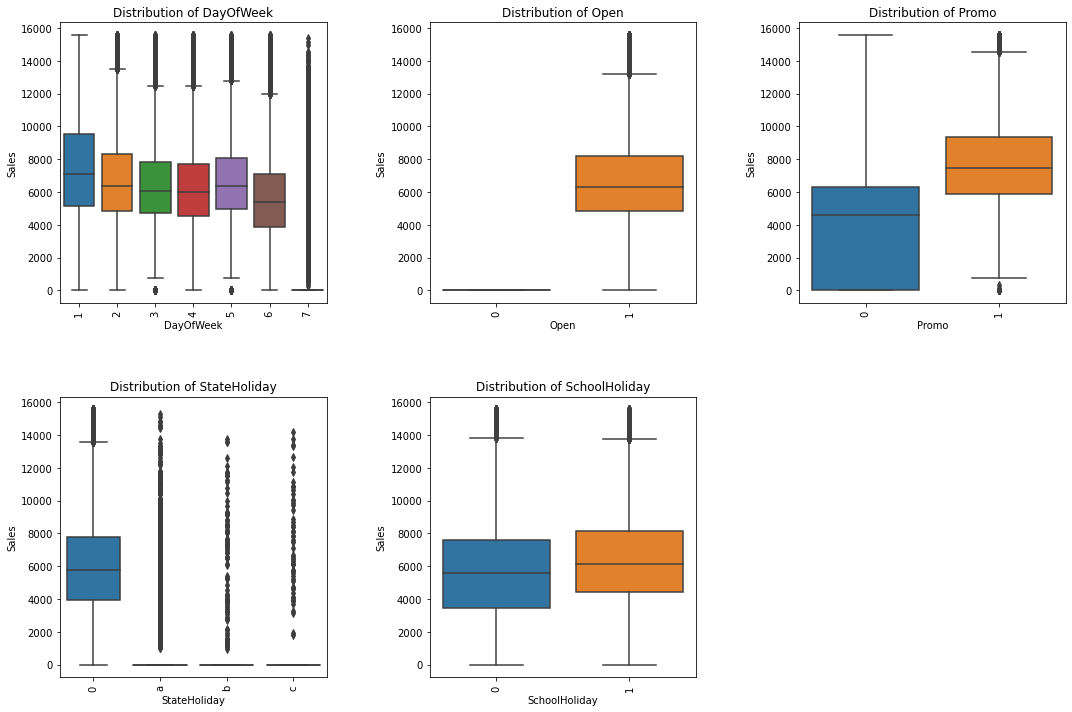

In [78]:
boxPlotBiVariant(['DayOfWeek','Open','Promo','StateHoliday','SchoolHoliday'],train_df)

#### DayOfWeek : In 1st nd 5th day of the week, the sales are comparatively high than other days. On Day 7, sales are very less. Most of the stores might be closed on that day. For other day, there is not much variation in sales. We can ignore this field as it does not have any impact on sales.

In [79]:
train_df.loc[train_df.DayOfWeek==7,['DayOfWeek','Open']].head()

DayOfWeek  Open
5           7     0
12          7     0
19          7     0
26          7     0
33          7     0

In [80]:
train_df.loc[train_df.DayOfWeek==7,'Open'].value_counts()

0    141137
1      2745
Name: Open, dtype: int64

#### Open: The sales value is 0 when the Store is closed. We should remove the records with Open=0 from the dataset before forecasting

In [81]:
train_df.loc[train_df.Open==0,'Sales'].value_counts()

0    172817
Name: Sales, dtype: int64

#### Promo: We can see promo has very significant impact on sales. 

In [82]:
train_df.loc[train_df.StateHoliday!='0','Open'].value_counts()

0    30140
1      731
Name: Open, dtype: int64

In [83]:
train_df.groupby(['StateHoliday','Open']).Sales.mean()

StateHoliday  Open
0             0          0.000000
              1       6695.610374
a             0          0.000000
              1       6573.375652
b             0          0.000000
              1       6051.020000
c             0          0.000000
              1       7483.589286
Name: Sales, dtype: float64

#### StateHoliday: Looks like, during StateHoliday, the sales are falling tremendously for all stores. This might be because of during State Holidays , Stores are remained closed. Also when we check store wise, then there is not much changes in sales during state holidays.We should not consider StateHolidays as driving factor Sales.

#### SchoolHoliday:We can see, a little rise in case of 1, which indicates most of the (Store, Date) was affected by the closure of public schools. The sales value is rising during the closure of public schools. Merge all StateHoliday value to 1.

In [84]:
train_df.loc[train_df.StateHoliday!='0','StateHoliday']='1'

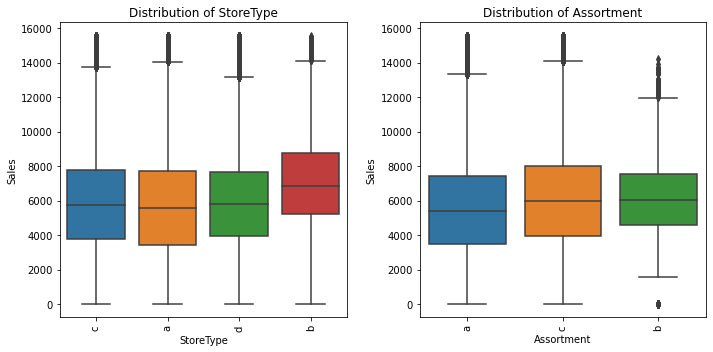

In [85]:
boxPlotBiVariant(['StoreType','Assortment'],train_df)

#### We can see for store type b, the sales are comparatively high than others.
#### We can see for Assortment c, the sales are comparatively high than others.

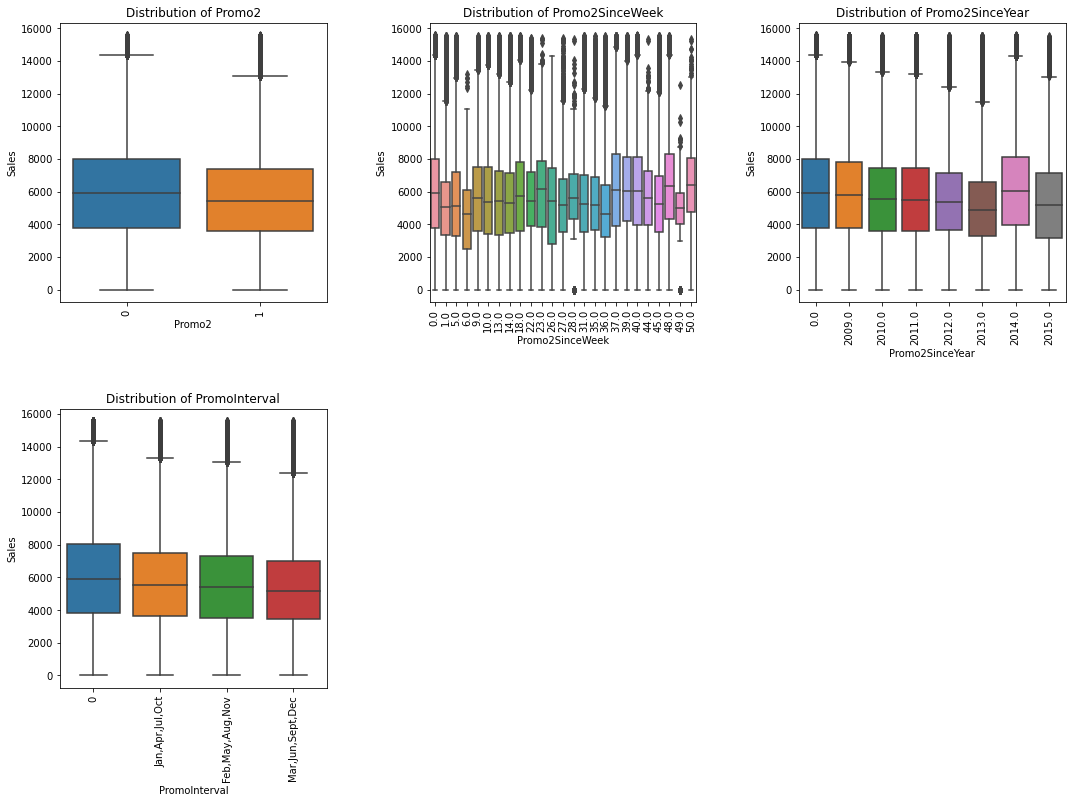

In [86]:
boxPlotBiVariant(['Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval'],train_df)

#### Promo2: There is no impact of Promo2 on sales. From the above graph we can not say what is the impact of Promo2. We will investigate more.

In [87]:
def scatterplot(features,df):
    cols=3
    rows = len(features)//cols +1
    fig = plt.figure(figsize=(16, rows*5))
    for plot, feature in enumerate(features):
        fig.add_subplot(rows,cols,plot+1)
        fig.tight_layout(h_pad=3, w_pad=3)
        plt.scatter(y=df['Sales'],x=df[feature])
        plt.xlabel(feature)
        plt.ylabel('SalePrice')
        plt.xticks(rotation = 90)
        plt.title("for {}".format(feature))

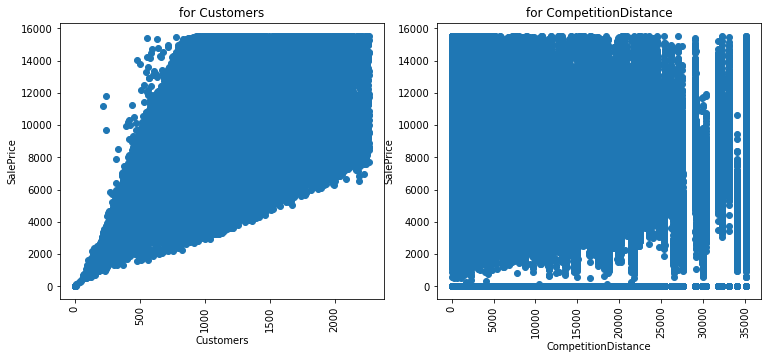

In [88]:
scatterplot(['Customers','CompetitionDistance'],train_df)

#### We can see, when customer number increases , sales value also increases.
#### We can not say anything about the impact of competitionDistance

#### Merge CompetitionOpenSinceMonth,CompetitionOpenSinceYear into a single date time column.

In [89]:
train_df.CompetitionOpenSinceYear.fillna(0,inplace=True)

In [90]:
train_df.CompetitionOpenSinceMonth.fillna(0,inplace=True)

In [91]:
train_df['CompetitionOpenSince'] = train_df.CompetitionOpenSinceYear.astype(int).astype(str) + '-' + train_df.CompetitionOpenSinceMonth.astype(int).astype(str) + '-01'
train_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      1          4 2015-07-30   5020        546     1      1            0   
2      1          3 2015-07-29   4782        523     1      1            0   
3      1          2 2015-07-28   5011        560     1      1            0   
4      1          1 2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         c          a               1270.0   
2              1         c          a               1270.0   
3              1         c          a               1270.0   
4              1         c          a               1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval CompetitionOpenSince  
0              0.0              0.0             0            2008-9-01  
1              0.0              0.0             0            2008-9-01  
2              0.0              0.0             0            2008-9-01  
3              0.0              0.0             0            2008-9-01  
4              0.0              0.0             0            2008-9-01

In [92]:
train_df[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','CompetitionOpenSince']].head()

CompetitionOpenSinceMonth  CompetitionOpenSinceYear CompetitionOpenSince
0                        9.0                    2008.0            2008-9-01
1                        9.0                    2008.0            2008-9-01
2                        9.0                    2008.0            2008-9-01
3                        9.0                    2008.0            2008-9-01
4                        9.0                    2008.0            2008-9-01

In [93]:
#### Remove CompetitionOpenSinceMonth, CompetitionOpenSinceYear
train_df.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear'],axis=1,inplace=True)

In [94]:
train_df_metadata=get_meta_data(train_df)
train_df_metadata

Datatype  Null_Percentage  Null count  \
Store                          int64              0.0           0   
DayOfWeek                      int64              0.0           0   
Date                  datetime64[ns]              0.0           0   
Sales                          int64              0.0           0   
Customers                      int64              0.0           0   
Open                           int64              0.0           0   
Promo                          int64              0.0           0   
StateHoliday                  object              0.0           0   
SchoolHoliday                  int64              0.0           0   
StoreType                     object              0.0           0   
Assortment                    object              0.0           0   
CompetitionDistance          float64              0.0           0   
Promo2                         int64              0.0           0   
Promo2SinceWeek              float64              0.0           0   
Promo2SinceYear              float64              0.0           0   
PromoInterval                 object              0.0           0   
CompetitionOpenSince          object              0.0           0   

                      No_Of_Unique_Values  
Store                                1115  
DayOfWeek                               7  
Date                                  942  
Sales                               14694  
Customers                            2206  
Open                                    2  
Promo                                   2  
StateHoliday                            2  
SchoolHoliday                           2  
StoreType                               4  
Assortment                              3  
CompetitionDistance                   644  
Promo2                                  2  
Promo2SinceWeek                        25  
Promo2SinceYear                         8  
PromoInterval                           4  
CompetitionOpenSince                  172

In [95]:
train_df.shape

(996974, 17)

In [96]:
train_df['CompetitionOpenSince'].value_counts()

0-0-01        315969
2012-9-01      28255
2012-11-01     15064
2013-4-01      12993
2009-9-01      12984
               ...  
2014-1-01        758
2009-12-01       758
2000-7-01        736
2001-12-01       699
2002-3-01        253
Name: CompetitionOpenSince, Length: 172, dtype: int64

In [97]:
train_df[train_df.CompetitionOpenSince=='0-0-01'].head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
10333     12          5 2015-07-31   8959        962     1      1   
10334     12          4 2015-07-30   7996        835     1      1   
10335     12          3 2015-07-29   9236        989     1      1   
10336     12          2 2015-07-28   8822        861     1      1   
10337     12          1 2015-07-27  10227        979     1      1   

      StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
10333            0              1         a          c               1070.0   
10334            0              1         a          c               1070.0   
10335            0              1         a          c               1070.0   
10336            0              1         a          c               1070.0   
10337            0              1         a          c               1070.0   

       Promo2  Promo2SinceWeek  Promo2SinceYear    PromoInterval  \
10333       1             13.0           2010.0  Jan,Apr,Jul,Oct   
10334       1             13.0           2010.0  Jan,Apr,Jul,Oct   
10335       1             13.0           2010.0  Jan,Apr,Jul,Oct   
10336       1             13.0           2010.0  Jan,Apr,Jul,Oct   
10337       1             13.0           2010.0  Jan,Apr,Jul,Oct   

      CompetitionOpenSince  
10333               0-0-01  
10334               0-0-01  
10335               0-0-01  
10336               0-0-01  
10337               0-0-01

In [98]:
train_df.loc[train_df.CompetitionOpenSince=='0-0-01','CompetitionOpenSince']=np.nan

In [99]:
train_df['CompetitionOpenSince'].value_counts()

2012-9-01     28255
2012-11-01    15064
2013-4-01     12993
2009-9-01     12984
2013-9-01     11292
              ...  
2014-1-01       758
2009-12-01      758
2000-7-01       736
2001-12-01      699
2002-3-01       253
Name: CompetitionOpenSince, Length: 171, dtype: int64

In [100]:
train_df_metadata=get_meta_data(train_df)
train_df_metadata

Datatype  Null_Percentage  Null count  \
Store                          int64             0.00           0   
DayOfWeek                      int64             0.00           0   
Date                  datetime64[ns]             0.00           0   
Sales                          int64             0.00           0   
Customers                      int64             0.00           0   
Open                           int64             0.00           0   
Promo                          int64             0.00           0   
StateHoliday                  object             0.00           0   
SchoolHoliday                  int64             0.00           0   
StoreType                     object             0.00           0   
Assortment                    object             0.00           0   
CompetitionDistance          float64             0.00           0   
Promo2                         int64             0.00           0   
Promo2SinceWeek              float64             0.00           0   
Promo2SinceYear              float64             0.00           0   
PromoInterval                 object             0.00           0   
CompetitionOpenSince          object            31.69      315969   

                      No_Of_Unique_Values  
Store                                1115  
DayOfWeek                               7  
Date                                  942  
Sales                               14694  
Customers                            2206  
Open                                    2  
Promo                                   2  
StateHoliday                            2  
SchoolHoliday                           2  
StoreType                               4  
Assortment                              3  
CompetitionDistance                   644  
Promo2                                  2  
Promo2SinceWeek                        25  
Promo2SinceYear                         8  
PromoInterval                           4  
CompetitionOpenSince                  171

## Multivariant analysis

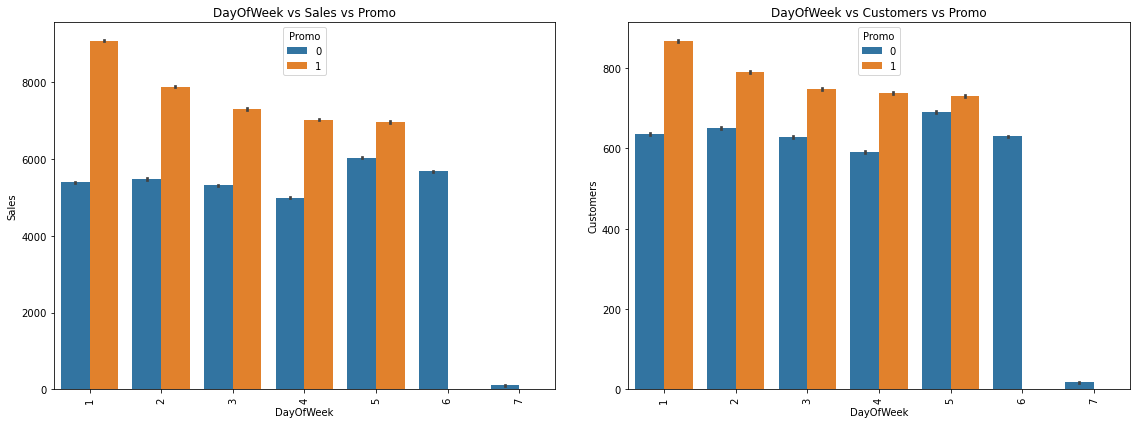

In [101]:
fig = plt.figure(figsize=(16, 6))
    
fig.add_subplot(1,2,1)
fig.tight_layout(h_pad=5, w_pad=5)
sns.barplot(x='DayOfWeek',y='Sales',hue='Promo',data=train_df)
plt.title("DayOfWeek vs Sales vs Promo")
plt.xticks(rotation = 90)

fig.add_subplot(1,2,2)
fig.tight_layout(h_pad=5, w_pad=5)
sns.barplot(x='DayOfWeek',y='Customers',hue='Promo',data=train_df)
plt.title("DayOfWeek vs Customers vs Promo")
plt.xticks(rotation = 90)

plt.show()

#### We can see , when Promotion is going on the sales and customers are increasing very significantly. On weekdy-7, there is no promotion, sales and no of customers are very less.

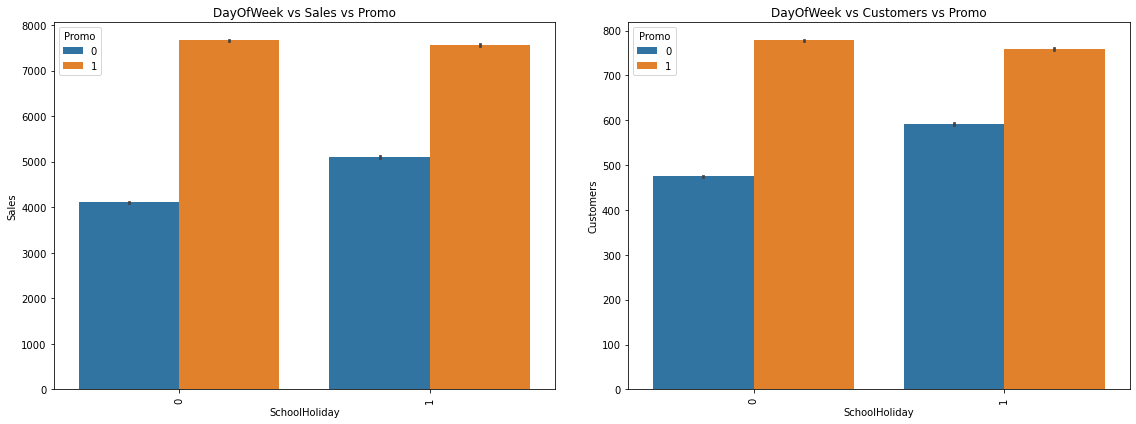

In [102]:
fig = plt.figure(figsize=(16, 6))
    
fig.add_subplot(1,2,1)
fig.tight_layout(h_pad=5, w_pad=5)
sns.barplot(x='SchoolHoliday',y='Sales',hue='Promo',data=train_df)
plt.title("DayOfWeek vs Sales vs Promo")
plt.xticks(rotation = 90)

fig.add_subplot(1,2,2)
fig.tight_layout(h_pad=5, w_pad=5)
sns.barplot(x='SchoolHoliday',y='Customers',hue='Promo',data=train_df)
plt.title("DayOfWeek vs Customers vs Promo")
plt.xticks(rotation = 90)

plt.show()

#### We can see when there is a school holiday and promotion is going on, no of customers and sales goes up significantly than other day.

<Figure size 2880x2880 with 0 Axes>

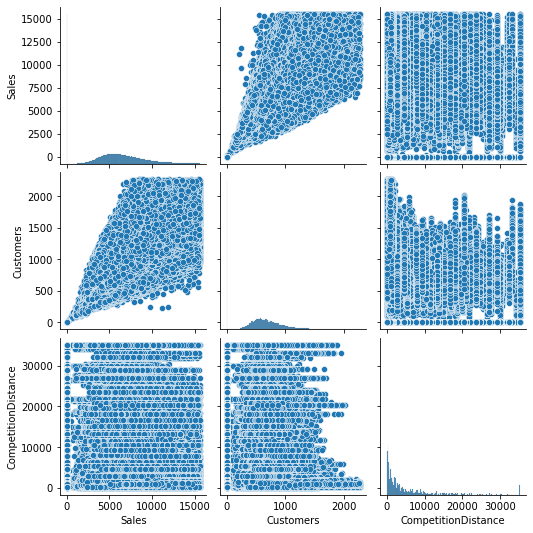

In [103]:
# paiwise scatter plot

plt.figure(figsize=(40, 40))
sns.pairplot(train_df[['Sales','Customers','CompetitionDistance']])
plt.show()

#### We can see, with increase of customers ,sales is increasing and vice versa. But for cometition distance we can not say anything about sales and customers.

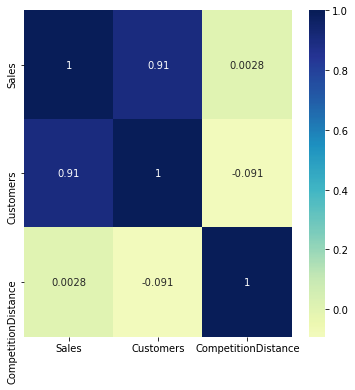

In [104]:
# plot heat map for corr
cor = train_df[['Sales','Customers','CompetitionDistance']].corr()
plt.figure(figsize = (6, 6))
sns.heatmap(cor, annot = True,center=0.4,cmap="YlGnBu")
plt.show()

#### We can see, sales and customers are highly correlated with correlation coefficient value 0.91 .
#### The correlation coefficient values  of CompititionDistance with Sales and Customers are very low.

In [105]:
train_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      1          4 2015-07-30   5020        546     1      1            0   
2      1          3 2015-07-29   4782        523     1      1            0   
3      1          2 2015-07-28   5011        560     1      1            0   
4      1          1 2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  Promo2  \
0              1         c          a               1270.0       0   
1              1         c          a               1270.0       0   
2              1         c          a               1270.0       0   
3              1         c          a               1270.0       0   
4              1         c          a               1270.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval CompetitionOpenSince  
0              0.0              0.0             0            2008-9-01  
1              0.0              0.0             0            2008-9-01  
2              0.0              0.0             0            2008-9-01  
3              0.0              0.0             0            2008-9-01  
4              0.0              0.0             0            2008-9-01

#### Promo2 data is at Store level. If Promo2 is 1, When we merged it marked Promo2 as 1 for all day, which is not correct.We have the information when Promo2 is started and when it is applicable. Let's calculate Promo2 value.

In [106]:
train_df_metadata=get_meta_data(train_df)
train_df_metadata

Datatype  Null_Percentage  Null count  \
Store                          int64             0.00           0   
DayOfWeek                      int64             0.00           0   
Date                  datetime64[ns]             0.00           0   
Sales                          int64             0.00           0   
Customers                      int64             0.00           0   
Open                           int64             0.00           0   
Promo                          int64             0.00           0   
StateHoliday                  object             0.00           0   
SchoolHoliday                  int64             0.00           0   
StoreType                     object             0.00           0   
Assortment                    object             0.00           0   
CompetitionDistance          float64             0.00           0   
Promo2                         int64             0.00           0   
Promo2SinceWeek              float64             0.00           0   
Promo2SinceYear              float64             0.00           0   
PromoInterval                 object             0.00           0   
CompetitionOpenSince          object            31.69      315969   

                      No_Of_Unique_Values  
Store                                1115  
DayOfWeek                               7  
Date                                  942  
Sales                               14694  
Customers                            2206  
Open                                    2  
Promo                                   2  
StateHoliday                            2  
SchoolHoliday                           2  
StoreType                               4  
Assortment                              3  
CompetitionDistance                   644  
Promo2                                  2  
Promo2SinceWeek                        25  
Promo2SinceYear                         8  
PromoInterval                           4  
CompetitionOpenSince                  171

In [107]:

# week>=week year>=Year month is in the list
def calculate_promo2(row):
    if row['Promo2']==0:
        return 0
    elif row['Date'].year>row['Promo2SinceYear'] and calendar.month_abbr[row['Date'].month].upper() in row['PromoInterval'].upper().split(','):
        return 1
    elif row['Date'].week>=row['Promo2SinceWeek'] and row['Date'].year==row['Promo2SinceYear'] and calendar.month_abbr[row['Date'].month].upper() in row['PromoInterval'].upper().split(','):
        return 1
    else:
        return 0
train_df['Promo2Actual']=train_df[['Promo2','Date','Promo2SinceWeek','Promo2SinceYear','PromoInterval']].apply(calculate_promo2,axis=1)

In [108]:
train_df[['Promo2','Date','Promo2SinceWeek','Promo2SinceYear','PromoInterval','Promo2Actual']].head()

Promo2       Date  Promo2SinceWeek  Promo2SinceYear PromoInterval  \
0       0 2015-07-31              0.0              0.0             0   
1       0 2015-07-30              0.0              0.0             0   
2       0 2015-07-29              0.0              0.0             0   
3       0 2015-07-28              0.0              0.0             0   
4       0 2015-07-27              0.0              0.0             0   

   Promo2Actual  
0             0  
1             0  
2             0  
3             0  
4             0

In [109]:
train_df[['Promo2','Date','Promo2SinceWeek','Promo2SinceYear','PromoInterval','Promo2Actual']].tail()

Promo2       Date  Promo2SinceWeek  Promo2SinceYear PromoInterval  \
996969       0 2014-12-24              0.0              0.0             0   
996970       0 2014-10-26              0.0              0.0             0   
996971       0 2013-12-31              0.0              0.0             0   
996972       0 2013-12-24              0.0              0.0             0   
996973       0 2014-10-15              0.0              0.0             0   

        Promo2Actual  
996969             0  
996970             0  
996971             0  
996972             0  
996973             0

In [110]:
train_df.loc[(train_df.Promo2==1) & (train_df.Promo2Actual==0),:].shape

(358539, 18)

In [111]:
train_df.Promo2.value_counts()

1    504077
0    492897
Name: Promo2, dtype: int64

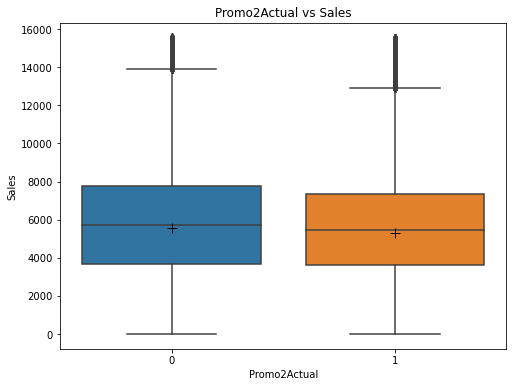

In [112]:
# boxPlotBiVariant(['Promo2Actual'],train_df)
fig = plt.figure(figsize=(8, 6))
sns.boxplot(y='Sales',x='Promo2Actual',data=train_df,showmeans=True,
            meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"})
plt.title("Promo2Actual vs Sales")

plt.show()


#### We can see, Promo2 has no impact on sales. The mean value for both cases are lying at same point.

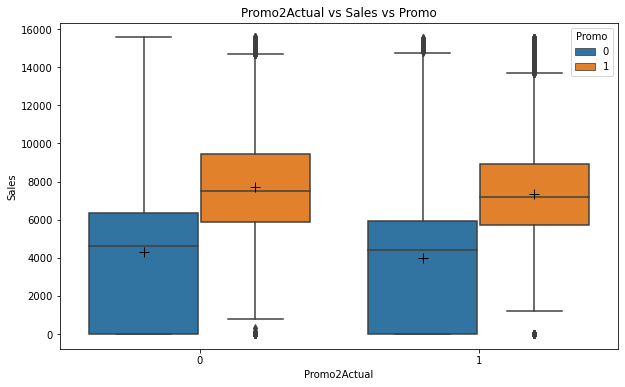

In [113]:
# train_df_promo=train_df.loc[train_df.Promo==1,:]
# boxPlotBiVariant(['Promo2Actual'],train_df_promo)


fig = plt.figure(figsize=(10, 6))
sns.boxplot(y='Sales',x='Promo2Actual',hue='Promo',data=train_df,showmeans=True,
            meanprops={"marker": "+",
                       "markeredgecolor": "black",
                       "markersize": "10"})
plt.title("Promo2Actual vs Sales vs Promo")

plt.show()

#### Here we can see, the average sells is increasing because of Promo, not by Promo2Actual.By providing extra promotions (promo2), it is not affecting the sell. Here we can say, promo has greater impact on sales, rather any continuous promotions.

In [114]:
def plot_linegraph_promo(store):
    fig = plt.figure(figsize=(20, 10))
    
    fig.add_subplot(2,1,1)
    y1=list(train_df[(train_df.Store==store) & (train_df.Promo2Actual==0)].Sales)
    x1=list(train_df[(train_df.Store==store) & (train_df.Promo2Actual==0)].Date)
    y2=list(train_df[(train_df.Store==store) & (train_df.Promo2Actual==1)].Sales)
    x2=list(train_df[(train_df.Store==store) & (train_df.Promo2Actual==1)].Date)
    plt.plot(x1,y1,label='no promo2',color='green')
    plt.plot(x2,y2,label='wgile promo2',color='red')
    plt.title("Sales change with promo2  store={}".format(store))
    plt.legend()
    
    month=train_df[(train_df.Store==store) & (train_df.Promo2Actual==1)].PromoInterval.unique()
    year=train_df[(train_df.Store==store) & (train_df.Promo2Actual==1)].Promo2SinceYear.unique()
    if(len(month)>0):
        month=month[0].split(',')[2]
        year=year[0]
    
        month_map={'jan':1,'feb':2,'mar':3,'apr':4,
              'may':4,'jun':6,'jul':7,'aug':8,
              'sep':9,'oct':10,'nov':11,'dec':12}
        train_df_filter=train_df[(train_df['Date'].dt.month==month_map[month.lower()]) |
                                                            (train_df['Date'].dt.month+1==month_map[month.lower()])]
        fig.add_subplot(2,1,2)
        y1=list(train_df_filter[(train_df_filter.Store==store) & (train_df_filter.Promo2Actual==0)].Sales)
        x1=list(train_df_filter[(train_df_filter.Store==store) & (train_df_filter.Promo2Actual==0)].Date)
        y2=list(train_df_filter[(train_df_filter.Store==store) & (train_df_filter.Promo2Actual==1)].Sales)
        x2=list(train_df_filter[(train_df_filter.Store==store) & (train_df_filter.Promo2Actual==1)].Date)
        plt.plot(x1,y1,label='no promo2',color='green')
        plt.plot(x2,y2,label='wgile promo2',color='red')
        plt.title("Sales change with promo2  for 60 days  store={}".format(store))
        plt.legend()

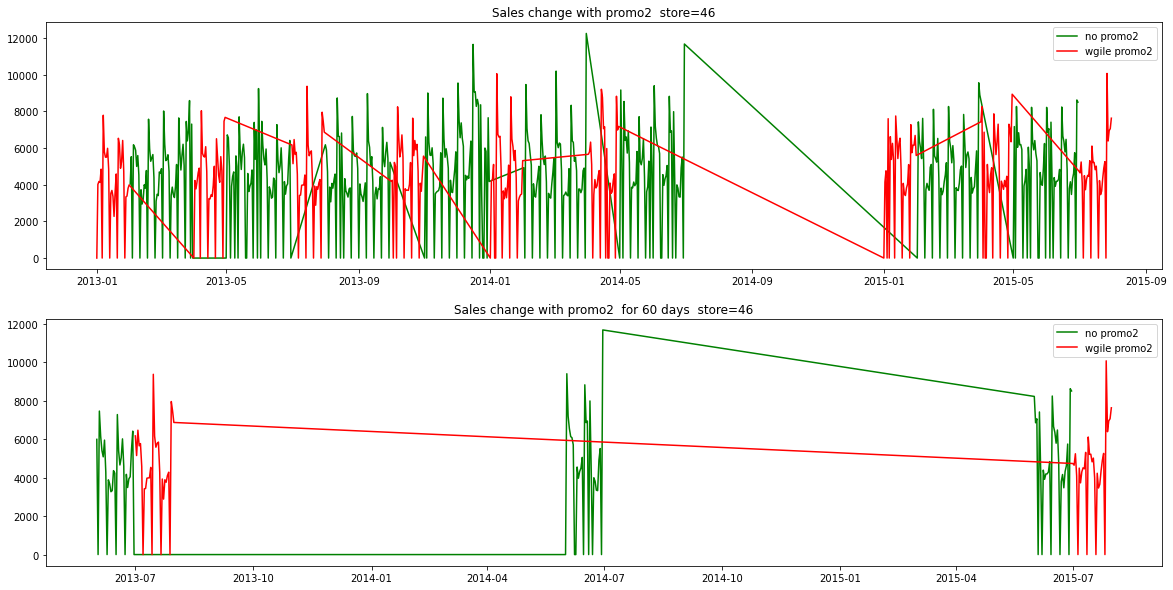

In [115]:
plot_linegraph_promo(46)

#### Here we can see a hike in sales marginally for few days when promo2 is started.

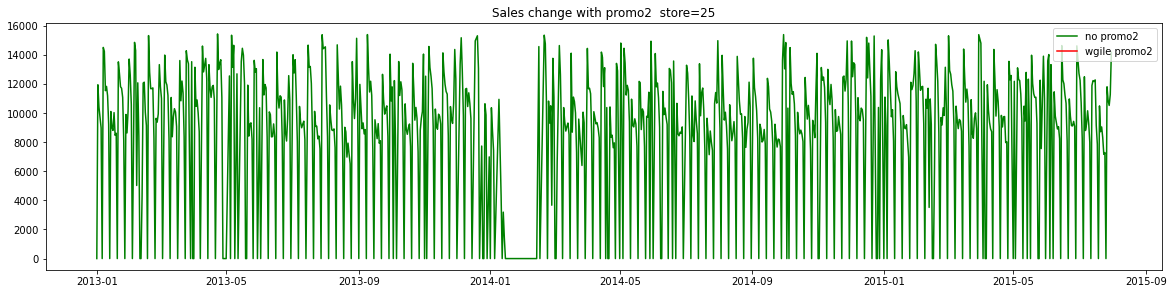

In [116]:
plot_linegraph_promo(25)

#### No promo2 for store 25.

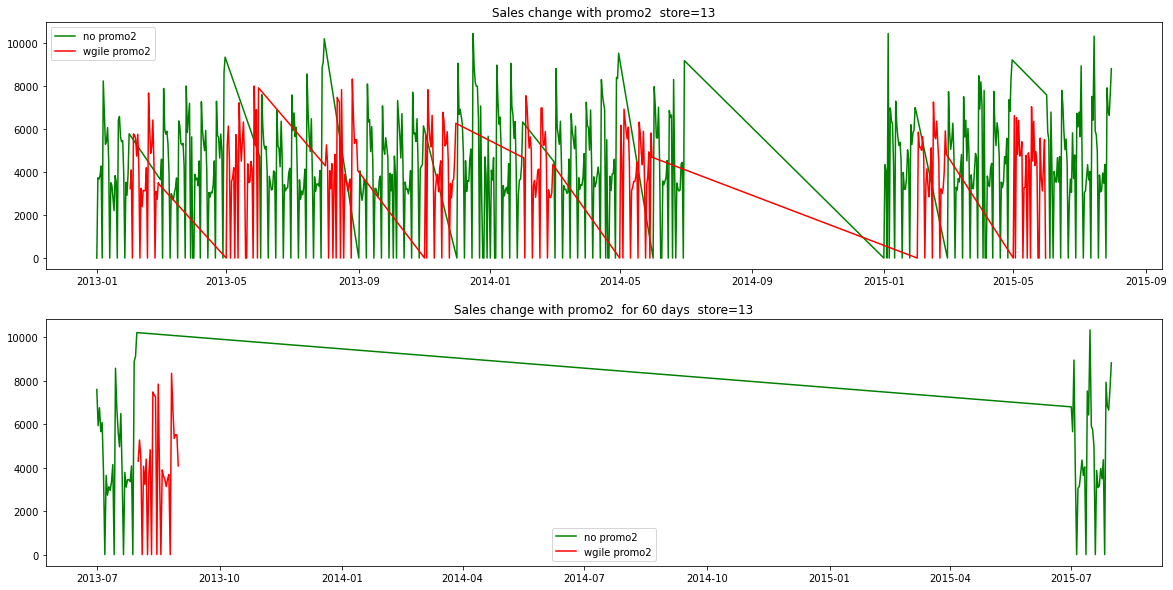

In [117]:
plot_linegraph_promo(13)

#### Here we can see very marginal increase in sales for store 13.

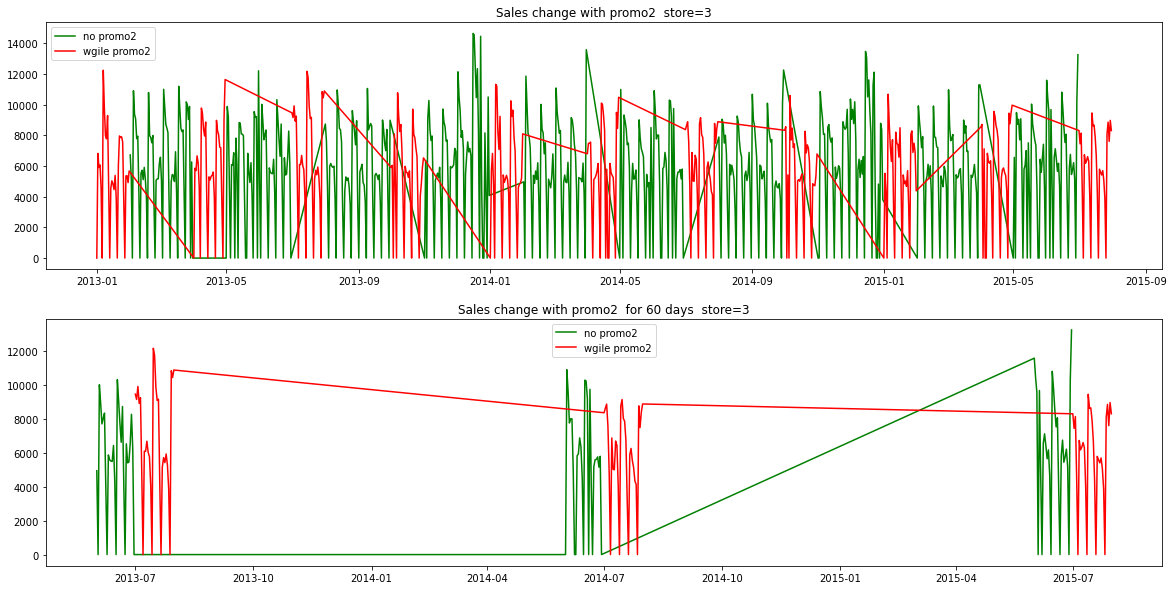

In [118]:
plot_linegraph_promo(3)

#### For store 3 we can see no effect of promo2 when promo2 started.

#### Fromo above analysis on store wise we can see that , promo2 has very little effect on sales that to for short period of days.

In [119]:
train_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      1          4 2015-07-30   5020        546     1      1            0   
2      1          3 2015-07-29   4782        523     1      1            0   
3      1          2 2015-07-28   5011        560     1      1            0   
4      1          1 2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  Promo2  \
0              1         c          a               1270.0       0   
1              1         c          a               1270.0       0   
2              1         c          a               1270.0       0   
3              1         c          a               1270.0       0   
4              1         c          a               1270.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval CompetitionOpenSince  \
0              0.0              0.0             0            2008-9-01   
1              0.0              0.0             0            2008-9-01   
2              0.0              0.0             0            2008-9-01   
3              0.0              0.0             0            2008-9-01   
4              0.0              0.0             0            2008-9-01   

   Promo2Actual  
0             0  
1             0  
2             0  
3             0  
4             0

In [120]:
#### As we have calculated Promo2Actual we can remove Promo2.
train_df.drop('Promo2',axis=1,inplace=True)

In [121]:
train_df.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      1          4 2015-07-30   5020        546     1      1            0   
2      1          3 2015-07-29   4782        523     1      1            0   
3      1          2 2015-07-28   5011        560     1      1            0   
4      1          1 2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  Promo2SinceWeek  \
0              1         c          a               1270.0              0.0   
1              1         c          a               1270.0              0.0   
2              1         c          a               1270.0              0.0   
3              1         c          a               1270.0              0.0   
4              1         c          a               1270.0              0.0   

   Promo2SinceYear PromoInterval CompetitionOpenSince  Promo2Actual  
0              0.0             0            2008-9-01             0  
1              0.0             0            2008-9-01             0  
2              0.0             0            2008-9-01             0  
3              0.0             0            2008-9-01             0  
4              0.0             0            2008-9-01             0

In [122]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996974 entries, 0 to 996973
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Store                 996974 non-null  int64         
 1   DayOfWeek             996974 non-null  int64         
 2   Date                  996974 non-null  datetime64[ns]
 3   Sales                 996974 non-null  int64         
 4   Customers             996974 non-null  int64         
 5   Open                  996974 non-null  int64         
 6   Promo                 996974 non-null  int64         
 7   StateHoliday          996974 non-null  object        
 8   SchoolHoliday         996974 non-null  int64         
 9   StoreType             996974 non-null  object        
 10  Assortment            996974 non-null  object        
 11  CompetitionDistance   996974 non-null  float64       
 12  Promo2SinceWeek       996974 non-null  float64       
 13 

In [123]:
train_df_metadata=get_meta_data(train_df)
train_df_metadata

Datatype  Null_Percentage  Null count  \
Store                          int64             0.00           0   
DayOfWeek                      int64             0.00           0   
Date                  datetime64[ns]             0.00           0   
Sales                          int64             0.00           0   
Customers                      int64             0.00           0   
Open                           int64             0.00           0   
Promo                          int64             0.00           0   
StateHoliday                  object             0.00           0   
SchoolHoliday                  int64             0.00           0   
StoreType                     object             0.00           0   
Assortment                    object             0.00           0   
CompetitionDistance          float64             0.00           0   
Promo2SinceWeek              float64             0.00           0   
Promo2SinceYear              float64             0.00           0   
PromoInterval                 object             0.00           0   
CompetitionOpenSince          object            31.69      315969   
Promo2Actual                   int64             0.00           0   

                      No_Of_Unique_Values  
Store                                1115  
DayOfWeek                               7  
Date                                  942  
Sales                               14694  
Customers                            2206  
Open                                    2  
Promo                                   2  
StateHoliday                            2  
SchoolHoliday                           2  
StoreType                               4  
Assortment                              3  
CompetitionDistance                   644  
Promo2SinceWeek                        25  
Promo2SinceYear                         8  
PromoInterval                           4  
CompetitionOpenSince                  171  
Promo2Actual                            2

In [124]:
train_df['CompetitionOpenSince']=pd.to_datetime(train_df['CompetitionOpenSince'],errors='coerce')

In [125]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996974 entries, 0 to 996973
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Store                 996974 non-null  int64         
 1   DayOfWeek             996974 non-null  int64         
 2   Date                  996974 non-null  datetime64[ns]
 3   Sales                 996974 non-null  int64         
 4   Customers             996974 non-null  int64         
 5   Open                  996974 non-null  int64         
 6   Promo                 996974 non-null  int64         
 7   StateHoliday          996974 non-null  object        
 8   SchoolHoliday         996974 non-null  int64         
 9   StoreType             996974 non-null  object        
 10  Assortment            996974 non-null  object        
 11  CompetitionDistance   996974 non-null  float64       
 12  Promo2SinceWeek       996974 non-null  float64       
 13 

In [126]:
train_df_metadata=get_meta_data(train_df)
train_df_metadata

Datatype  Null_Percentage  Null count  \
Store                          int64             0.00           0   
DayOfWeek                      int64             0.00           0   
Date                  datetime64[ns]             0.00           0   
Sales                          int64             0.00           0   
Customers                      int64             0.00           0   
Open                           int64             0.00           0   
Promo                          int64             0.00           0   
StateHoliday                  object             0.00           0   
SchoolHoliday                  int64             0.00           0   
StoreType                     object             0.00           0   
Assortment                    object             0.00           0   
CompetitionDistance          float64             0.00           0   
Promo2SinceWeek              float64             0.00           0   
Promo2SinceYear              float64             0.00           0   
PromoInterval                 object             0.00           0   
CompetitionOpenSince  datetime64[ns]            31.69      315969   
Promo2Actual                   int64             0.00           0   

                      No_Of_Unique_Values  
Store                                1115  
DayOfWeek                               7  
Date                                  942  
Sales                               14694  
Customers                            2206  
Open                                    2  
Promo                                   2  
StateHoliday                            2  
SchoolHoliday                           2  
StoreType                               4  
Assortment                              3  
CompetitionDistance                   644  
Promo2SinceWeek                        25  
Promo2SinceYear                         8  
PromoInterval                           4  
CompetitionOpenSince                  171  
Promo2Actual                            2

In [127]:
train_df.loc[train_df.CompetitionOpenSince>train_df.Date,['Date','CompetitionOpenSince']].head()

Date CompetitionOpenSince
3879 2015-03-31           2015-04-01
3880 2015-03-30           2015-04-01
3881 2015-03-29           2015-04-01
3882 2015-03-28           2015-04-01
3883 2015-03-27           2015-04-01

In [128]:
train_df.loc[train_df.CompetitionOpenSince>train_df.Date,:].Store.value_counts()

1072    942
1020    942
688     942
304     911
131     911
       ... 
1040     31
219      31
608      31
1032     30
788      26
Name: Store, Length: 190, dtype: int64

In [129]:


def calculate_compitition(row):
    if row.CompetitionOpenSince>row.Date:
        return 1
    else:
        return 0
train_df_compitition=train_df.copy()
train_df_compitition['Before_Compitition_flag']=train_df_compitition[['CompetitionOpenSince','Date']].apply(calculate_compitition,axis=1)

In [130]:
train_df_compitition.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      1          4 2015-07-30   5020        546     1      1            0   
2      1          3 2015-07-29   4782        523     1      1            0   
3      1          2 2015-07-28   5011        560     1      1            0   
4      1          1 2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  Promo2SinceWeek  \
0              1         c          a               1270.0              0.0   
1              1         c          a               1270.0              0.0   
2              1         c          a               1270.0              0.0   
3              1         c          a               1270.0              0.0   
4              1         c          a               1270.0              0.0   

   Promo2SinceYear PromoInterval CompetitionOpenSince  Promo2Actual  \
0              0.0             0           2008-09-01             0   
1              0.0             0           2008-09-01             0   
2              0.0             0           2008-09-01             0   
3              0.0             0           2008-09-01             0   
4              0.0             0           2008-09-01             0   

   Before_Compitition_flag  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0

In [131]:
train_df_compitition_grouped=pd.DataFrame(train_df_compitition.groupby(['Store','Before_Compitition_flag']).Sales.mean())
train_df_compitition_grouped=train_df_compitition_grouped.reset_index()

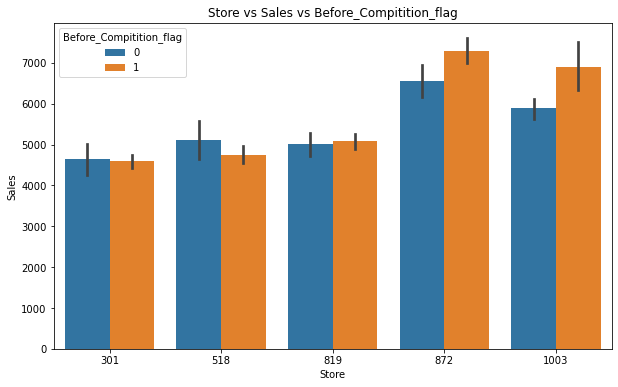

In [132]:
fig = plt.figure(figsize=(10, 6))
sns.barplot(y='Sales',x='Store',hue='Before_Compitition_flag',data=train_df_compitition.loc[train_df_compitition.Store.isin([819,872,1003,518,301]),:])
plt.title("Store vs Sales vs Before_Compitition_flag")
plt.show()

#### We can see for the store 301,518 when the compititor opened , the average sales value increased..
#### and for store 819,82,1003, when the compitior opened , the average sales value reduced. So we can not say  anything about the imact of compitition.

In [133]:
train_df_compitition[train_df_compitition.Store==301]

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
265572    301          5 2015-07-31   6665        629     1      1   
265573    301          4 2015-07-30   6307        577     1      1   
265574    301          3 2015-07-29   5598        577     1      1   
265575    301          2 2015-07-28   5381        507     1      1   
265576    301          1 2015-07-27   6211        582     1      1   
...       ...        ...        ...    ...        ...   ...    ...   
266509    301          6 2013-01-05   4065        464     1      0   
266510    301          5 2013-01-04   4605        576     1      0   
266511    301          4 2013-01-03   4503        546     1      0   
266512    301          3 2013-01-02   4973        603     1      0   
266513    301          2 2013-01-01      0          0     0      0   

       StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
265572            0              1         a          c               4510.0   
265573            0              1         a          c               4510.0   
265574            0              1         a          c               4510.0   
265575            0              1         a          c               4510.0   
265576            0              1         a          c               4510.0   
...             ...            ...       ...        ...                  ...   
266509            0              0         a          c               4510.0   
266510            0              1         a          c               4510.0   
266511            0              1         a          c               4510.0   
266512            0              1         a          c               4510.0   
266513            1              1         a          c               4510.0   

        Promo2SinceWeek  Promo2SinceYear PromoInterval CompetitionOpenSince  \
265572              0.0              0.0             0           2015-03-01   
265573              0.0              0.0             0           2015-03-01   
265574              0.0              0.0             0           2015-03-01   
265575              0.0              0.0             0           2015-03-01   
265576              0.0              0.0             0           2015-03-01   
...                 ...              ...           ...                  ...   
266509              0.0              0.0             0           2015-03-01   
266510              0.0              0.0             0           2015-03-01   
266511              0.0              0.0             0           2015-03-01   
266512              0.0              0.0             0           2015-03-01   
266513              0.0              0.0             0           2015-03-01   

        Promo2Actual  Before_Compitition_flag  
265572             0                        0  
265573             0                        0  
265574             0                        0  
265575             0                        0  
265576             0                        0  
...              ...                      ...  
266509             0                        1  
266510             0                        1  
266511             0                        1  
266512             0                        1  
266513             0                        1  

[942 rows x 18 columns]

In [134]:
train_df_compitition[(train_df_compitition.Store==301)& (train_df_compitition.Before_Compitition_flag==1)].Date.max()

Timestamp('2015-02-28 00:00:00')

In [135]:
train_df_compitition[(train_df_compitition.Store==301)& (train_df_compitition.Before_Compitition_flag==0)].Date.min()

Timestamp('2015-03-01 00:00:00')

In [136]:
train_df_compitition[train_df_compitition.Store==301].CompetitionDistance.unique()

array([4510.])

In [137]:
def plot_linegraph(store):
    fig = plt.figure(figsize=(20, 10))
    
    fig.add_subplot(2,1,1)
    y1=list(train_df_compitition[(train_df_compitition.Store==store) & (train_df_compitition.Before_Compitition_flag==0)].Sales)
    x1=list(train_df_compitition[(train_df_compitition.Store==store) & (train_df_compitition.Before_Compitition_flag==0)].Date)
    y2=list(train_df_compitition[(train_df_compitition.Store==store) & (train_df_compitition.Before_Compitition_flag==1)].Sales)
    x2=list(train_df_compitition[(train_df_compitition.Store==store) & (train_df_compitition.Before_Compitition_flag==1)].Date)
    plt.plot(x1,y1,label='After compititor opened',color='green')
    plt.plot(x2,y2,label='Before compititor opened',color='red')
    plt.title("Sales change when compititor opened for store={}".format(store))
    plt.legend()

    fig.add_subplot(2,1,2)
    last_day_before_compititor=train_df_compitition[(train_df_compitition.Store==store)& (train_df_compitition.Before_Compitition_flag==1)].Date.max()
    last_day_before_compititor_plus15=last_day_before_compititor+datetime.timedelta(days = 30)
    last_day_before_compititor_minus15=last_day_before_compititor-datetime.timedelta(days = 30)

    filtered_train_df_compitition = train_df_compitition[(train_df_compitition.Date>=last_day_before_compititor_minus15) &
                        (train_df_compitition.Date<=last_day_before_compititor_plus15)
                                                        & (train_df_compitition.Store==store)]
    print('For store={} compititor distance={} compititor open since={}'.format(store,filtered_train_df_compitition.CompetitionDistance.unique(),filtered_train_df_compitition.CompetitionOpenSince.unique()))
    y1=list(filtered_train_df_compitition[filtered_train_df_compitition.Before_Compitition_flag==0].Sales)
    x1=list(filtered_train_df_compitition[filtered_train_df_compitition.Before_Compitition_flag==0].Date)
    y2=list(filtered_train_df_compitition[filtered_train_df_compitition.Before_Compitition_flag==1].Sales)
    x2=list(filtered_train_df_compitition[filtered_train_df_compitition.Before_Compitition_flag==1].Date)
    plt.plot(x1,y1,label='After compititor opened',color='green')
    plt.plot(x2,y2,label='Before compititor opened',color='red')
    plt.title("Sales change when compititor opened for 60 days for store={}".format(store))
    plt.legend()


For store=301 compititor distance=[4510.] compititor open since=['2015-03-01T00:00:00.000000000']


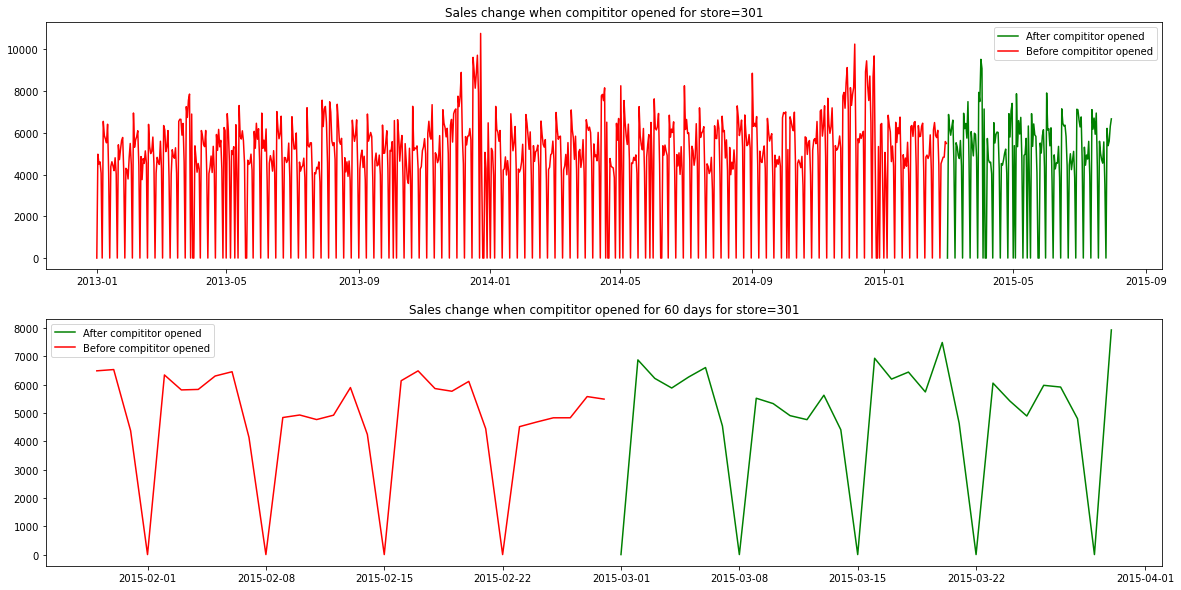

In [138]:
plot_linegraph(301)

#### The first graph shows for all day for the store 301 and the 2nd grapgh shows the grapgh befre and after 15 days of compititor opened.
#### Here we can see the comptitior is at 4510 meter away from the store .  After compititor opened, there is no impact in the sales of the store.

For store=1115 compititor distance=[] compititor open since=[]


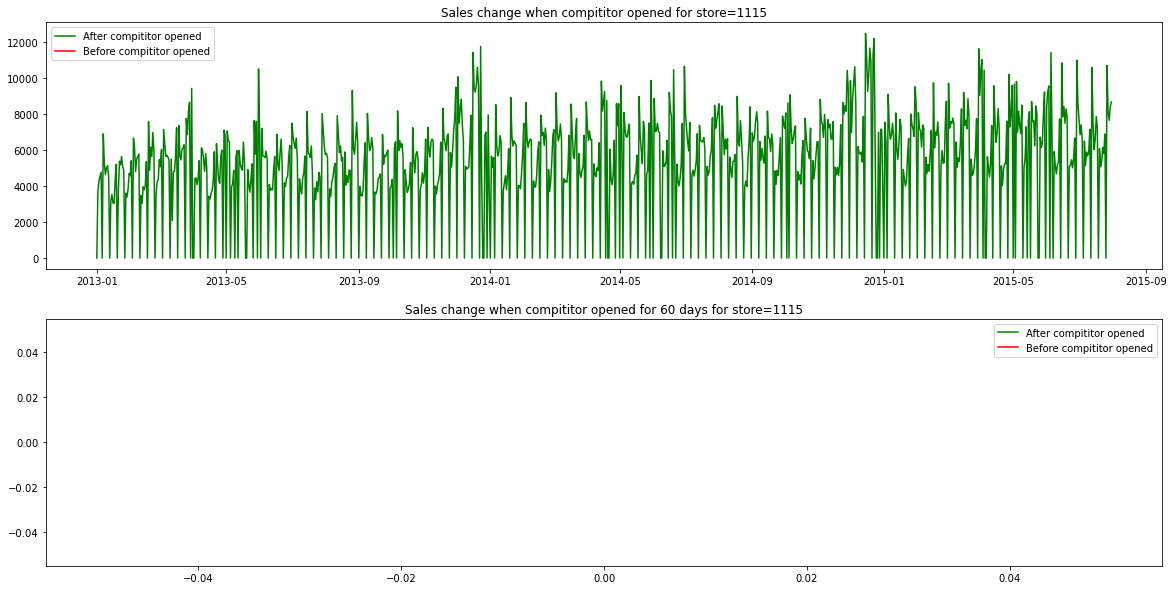

In [139]:
plot_linegraph(1115)

#### The first graph shows for all day for the store 1115 and the 2nd grapgh shows the grapgh before and after 15 days of compititor opened.
#### We can see there is no compitior for the store till date.

For store=872 compititor distance=[3860.] compititor open since=['2014-09-01T00:00:00.000000000']


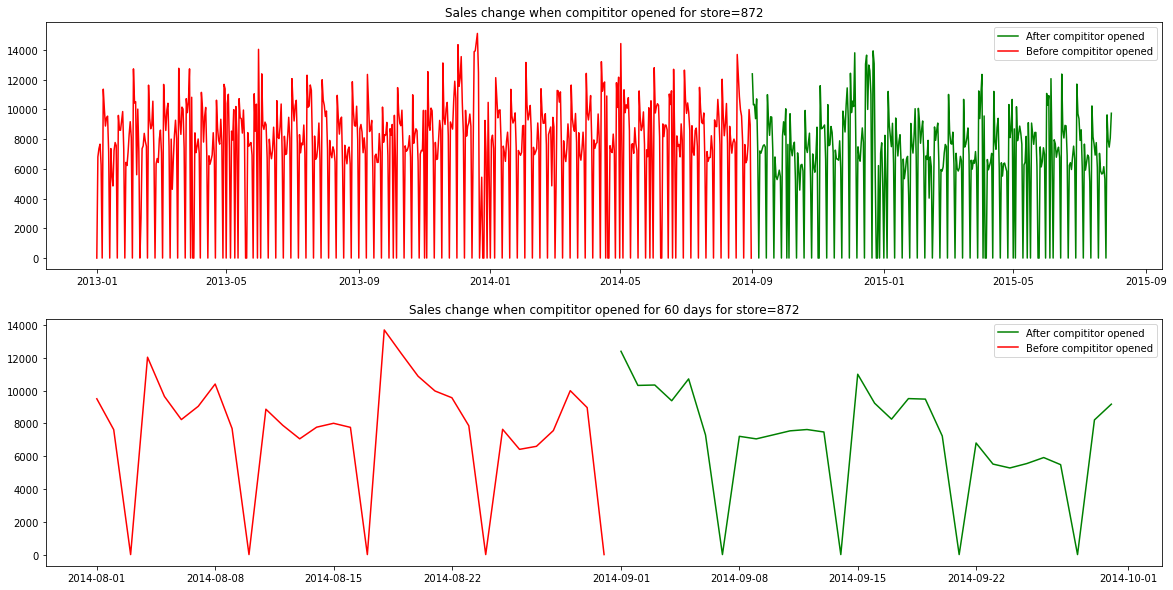

In [140]:
plot_linegraph(872)

#### The first graph shows for all day for the store 872 and the 2nd grapgh shows the grapgh befre and after 15 days of compititor opened.
#### Here we can see the comptitior is at 3860 meter away from the store . After compititor opened, we can see there is marginal reduction on sales.

For store=1003 compititor distance=[170.] compititor open since=['2013-07-01T00:00:00.000000000']


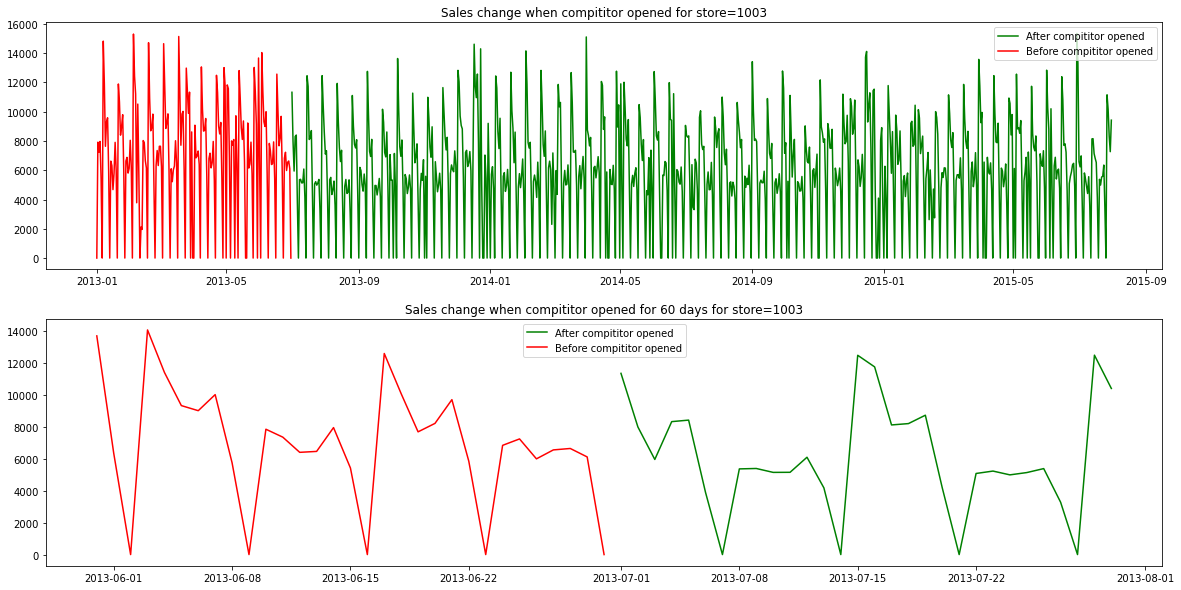

In [141]:
plot_linegraph(1003)

#### The first graph shows for all day for the store 1003 and the 2nd grapgh shows the grapgh befre and after 15 days of compititor opened.
#### Here we can see the comptitior is at 170 meter away from the store . After compititor opened, there is marginal reduction in the sales of the store.

For store=819 compititor distance=[720.] compititor open since=['2014-10-01T00:00:00.000000000']


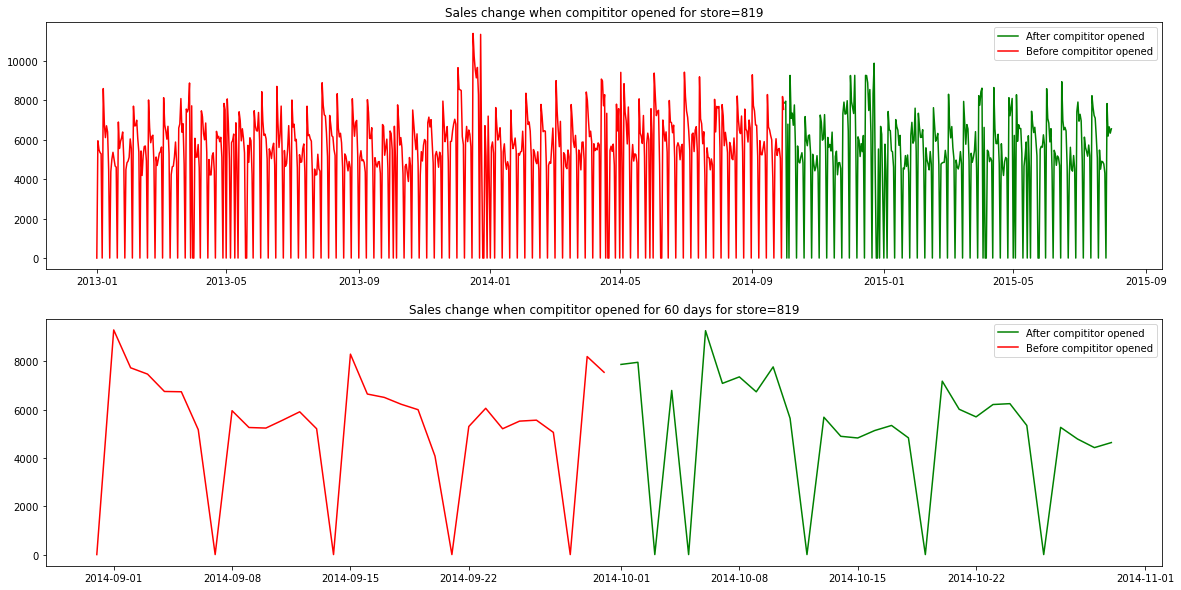

In [142]:
plot_linegraph(819)

#### The first graph shows for all day for the store 819 and the 2nd grapgh shows the grapgh befre and after 15 days of compititor opened.
#### Here we can see the comptitior is at 720 meter away from the store . After compititor opened, there is marginal reduction in the sales of the store.

For store=518 compititor distance=[3330.] compititor open since=['2015-03-01T00:00:00.000000000']


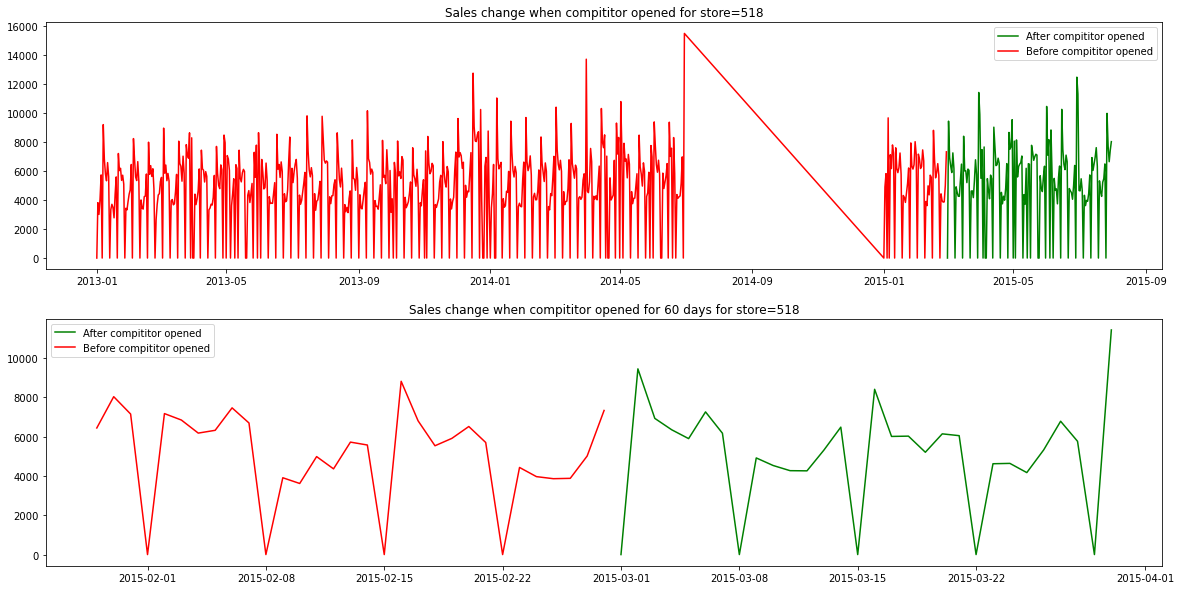

In [143]:
plot_linegraph(518)

#### The first graph shows for all day for the store 819 and the 2nd grapgh shows the grapgh befre and after 15 days of compititor opened.
#### Here we can see the comptitior is at 3330 meter away from the store . After compititor opened, there isno change  in the sales of the store.

#### From all these graphs we can see that when the compititor distance is high , the impact on sales is none. But when the compititor distance is less we cann ses the sales value is decresing marginally for few days.  

In [144]:
def calculate_distance(x):
    if x<500:
        return '<500'
    elif x<1000:
        return '500-1000'
    else:
        return '>1000'


In [145]:
train_df_compitition['CompititorDistanceCategory']=train_df_compitition['CompetitionDistance'].apply(lambda x:calculate_distance(x))
train_df_compitition.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      1          4 2015-07-30   5020        546     1      1            0   
2      1          3 2015-07-29   4782        523     1      1            0   
3      1          2 2015-07-28   5011        560     1      1            0   
4      1          1 2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  Promo2SinceWeek  \
0              1         c          a               1270.0              0.0   
1              1         c          a               1270.0              0.0   
2              1         c          a               1270.0              0.0   
3              1         c          a               1270.0              0.0   
4              1         c          a               1270.0              0.0   

   Promo2SinceYear PromoInterval CompetitionOpenSince  Promo2Actual  \
0              0.0             0           2008-09-01             0   
1              0.0             0           2008-09-01             0   
2              0.0             0           2008-09-01             0   
3              0.0             0           2008-09-01             0   
4              0.0             0           2008-09-01             0   

   Before_Compitition_flag CompititorDistanceCategory  
0                        0                      >1000  
1                        0                      >1000  
2                        0                      >1000  
3                        0                      >1000  
4                        0                      >1000

In [146]:
train_df_compitition_less_than500=train_df_compitition.loc[train_df_compitition.CompititorDistanceCategory=='<500',:]
train_df_compitition_grouped=pd.DataFrame(train_df_compitition_less_than500.groupby(['Store','Before_Compitition_flag']).Sales.mean())
train_df_compitition_grouped=train_df_compitition_grouped.reset_index()
train_df_compitition_grouped.Store.value_counts()==2

513      True
133      True
57       True
1086     True
958      True
        ...  
703     False
195     False
502     False
198     False
1028    False
Name: Store, Length: 221, dtype: bool

In [147]:
train_df_compitition_less_than1000=train_df_compitition.loc[train_df_compitition.CompititorDistanceCategory=='500-1000',:]
train_df_compitition_grouped=pd.DataFrame(train_df_compitition_less_than1000.groupby(['Store','Before_Compitition_flag']).Sales.mean())
train_df_compitition_grouped=train_df_compitition_grouped.reset_index()
train_df_compitition_grouped.Store.value_counts()==2

646      True
819      True
598      True
915      True
599      True
        ...  
760     False
1102    False
1100    False
331     False
1016    False
Name: Store, Length: 110, dtype: bool

In [148]:
train_df_compitition_more_than1000=train_df_compitition.loc[train_df_compitition.CompititorDistanceCategory=='>1000',:]
train_df_compitition_grouped=pd.DataFrame(train_df_compitition_more_than1000.groupby(['Store','Before_Compitition_flag']).Sales.mean())
train_df_compitition_grouped=train_df_compitition_grouped.reset_index()
train_df_compitition_grouped.Store.value_counts()==2

878      True
181      True
423      True
416      True
159      True
        ...  
366     False
367     False
368     False
370     False
1023    False
Name: Store, Length: 784, dtype: bool

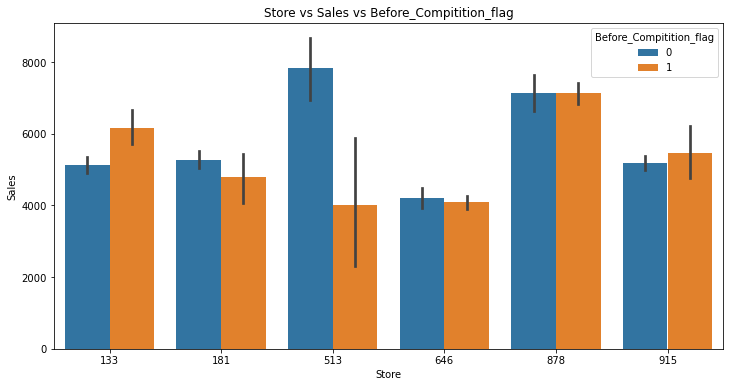

In [149]:


fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(y='Sales',x='Store',hue='Before_Compitition_flag',data=train_df_compitition.loc[train_df_compitition.Store.isin([513,133,646,915,878,181]),:],ax=ax1)

plt.title("Store vs Sales vs Before_Compitition_flag")
plt.show()

#### For 133,513 store, where the compititor distance is <500,we can see, the average selling price in one case decreasing after the copititor opened and for other it has increased.

#### For 646,915 store, where the compititor distance is 500-1000, the average selling price is increased in one case and in other case it is decreased.

#### For 181,878 store, where the compititor distance is 500-1000, the average selling price is increased in one case and in other case it is decreased.

#### Here we can say the in long term , there is no impact of comititor on sales. But when the compititor is near, for few days, it impacts the sell.

In [150]:
train_df_metadata=get_meta_data(train_df)
train_df_metadata

Datatype  Null_Percentage  Null count  \
Store                          int64             0.00           0   
DayOfWeek                      int64             0.00           0   
Date                  datetime64[ns]             0.00           0   
Sales                          int64             0.00           0   
Customers                      int64             0.00           0   
Open                           int64             0.00           0   
Promo                          int64             0.00           0   
StateHoliday                  object             0.00           0   
SchoolHoliday                  int64             0.00           0   
StoreType                     object             0.00           0   
Assortment                    object             0.00           0   
CompetitionDistance          float64             0.00           0   
Promo2SinceWeek              float64             0.00           0   
Promo2SinceYear              float64             0.00           0   
PromoInterval                 object             0.00           0   
CompetitionOpenSince  datetime64[ns]            31.69      315969   
Promo2Actual                   int64             0.00           0   

                      No_Of_Unique_Values  
Store                                1115  
DayOfWeek                               7  
Date                                  942  
Sales                               14694  
Customers                            2206  
Open                                    2  
Promo                                   2  
StateHoliday                            2  
SchoolHoliday                           2  
StoreType                               4  
Assortment                              3  
CompetitionDistance                   644  
Promo2SinceWeek                        25  
Promo2SinceYear                         8  
PromoInterval                           4  
CompetitionOpenSince                  171  
Promo2Actual                            2

In [151]:
train_df.shape

(996974, 17)

#### We can see missing values in CompetitionOpenSince. Let's try to impute .

In [152]:
train_df.loc[train_df.CompetitionDistance==0,'CompetitionOpenSince']

256349   NaT
256350   NaT
256351   NaT
256352   NaT
256353   NaT
          ..
766870   NaT
766871   NaT
766872   NaT
766873   NaT
766874   NaT
Name: CompetitionOpenSince, Length: 2635, dtype: datetime64[ns]

In [153]:
train_df.loc[train_df.CompetitionDistance==0,'CompetitionOpenSince'].unique()

array(['NaT'], dtype='datetime64[ns]')

#### We have many records where CompetitionDistance is 0, their corresponding CompetitionOpenSince is NaT. We can say there is no compititor for these stores. Let's put some future date(a date after 10 year) there.

In [154]:
train_df.Date.max()

Timestamp('2015-07-31 00:00:00')

In [155]:
train_df.Date.max()+datetime.timedelta(days = 3650)

Timestamp('2025-07-28 00:00:00')

In [156]:
train_df.loc[train_df.CompetitionDistance==0,'CompetitionOpenSince']=train_df.Date.max()+datetime.timedelta(days = 3650)

In [157]:
train_df.loc[train_df.CompetitionDistance==0,'CompetitionOpenSince'].unique()

array(['2025-07-28T00:00:00.000000000'], dtype='datetime64[ns]')

In [158]:
train_df.loc[(train_df.CompetitionDistance!=0) & (train_df.CompetitionOpenSince.isnull()),'CompetitionOpenSince']

10333    NaT
10334    NaT
10335    NaT
10336    NaT
10337    NaT
          ..
996963   NaT
996964   NaT
996965   NaT
996966   NaT
996967   NaT
Name: CompetitionOpenSince, Length: 313334, dtype: datetime64[ns]

#### There are many records where CompetitionDistance is not 0, but CompetitionOpenSince is missing, which means the store has compititor, but when the compititor opened, that data is missing. Let's impute with past date(10 years back)

In [159]:
train_df.Date.min()

Timestamp('2013-01-01 00:00:00')

In [160]:
train_df.Date.min()-datetime.timedelta(days = 3650)

Timestamp('2003-01-04 00:00:00')

In [161]:
train_df.loc[(train_df.CompetitionDistance!=0) & (train_df.CompetitionOpenSince.isnull()),'CompetitionOpenSince']=train_df.Date.min()-datetime.timedelta(days = 3650)

In [162]:
train_df_metadata=get_meta_data(train_df)
train_df_metadata

Datatype  Null_Percentage  Null count  \
Store                          int64              0.0           0   
DayOfWeek                      int64              0.0           0   
Date                  datetime64[ns]              0.0           0   
Sales                          int64              0.0           0   
Customers                      int64              0.0           0   
Open                           int64              0.0           0   
Promo                          int64              0.0           0   
StateHoliday                  object              0.0           0   
SchoolHoliday                  int64              0.0           0   
StoreType                     object              0.0           0   
Assortment                    object              0.0           0   
CompetitionDistance          float64              0.0           0   
Promo2SinceWeek              float64              0.0           0   
Promo2SinceYear              float64              0.0           0   
PromoInterval                 object              0.0           0   
CompetitionOpenSince  datetime64[ns]              0.0           0   
Promo2Actual                   int64              0.0           0   

                      No_Of_Unique_Values  
Store                                1115  
DayOfWeek                               7  
Date                                  942  
Sales                               14694  
Customers                            2206  
Open                                    2  
Promo                                   2  
StateHoliday                            2  
SchoolHoliday                           2  
StoreType                               4  
Assortment                              3  
CompetitionDistance                   644  
Promo2SinceWeek                        25  
Promo2SinceYear                         8  
PromoInterval                           4  
CompetitionOpenSince                  173  
Promo2Actual                            2

In [163]:
train_df.Date-train_df.CompetitionOpenSince

0        2524 days
1        2523 days
2        2522 days
3        2521 days
4        2520 days
            ...   
996969   5563 days
996970   5504 days
996971   5205 days
996972   5198 days
996973    532 days
Length: 996974, dtype: timedelta64[ns]

In [164]:
train_df['CompetitionOpenSinceDays']=train_df.Date-train_df.CompetitionOpenSince
train_df['CompetitionOpenSinceDays']=train_df['CompetitionOpenSinceDays'].dt.days

In [165]:
train_df[train_df['CompetitionOpenSinceDays']<0].head(2)

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
3879      5          2 2015-03-31   7692        659     1      1            0   
3880      5          1 2015-03-30   8847        770     1      1            0   

      SchoolHoliday StoreType Assortment  CompetitionDistance  \
3879              0         a          a              29910.0   
3880              0         a          a              29910.0   

      Promo2SinceWeek  Promo2SinceYear PromoInterval CompetitionOpenSince  \
3879              0.0              0.0             0           2015-04-01   
3880              0.0              0.0             0           2015-04-01   

      Promo2Actual  CompetitionOpenSinceDays  
3879             0                        -1  
3880             0                        -2

In [166]:
train_df[train_df['CompetitionOpenSinceDays']>0].head(2)

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      1          4 2015-07-30   5020        546     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  Promo2SinceWeek  \
0              1         c          a               1270.0              0.0   
1              1         c          a               1270.0              0.0   

   Promo2SinceYear PromoInterval CompetitionOpenSince  Promo2Actual  \
0              0.0             0           2008-09-01             0   
1              0.0             0           2008-09-01             0   

   CompetitionOpenSinceDays  
0                      2524  
1                      2523

In [167]:
train_df[train_df['CompetitionOpenSinceDays']==0].head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
3878       5          3 2015-04-01   7720        773     1      1   
5306       6          7 2013-12-01      0          0     0      0   
6486       7          1 2013-04-01      0          0     0      0   
6880       8          3 2014-10-01   6826        842     1      1   
12549     14          6 2014-03-01   4170        458     1      0   

      StateHoliday  SchoolHoliday StoreType Assortment  CompetitionDistance  \
3878             0              0         a          a              29910.0   
5306             0              0         a          a                310.0   
6486             1              1         a          c              24000.0   
6880             0              0         a          a               7520.0   
12549            0              0         a          a               1300.0   

       Promo2SinceWeek  Promo2SinceYear    PromoInterval CompetitionOpenSince  \
3878               0.0              0.0                0           2015-04-01   
5306               0.0              0.0                0           2013-12-01   
6486               0.0              0.0                0           2013-04-01   
6880               0.0              0.0                0           2014-10-01   
12549             40.0           2011.0  Jan,Apr,Jul,Oct           2014-03-01   

       Promo2Actual  CompetitionOpenSinceDays  
3878              0                         0  
5306              0                         0  
6486              0                         0  
6880              0                         0  
12549             0                         0

#### +ve value in CompetitionOpenSinceDays : compititor opened before the date(compititor exist). 
#### -ve value in CompetitionOpenSinceDays : compititor opened after the date(compititor does not exist), Mark compititor distance as 0.
#### 0 value in CompetitionOpenSinceDays : compititor opened on same day of sale. 1st day of compititor. Accordingly update CompetitionOpenSinceDays

#### Now we can drop CompetitionOpenSince

In [168]:
train_df.loc[train_df.CompetitionOpenSinceDays>=0,'CompetitionOpenSinceDays']=train_df.CompetitionOpenSinceDays+1

In [169]:
train_df.loc[train_df.CompetitionOpenSinceDays<0,'CompetitionDistance']=0
train_df.loc[train_df.CompetitionOpenSinceDays<0,'CompetitionOpenSinceDays']=0

In [170]:
train_df[train_df['CompetitionOpenSinceDays']==0].head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
3879      5          2 2015-03-31   7692        659     1      1            0   
3880      5          1 2015-03-30   8847        770     1      1            0   
3881      5          7 2015-03-29      0          0     0      0            0   
3882      5          6 2015-03-28   2038        219     1      0            0   
3883      5          5 2015-03-27   4181        499     1      0            0   

      SchoolHoliday StoreType Assortment  CompetitionDistance  \
3879              0         a          a                  0.0   
3880              0         a          a                  0.0   
3881              0         a          a                  0.0   
3882              0         a          a                  0.0   
3883              0         a          a                  0.0   

      Promo2SinceWeek  Promo2SinceYear PromoInterval CompetitionOpenSince  \
3879              0.0              0.0             0           2015-04-01   
3880              0.0              0.0             0           2015-04-01   
3881              0.0              0.0             0           2015-04-01   
3882              0.0              0.0             0           2015-04-01   
3883              0.0              0.0             0           2015-04-01   

      Promo2Actual  CompetitionOpenSinceDays  
3879             0                         0  
3880             0                         0  
3881             0                         0  
3882             0                         0  
3883             0                         0

In [171]:
train_df[train_df['CompetitionOpenSinceDays']!=0].head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      1          4 2015-07-30   5020        546     1      1            0   
2      1          3 2015-07-29   4782        523     1      1            0   
3      1          2 2015-07-28   5011        560     1      1            0   
4      1          1 2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  Promo2SinceWeek  \
0              1         c          a               1270.0              0.0   
1              1         c          a               1270.0              0.0   
2              1         c          a               1270.0              0.0   
3              1         c          a               1270.0              0.0   
4              1         c          a               1270.0              0.0   

   Promo2SinceYear PromoInterval CompetitionOpenSince  Promo2Actual  \
0              0.0             0           2008-09-01             0   
1              0.0             0           2008-09-01             0   
2              0.0             0           2008-09-01             0   
3              0.0             0           2008-09-01             0   
4              0.0             0           2008-09-01             0   

   CompetitionOpenSinceDays  
0                      2525  
1                      2524  
2                      2523  
3                      2522  
4                      2521

In [172]:
train_df.drop('CompetitionOpenSince',inplace=True,axis=1)

In [173]:
train_df_metadata=get_meta_data(train_df)
train_df_metadata

Datatype  Null_Percentage  Null count  \
Store                              int64              0.0           0   
DayOfWeek                          int64              0.0           0   
Date                      datetime64[ns]              0.0           0   
Sales                              int64              0.0           0   
Customers                          int64              0.0           0   
Open                               int64              0.0           0   
Promo                              int64              0.0           0   
StateHoliday                      object              0.0           0   
SchoolHoliday                      int64              0.0           0   
StoreType                         object              0.0           0   
Assortment                        object              0.0           0   
CompetitionDistance              float64              0.0           0   
Promo2SinceWeek                  float64              0.0           0   
Promo2SinceYear                  float64              0.0           0   
PromoInterval                     object              0.0           0   
Promo2Actual                       int64              0.0           0   
CompetitionOpenSinceDays           int64              0.0           0   

                          No_Of_Unique_Values  
Store                                    1115  
DayOfWeek                                   7  
Date                                      942  
Sales                                   14694  
Customers                                2206  
Open                                        2  
Promo                                       2  
StateHoliday                                2  
SchoolHoliday                               2  
StoreType                                   4  
Assortment                                  3  
CompetitionDistance                       642  
Promo2SinceWeek                            25  
Promo2SinceYear                             8  
PromoInterval                               4  
Promo2Actual                                2  
CompetitionOpenSinceDays                10217

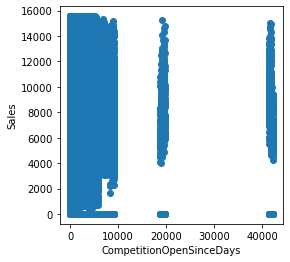

In [174]:
plt.figure(figsize=(4, 4))
plt.scatter(y=train_df['Sales'],x=train_df['CompetitionOpenSinceDays'])
plt.xlabel('CompetitionOpenSinceDays')
plt.ylabel('Sales')
plt.show()

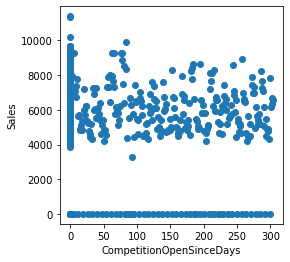

In [175]:
train_df_819=train_df.loc[train_df.Store==819,:]
plt.figure(figsize=(4, 4))
plt.scatter(y=train_df_819['Sales'],x=train_df_819['CompetitionOpenSinceDays'])
plt.xlabel('CompetitionOpenSinceDays')
plt.ylabel('Sales')
plt.show()

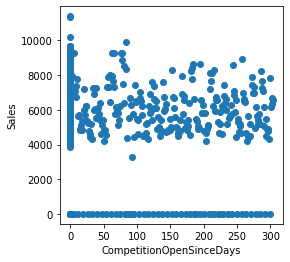

In [176]:
train_df_301=train_df.loc[train_df.Store==301,:]
plt.figure(figsize=(4, 4))
plt.scatter(y=train_df_819['Sales'],x=train_df_819['CompetitionOpenSinceDays'])
plt.xlabel('CompetitionOpenSinceDays')
plt.ylabel('Sales')
plt.show()

#### From the above 3 graph shows the trend of changes in sales in 3 cases for all store and store-819,301: when compititor exists, when compititor does not exist, on the opening day of compititor. We do not see any pattern here. 

In [177]:
train_df.PromoInterval.unique()

array([0, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

#### Promo2Actual is calculated using Promo2SinceWeek,Promo2SinceYear,PromoInterval values. We do not need these three values for further analysis. We can drop these attributes.

In [178]:
train_df.drop(['Promo2SinceWeek','Promo2SinceYear','PromoInterval'],inplace=True,axis=1)

In [179]:
train_df_metadata=get_meta_data(train_df)
train_df_metadata

Datatype  Null_Percentage  Null count  \
Store                              int64              0.0           0   
DayOfWeek                          int64              0.0           0   
Date                      datetime64[ns]              0.0           0   
Sales                              int64              0.0           0   
Customers                          int64              0.0           0   
Open                               int64              0.0           0   
Promo                              int64              0.0           0   
StateHoliday                      object              0.0           0   
SchoolHoliday                      int64              0.0           0   
StoreType                         object              0.0           0   
Assortment                        object              0.0           0   
CompetitionDistance              float64              0.0           0   
Promo2Actual                       int64              0.0           0   
CompetitionOpenSinceDays           int64              0.0           0   

                          No_Of_Unique_Values  
Store                                    1115  
DayOfWeek                                   7  
Date                                      942  
Sales                                   14694  
Customers                                2206  
Open                                        2  
Promo                                       2  
StateHoliday                                2  
SchoolHoliday                               2  
StoreType                                   4  
Assortment                                  3  
CompetitionDistance                       642  
Promo2Actual                                2  
CompetitionOpenSinceDays                10217

#### Let's remove unnecessary columns : Open,StoreType,Assortment

In [180]:
train_df.drop(['Open','StoreType','Assortment','StateHoliday','Promo2Actual'],inplace=True,axis=1)

In [181]:
train_df_metadata=get_meta_data(train_df)
train_df_metadata

Datatype  Null_Percentage  Null count  \
Store                              int64              0.0           0   
DayOfWeek                          int64              0.0           0   
Date                      datetime64[ns]              0.0           0   
Sales                              int64              0.0           0   
Customers                          int64              0.0           0   
Promo                              int64              0.0           0   
SchoolHoliday                      int64              0.0           0   
CompetitionDistance              float64              0.0           0   
CompetitionOpenSinceDays           int64              0.0           0   

                          No_Of_Unique_Values  
Store                                    1115  
DayOfWeek                                   7  
Date                                      942  
Sales                                   14694  
Customers                                2206  
Promo                                       2  
SchoolHoliday                               2  
CompetitionDistance                       642  
CompetitionOpenSinceDays                10217

# Data Preparation

## Dummy Creation

In [182]:
dummies=pd.get_dummies(train_df['DayOfWeek'],drop_first=True,prefix='DayOfWeek')
train_df=pd.concat([train_df,dummies],axis=1)

In [183]:
train_df.head()

Store  DayOfWeek       Date  Sales  Customers  Promo  SchoolHoliday  \
0      1          5 2015-07-31   5263        555      1              1   
1      1          4 2015-07-30   5020        546      1              1   
2      1          3 2015-07-29   4782        523      1              1   
3      1          2 2015-07-28   5011        560      1              1   
4      1          1 2015-07-27   6102        612      1              1   

   CompetitionDistance  CompetitionOpenSinceDays  DayOfWeek_2  DayOfWeek_3  \
0               1270.0                      2525            0            0   
1               1270.0                      2524            0            0   
2               1270.0                      2523            0            1   
3               1270.0                      2522            1            0   
4               1270.0                      2521            0            0   

   DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
0            0            1            0            0  
1            1            0            0            0  
2            0            0            0            0  
3            0            0            0            0  
4            0            0            0            0

In [184]:
train_df.drop('DayOfWeek',axis=1,inplace=True)
train_df.head()

Store       Date  Sales  Customers  Promo  SchoolHoliday  \
0      1 2015-07-31   5263        555      1              1   
1      1 2015-07-30   5020        546      1              1   
2      1 2015-07-29   4782        523      1              1   
3      1 2015-07-28   5011        560      1              1   
4      1 2015-07-27   6102        612      1              1   

   CompetitionDistance  CompetitionOpenSinceDays  DayOfWeek_2  DayOfWeek_3  \
0               1270.0                      2525            0            0   
1               1270.0                      2524            0            0   
2               1270.0                      2523            0            1   
3               1270.0                      2522            1            0   
4               1270.0                      2521            0            0   

   DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
0            0            1            0            0  
1            1            0            0            0  
2            0            0            0            0  
3            0            0            0            0  
4            0            0            0            0

In [185]:
train_df_metadata=get_meta_data(train_df)
train_df_metadata

Datatype  Null_Percentage  Null count  \
Store                              int64              0.0           0   
Date                      datetime64[ns]              0.0           0   
Sales                              int64              0.0           0   
Customers                          int64              0.0           0   
Promo                              int64              0.0           0   
SchoolHoliday                      int64              0.0           0   
CompetitionDistance              float64              0.0           0   
CompetitionOpenSinceDays           int64              0.0           0   
DayOfWeek_2                        uint8              0.0           0   
DayOfWeek_3                        uint8              0.0           0   
DayOfWeek_4                        uint8              0.0           0   
DayOfWeek_5                        uint8              0.0           0   
DayOfWeek_6                        uint8              0.0           0   
DayOfWeek_7                        uint8              0.0           0   

                          No_Of_Unique_Values  
Store                                    1115  
Date                                      942  
Sales                                   14694  
Customers                                2206  
Promo                                       2  
SchoolHoliday                               2  
CompetitionDistance                       642  
CompetitionOpenSinceDays                10217  
DayOfWeek_2                                 2  
DayOfWeek_3                                 2  
DayOfWeek_4                                 2  
DayOfWeek_5                                 2  
DayOfWeek_6                                 2  
DayOfWeek_7                                 2

#### Now we have cleaned data. We can move forward for modelling .

# Time Series analysis

#### Here we have two time series : Customer and Sales. If Sales increases , customer will increase and vice versa. Hence Customer is a endogenous variable. But the same is not for other variables.
##### Let's visualize the data first for both sales .

In [186]:
train_df=train_df.sort_values(by='Date')
train_df.head()

Store       Date  Sales  Customers  Promo  SchoolHoliday  \
109925    121 2013-01-01      0          0      0              1   
442319    504 2013-01-01      0          0      0              1   
804419    922 2013-01-01      0          0      0              1   
216966    243 2013-01-01      0          0      0              1   
20139      22 2013-01-01      0          0      0              1   

        CompetitionDistance  CompetitionOpenSinceDays  DayOfWeek_2  \
109925               3570.0                      1158            1   
442319                820.0                      3651            1   
804419               2110.0                      2499            1   
216966                310.0                      3651            1   
20139                1040.0                      3651            1   

        DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
109925            0            0            0            0            0  
442319            0            0            0            0            0  
804419            0            0            0            0            0  
216966            0            0            0            0            0  
20139             0            0            0            0            0

In [187]:
train_df=train_df.set_index('Date')
train_df.head()

Store  Sales  Customers  Promo  SchoolHoliday  \
Date                                                        
2013-01-01    121      0          0      0              1   
2013-01-01    504      0          0      0              1   
2013-01-01    922      0          0      0              1   
2013-01-01    243      0          0      0              1   
2013-01-01     22      0          0      0              1   

            CompetitionDistance  CompetitionOpenSinceDays  DayOfWeek_2  \
Date                                                                     
2013-01-01               3570.0                      1158            1   
2013-01-01                820.0                      3651            1   
2013-01-01               2110.0                      2499            1   
2013-01-01                310.0                      3651            1   
2013-01-01               1040.0                      3651            1   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2013-01-01            0            0            0            0            0  
2013-01-01            0            0            0            0            0  
2013-01-01            0            0            0            0            0  
2013-01-01            0            0            0            0            0  
2013-01-01            0            0            0            0            0

In [188]:
train_df_all=train_df.groupby('Date').agg({'Sales': 'mean',
                                           'Customers':'mean', 
                                           'Promo': 'sum',
                                           'SchoolHoliday':'sum',
                                           'DayOfWeek_2':'mean',
                                           'DayOfWeek_3':'mean',
                                           'DayOfWeek_4':'mean',
                                           'DayOfWeek_5':'mean',
                                           'DayOfWeek_6':'mean',
                                           'DayOfWeek_7':'mean'})
train_df_all.head()

Sales   Customers  Promo  SchoolHoliday  DayOfWeek_2  \
Date                                                                     
2013-01-01    62.232914   12.804856      0           1112            1   
2013-01-02  6061.072926  720.625342      0           1097            0   
2013-01-03  5586.966516  666.504072      0           1030            0   
2013-01-04  5852.084239  683.781703      0           1029            0   
2013-01-05  5195.525886  594.768392      0            111            0   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2013-01-01            0            0            0            0            0  
2013-01-02            1            0            0            0            0  
2013-01-03            0            1            0            0            0  
2013-01-04            0            0            1            0            0  
2013-01-05            0            0            0            1            0

In [189]:
def timeseries_visualization(series,c):
    fig = plt.figure(figsize=(20, 3))
    series.plot()
    plt.xlabel('Date')
    plt.ylabel(c)
    plt.title('For {}'.format(c))
    plt.show()

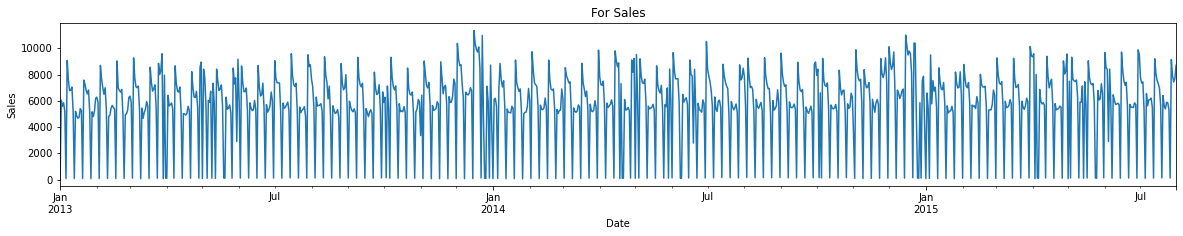

In [190]:

timeseries_visualization(train_df_all['Sales'],'Sales')

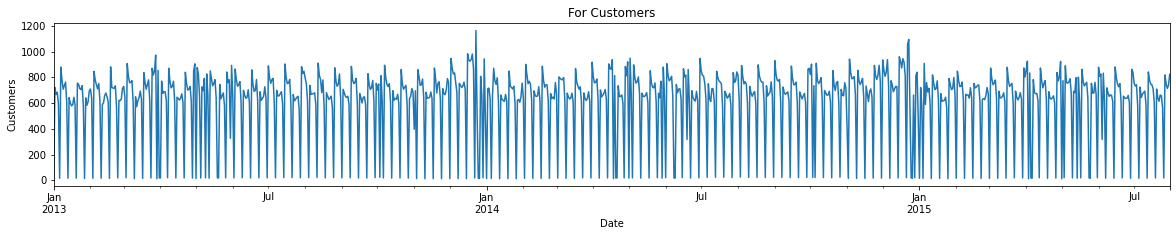

In [191]:
timeseries_visualization(train_df_all['Customers'],'Customers')

#### It is clear that both of the series is addititive series. Following grapgh shows the seasonal_decomposition of the series into Trend, Seasonal,Residual,

In [192]:
def plot_seasonal_decomposition(series,c,model):
    rcParams['figure.figsize'] = 18, 14
    decomposition = sm.tsa.seasonal_decompose(series, model=model) # additive seasonal index
    fig = decomposition.plot()
    plt.show()
    print('Mean Residual for {}={}'.format(c,decomposition.resid.mean()))


In [193]:
def plot_seasonal_decomposition_period(series,c,model):
    rcParams['figure.figsize'] = 18, 14
    decomposition = sm.tsa.seasonal_decompose(series, model=model, extrapolate_trend='freq', freq=12) # additive seasonal index
    fig = decomposition.plot()
    plt.show()
    print('Mean Residual for {}={}'.format(c,decomposition.resid.mean()))


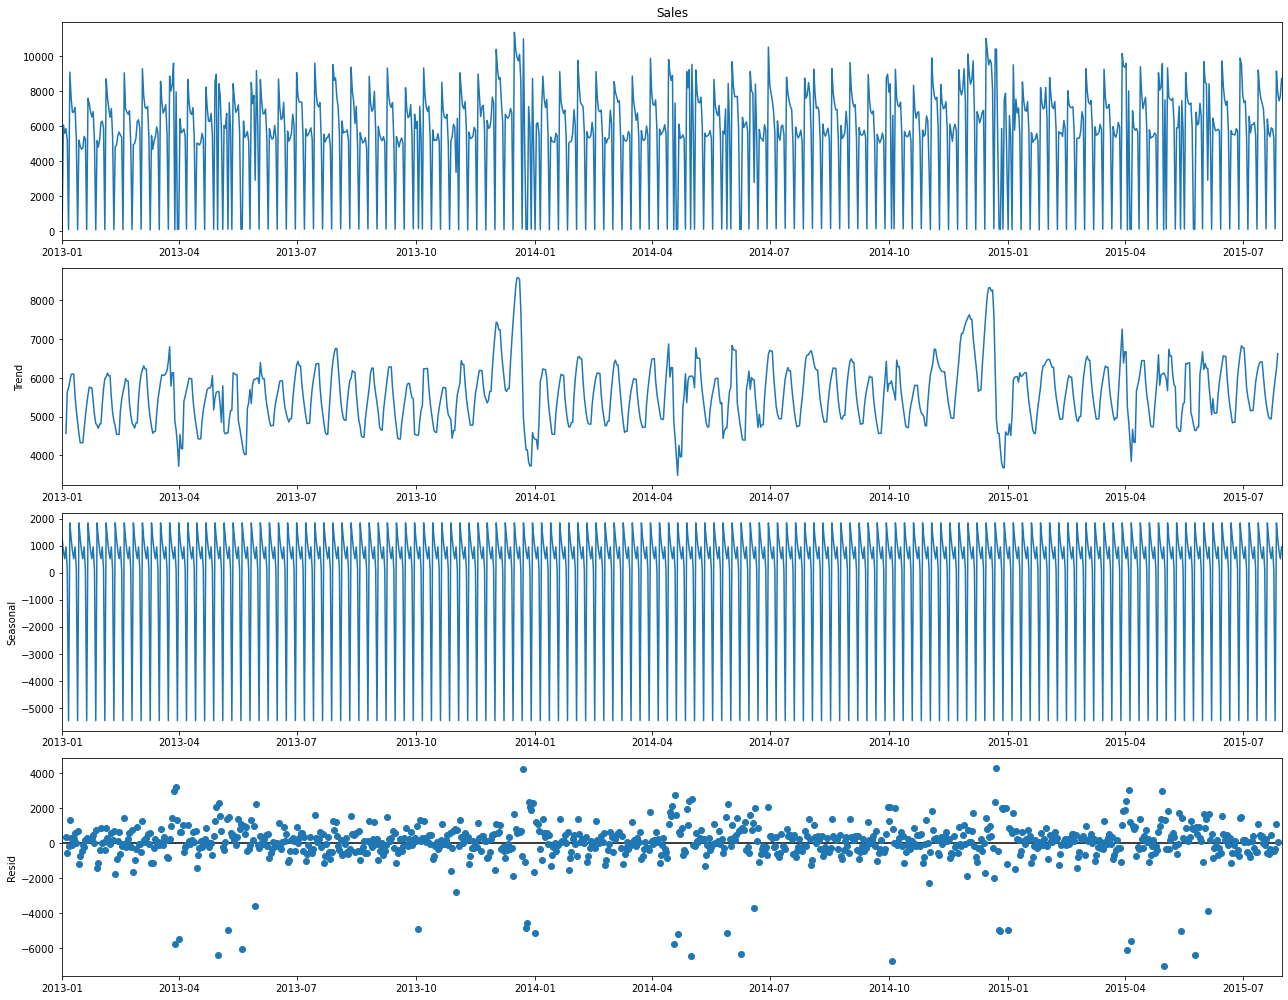

Mean Residual for Sales=0.6179371943641403


In [194]:
plot_seasonal_decomposition(train_df_all['Sales'],'Sales','additive')

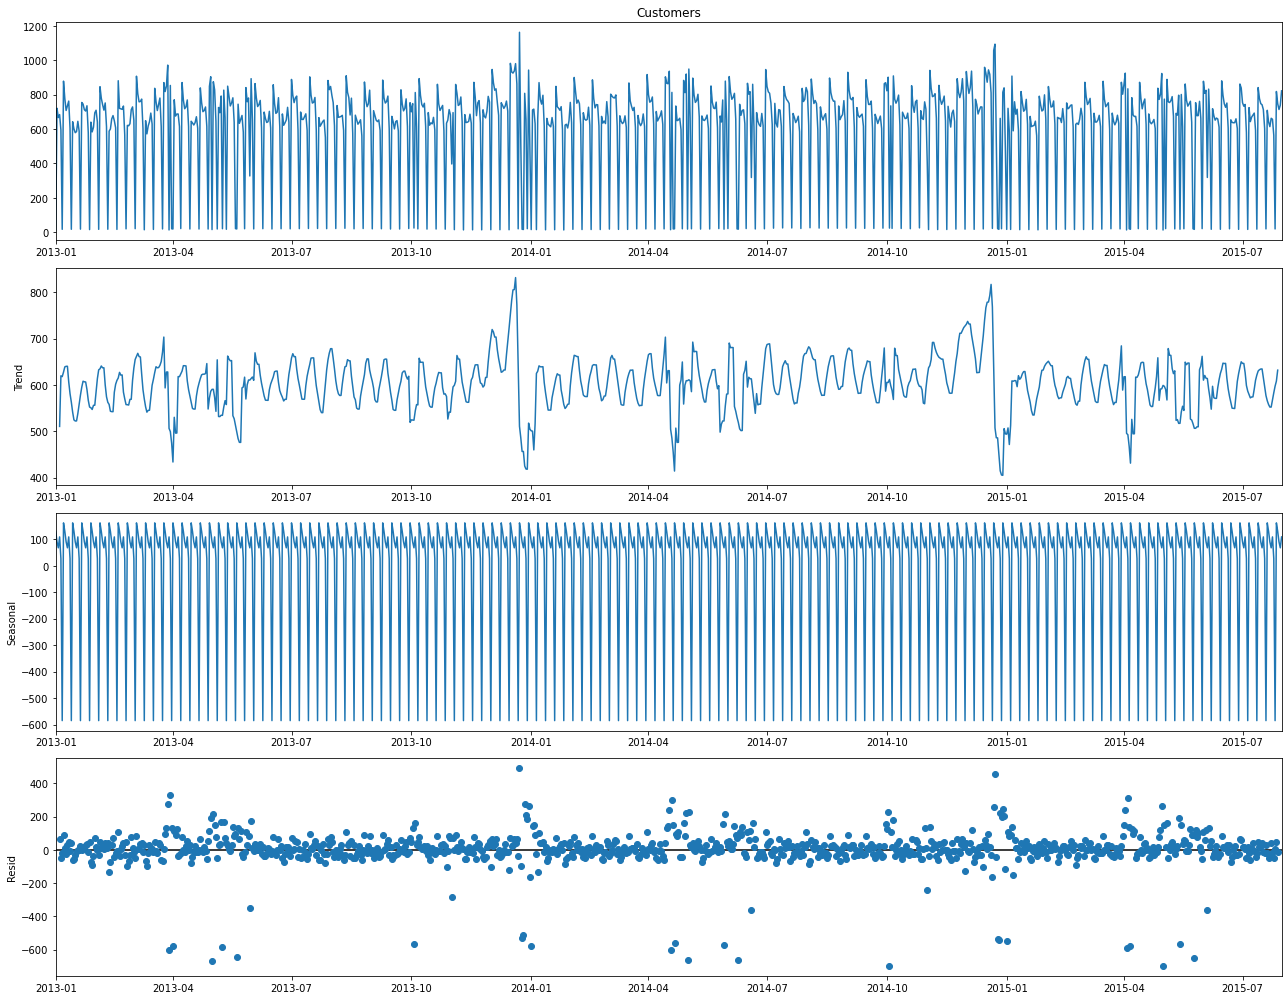

Mean Residual for Customers=0.05554069684762129


In [195]:
plot_seasonal_decomposition(train_df_all['Customers'],'Customers','additive')

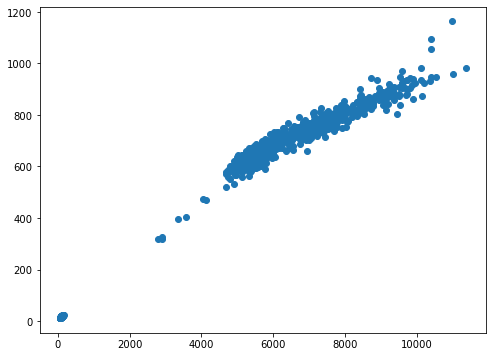

In [196]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(train_df_all['Sales'],train_df_all['Customers'])
plt.show()

#### Here we can see a strong relation between Sales and Customers.

### Causality Testing

In [197]:
causality_sales=grangercausalitytests(train_df_all[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=189.1269, p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=189.7317, p=0.0000  , df=1
likelihood ratio test: chi2=172.8402, p=0.0000  , df=1
parameter F test:         F=189.1269, p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=105.6156, p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=212.3607, p=0.0000  , df=2
likelihood ratio test: chi2=191.4668, p=0.0000  , df=2
parameter F test:         F=105.6156, p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=78.1319 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=236.1562, p=0.0000  , df=3
likelihood ratio test: chi2=210.6561, p=0.0000  , df=3
parameter F test:         F=78.1319 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=67.0694 , p=0.0000  

In [198]:
causality_customers=grangercausalitytests(train_df_all[['Customers','Sales']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=80.7210 , p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=80.9792 , p=0.0000  , df=1
likelihood ratio test: chi2=77.6826 , p=0.0000  , df=1
parameter F test:         F=80.7210 , p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=41.1578 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=82.7559 , p=0.0000  , df=2
likelihood ratio test: chi2=79.3137 , p=0.0000  , df=2
parameter F test:         F=41.1578 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=33.7079 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=101.8831, p=0.0000  , df=3
likelihood ratio test: chi2=96.7257 , p=0.0000  , df=3
parameter F test:         F=33.7079 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=28.3541 , p=0.0000  

#### Here all the tests signify causality at significance level 0.05. All indicates that causality exists between sales and customers.

### Testing for stationary

In [199]:
def stationary_test(df):
    for c in df.columns:
        print('For ',c)
        print('*'*100)
        r=adfuller(df[c],autolag='AIC')
        print('ADF Statistic=',r[0])
        print('P value=',r[1])
        output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
        p_value = output['pvalue']
        if p_value <= 0.05:
            print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" => Series is Stationary.")
        else:
            print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
            print(f" => Series is Non-Stationary.")  

In [200]:
stationary_test(train_df_all[['Sales','Customers']])

For  Sales
****************************************************************************************************
ADF Statistic= -5.803727432451619
P value= 4.567596468381704e-07
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
For  Customers
****************************************************************************************************
ADF Statistic= -6.086544674347373
P value= 1.0610339178933044e-07
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


#### 1%:-3.44,5%:-2.86,10%:-2.56 . If we compare the ADF statistic value, for both Sales and Customers, the value is less than the value of 1%. Which means we have to reject null hypothesis i.e. Series is not stationary.
#### Here we can see the P value is less than -.05 for both Sales and Customers, which implys both sereies are stationary. As our original data is stationary the degree of integration is 0 (I(0)).

#### Here we do not have any othe time series except Sales and Customers. Other variables are not time series components . They can be considered as exogenous variables.

### Autocoorelation and degree of integration

In [201]:
def plot_acf_pacf(series,c):
    rcParams['figure.figsize'] = 20, 3
    fig.add_subplot(2,1,1)
    plot_acf(series, lags = 75)
    plt.title('ACF for {}'.format(c)) 
    fig.add_subplot(2,1,2)
    plot_pacf(series, lags = 75)
    plt.title('PACF for {}'.format(c)) 
    plt.show()

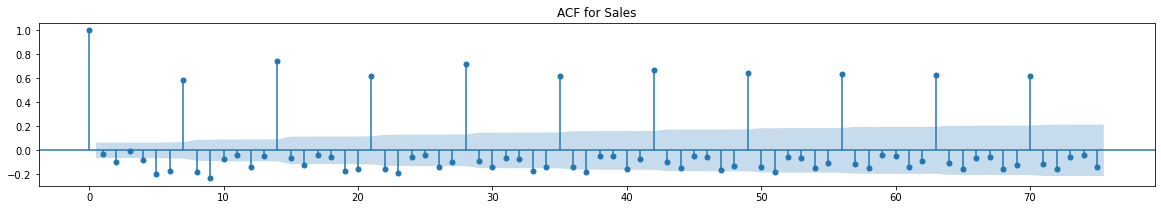

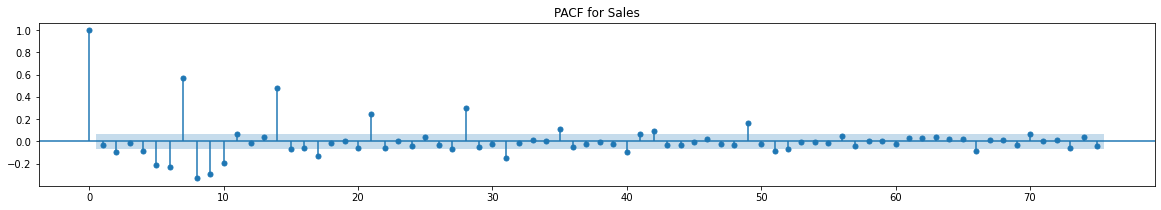

In [202]:
plot_acf_pacf(train_df_all['Sales'],'Sales')

#### From ACF plot , we can find q=0 as we do not have a point after  which autocorrelation dies down.
#### From PACF plot , we can choose p=49,  as the highest lag where partial autocorrelation is significantly high. But executionof the model will be very high and taking 49 component while modeling, then there is very high chance of overfitting because of high complexity. Hence let's select 7 as p which is the last highest value.

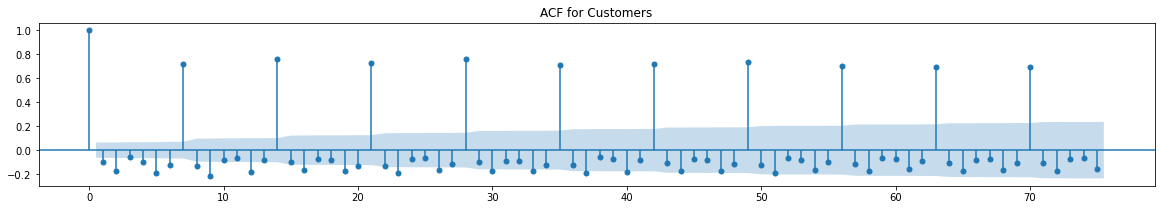

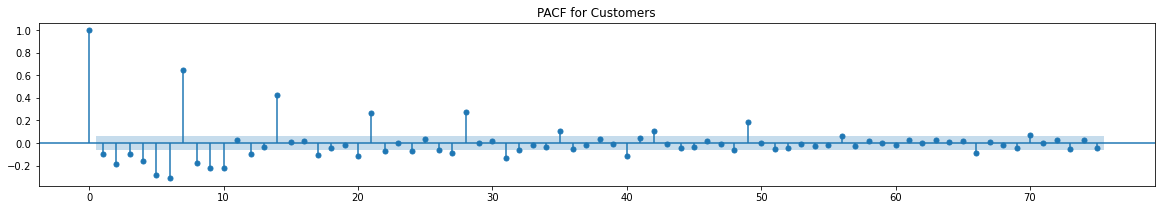

In [203]:
plot_acf_pacf(train_df_all['Customers'],'Customers')

#### From ACF plot , we can find q=0 as we do not have a point after which autocorrelation dies down.
##### From PACF plot , we can choose p=49, as the highest lag where partial autocorrelation is significantly high. But executionof the model will be very high and taking 49 component while modeling, then there is very high chance of overfitting because of high complexity. Hence let's select 7 as p which is the last highest value.
#### same as Sales. As they are cointegrated p, and q are same.

### Train and Test split

In [204]:
train_df_all.head()

Sales   Customers  Promo  SchoolHoliday  DayOfWeek_2  \
Date                                                                     
2013-01-01    62.232914   12.804856      0           1112            1   
2013-01-02  6061.072926  720.625342      0           1097            0   
2013-01-03  5586.966516  666.504072      0           1030            0   
2013-01-04  5852.084239  683.781703      0           1029            0   
2013-01-05  5195.525886  594.768392      0            111            0   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2013-01-01            0            0            0            0            0  
2013-01-02            1            0            0            0            0  
2013-01-03            0            1            0            0            0  
2013-01-04            0            0            1            0            0  
2013-01-05            0            0            0            1            0

In [205]:
train_df_all.tail(43)

Sales   Customers  Promo  SchoolHoliday  DayOfWeek_2  \
Date                                                                     
2015-06-19  7417.619526  751.145985   1096              0            0   
2015-06-20  5588.291553  605.394187      0              0            0   
2015-06-21   118.713899   18.899819      0              0            0   
2015-06-22  5737.840290  653.467332      0              0            0   
2015-06-23  5534.048913  638.451993      0              0            1   
2015-06-24  5520.582428  636.301630      0              0            0   
2015-06-25  5489.448869  636.906787      0              0            0   
2015-06-26  5849.767906  659.371714      0              0            0   
2015-06-27  5727.396004  602.900999      0              0            0   
2015-06-28   104.261302   15.860759      0              0            0   
2015-06-29  9888.239645  861.870809   1014            247            0   
2015-06-30  9539.898338  839.126100   1023            257            1   
2015-07-01  7760.424214  753.451017   1082            277            0   
2015-07-02  7348.793388  732.569330   1089            282            0   
2015-07-03  7439.632110  742.854128   1090            281            0   
2015-07-04  5347.214480  578.921267      0              0            0   
2015-07-05    98.567421   15.417195      0              0            0   
2015-07-06  6553.030192  724.436414      0            280            0   
2015-07-07  5616.616152  642.942831      0            282            1   
2015-07-08  6073.754768  669.207084      0            282            0   
2015-07-09  6095.474114  680.533152      0            283            0   
2015-07-10  6213.171662  692.758401      0            282            0   
2015-07-11  5470.991818  592.285455      0              0            0   
2015-07-12   114.471971   16.910488      0              0            0   
2015-07-13  9205.903810  841.274286   1050            428            0   
2015-07-14  8090.614958  777.277932   1083            441            1   
2015-07-15  7568.350230  747.718894   1085            444            0   
2015-07-16  7304.495875  741.166819   1091            557            0   
2015-07-17  6962.425571  712.757078   1095            560            0   
2015-07-18  5648.410909  602.486364      0              0            0   
2015-07-19   128.259494   18.307414      0              0            0   
2015-07-20  6405.573382  708.793984      0            676            0   
2015-07-21  5596.370807  641.311877      0            682            1   
2015-07-22  5391.502267  613.885766      0            682            0   
2015-07-23  5902.862319  662.663043      0            703            0   
2015-07-24  5840.126697  656.464253      0            704            0   
2015-07-25  5323.024390  563.913279      0             21            0   
2015-07-26   121.551537   18.103074      0             21            0   
2015-07-27  9150.379017  818.426276   1058            818            0   
2015-07-28  7914.733395  747.540590   1084            834            1   
2015-07-29  7443.332420  713.594521   1095            844            0   
2015-07-30  7696.796703  738.756410   1092            915            0   
2015-07-31  8718.222326  822.291163   1075            900            0   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2015-06-19            0            0            1            0            0  
2015-06-20            0            0            0            1            0  
2015-06-21            0            0            0            0            1  
2015-06-22            0            0            0            0            0  
2015-06-23            0            0            0            0            0  
2015-06-24            1            0            0            0            0  
2015-06-25            0            1            0            0 

In [206]:
train_df_all.shape

(942, 10)

#### As we have to forecast for next 6 weeks daily , which is 42 days, lets keep last 42 records for testing and first 92 records for training

In [207]:
train_len=900
train_df_all_train=train_df_all.iloc[:train_len,:]
train_df_all_test=train_df_all.iloc[train_len:,:]

In [208]:
train_df_all_train.tail()

Sales   Customers  Promo  SchoolHoliday  DayOfWeek_2  \
Date                                                                     
2015-06-15  9720.559535  880.256534   1033              0            0   
2015-06-16  8318.741876  796.358403   1077              0            1   
2015-06-17  7530.354986  746.876487   1093              0            0   
2015-06-18  7192.139344  726.374317   1098              0            0   
2015-06-19  7417.619526  751.145985   1096              0            0   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2015-06-15            0            0            0            0            0  
2015-06-16            0            0            0            0            0  
2015-06-17            1            0            0            0            0  
2015-06-18            0            1            0            0            0  
2015-06-19            0            0            1            0            0

In [209]:
train_df_all_train.shape

(900, 10)

In [210]:
train_df_all_test.head()

Sales   Customers  Promo  SchoolHoliday  DayOfWeek_2  \
Date                                                                     
2015-06-20  5588.291553  605.394187      0              0            0   
2015-06-21   118.713899   18.899819      0              0            0   
2015-06-22  5737.840290  653.467332      0              0            0   
2015-06-23  5534.048913  638.451993      0              0            1   
2015-06-24  5520.582428  636.301630      0              0            0   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2015-06-20            0            0            0            1            0  
2015-06-21            0            0            0            0            1  
2015-06-22            0            0            0            0            0  
2015-06-23            0            0            0            0            0  
2015-06-24            1            0            0            0            0

In [211]:
train_df_all_test.shape

(42, 10)

#### Standardize Sales	Customers	Promo	SchoolHoliday

In [212]:
scaler = MinMaxScaler()
#For train data
train_df_all_train[['Sales','Customers','Promo','SchoolHoliday']]=scaler.fit_transform(train_df_all_train[['Sales','Customers','Promo','SchoolHoliday']])
train_df_all_train.head()

Sales  Customers  Promo  SchoolHoliday  DayOfWeek_2  \
Date                                                                 
2013-01-01  0.000000   0.000779    0.0       0.998205            1   
2013-01-02  0.530960   0.615645    0.0       0.984740            0   
2013-01-03  0.488997   0.568631    0.0       0.924596            0   
2013-01-04  0.512463   0.583640    0.0       0.923698            0   
2013-01-05  0.454350   0.506316    0.0       0.099641            0   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2013-01-01            0            0            0            0            0  
2013-01-02            1            0            0            0            0  
2013-01-03            0            1            0            0            0  
2013-01-04            0            0            1            0            0  
2013-01-05            0            0            0            1            0

In [213]:
#For test data
train_df_all_test[['Sales','Customers','Promo','SchoolHoliday']]=scaler.transform(train_df_all_test[['Sales','Customers','Promo','SchoolHoliday']])
train_df_all_test.head()

Sales  Customers  Promo  SchoolHoliday  DayOfWeek_2  \
Date                                                                 
2015-06-20  0.489114   0.515547    0.0            0.0            0   
2015-06-21  0.004999   0.006074    0.0            0.0            0   
2015-06-22  0.502351   0.557306    0.0            0.0            0   
2015-06-23  0.484313   0.544263    0.0            0.0            1   
2015-06-24  0.483121   0.542395    0.0            0.0            0   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2015-06-20            0            0            0            1            0  
2015-06-21            0            0            0            0            1  
2015-06-22            0            0            0            0            0  
2015-06-23            0            0            0            0            0  
2015-06-24            1            0            0            0            0

## VAR Model

In [214]:
exog = train_df_all_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_all_train[['Sales', 'Customers']].astype(float)
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -11.56      -11.46   9.557e-06      -11.52
1       -11.71      -11.59   8.234e-06      -11.66
2       -11.71      -11.57   8.234e-06      -11.65
3       -11.75      -11.59   7.864e-06      -11.69
4       -11.76      -11.58   7.785e-06      -11.69
5       -11.76      -11.56   7.800e-06      -11.68
6       -11.77      -11.54   7.740e-06      -11.68
7       -11.77      -11.53   7.703e-06      -11.68
8       -11.93      -11.66   6.599e-06      -11.83
9       -11.95     -11.66*   6.432e-06      -11.84
10      -11.97      -11.65   6.350e-06      -11.85
11      -11.99      -11.65   6.233e-06      -11.86
12      -11.98      -11.62   6.271e-06      -11.84
13      -11.99      -11.61   6.208e-06      -11.84
14      -12.03      -11.63   5.964e-06      -11.88
15     -12.04*      -11.62  5.909e-06*     -11.88*
-------------------------------

#### In the above output, the AIC drops to lowest at lag 11, then increases at lag 12 and then continuously drops further.Let’s go with the lag 11 model.

In [215]:
var_model_final = var_model.fit(11)
var_model_final.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 10, May, 2021
Time:                     12:06:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.6559
Nobs:                     889.000    HQIC:                  -11.8622
Log likelihood:           2868.65    FPE:                6.20672e-06
AIC:                     -11.9899    Det(Omega_mle):     5.79548e-06
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.473863         0.068970            6.871           0.000
Promo                 0.177958         0.019589            9.085           0.000
SchoolHoliday        -0.053762         0.015023           -3

#### From here we fond the lap(p) as 11. Perform Johansen test with P=11-1

## Cointegration - Johansen Test


In [216]:
train_df_all['Sales']=train_df_all['Sales'].apply(lambda x:round(x))
train_df_all['Customers']=train_df_all['Customers'].apply(lambda x:round(x))

In [217]:
def cointegration_test(df, lag): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    alpha=0.05
    out = coint_johansen(df,-1,lag)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)


In [218]:
cointegration_test(train_df_all[['Sales','Customers']],10)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Sales  ::  79.32     > 12.3212   =>   True
Customers ::  0.83      > 4.1296    =>   False


In [219]:
rank_result=select_coint_rank(train_df_all[['Sales','Customers']],-1,10)

In [220]:
print(rank_result.rank)

1


#### Here we are checking for 2 time series i.e. N=1, we can see the rank is 1 (< N). Hence time series are cointegrated, it means they have a long run, statistically significant relationship.
#### As cointegration exists , we will be needing error correction techniques. We will implement VARMAX algorith, as the MA part of VARMAX will handle error correction.

#### Before that let's forecast and evaluate VAR model

In [221]:
# Get the lag order
lag_order = var_model_final.k_ar
print(lag_order) 
forecast_input = train_df_all_train[['Sales','Customers']].values[-lag_order:]
forecast_input

11


array([[0.52850529, 0.57831362],
       [0.50183655, 0.5555837 ],
       [0.50447556, 0.56619896],
       [0.50952715, 0.56169835],
       [0.5006185 , 0.52048785],
       [0.00391914, 0.0036742 ],
       [0.85486314, 0.75431249],
       [0.73078758, 0.68143232],
       [0.66100708, 0.63844863],
       [0.63107145, 0.62063892],
       [0.65102881, 0.64215744]])

#### At least we nee 11 records for data forecasting. But we have 42 records in our test data. Let's fore cast for 42 records.

In [222]:
exog_test = train_df_all_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
fc = var_model_final.forecast(y=forecast_input, steps=42,exog_future=exog_test)
var_forecast = pd.DataFrame(fc, index=train_df_all_test.index, columns=['Sales','Customers'])
var_forecast

Sales  Customers
Date                           
2015-06-20  0.526668   0.559050
2015-06-21  0.016443   0.006448
2015-06-22  0.511349   0.568124
2015-06-23  0.508895   0.580523
2015-06-24  0.472050   0.538974
2015-06-25  0.429252   0.496579
2015-06-26  0.529284   0.587486
2015-06-27  0.505936   0.535942
2015-06-28  0.019096   0.009695
2015-06-29  0.780109   0.731998
2015-06-30  0.695125   0.676192
2015-07-01  0.655286   0.645421
2015-07-02  0.636649   0.638446
2015-07-03  0.635595   0.639169
2015-07-04  0.497988   0.539376
2015-07-05 -0.007995  -0.002869
2015-07-06  0.520921   0.568725
2015-07-07  0.493288   0.565703
2015-07-08  0.456391   0.531296
2015-07-09  0.422241   0.497933
2015-07-10  0.499381   0.567584
2015-07-11  0.507182   0.544938
2015-07-12  0.017251   0.010991
2015-07-13  0.759670   0.718937
2015-07-14  0.696314   0.677787
2015-07-15  0.645310   0.634901
2015-07-16  0.620153   0.622068
2015-07-17  0.629484   0.632006
2015-07-18  0.493925   0.537034
2015-07-19 -0.007681   0.001163
2015-07-20  0.501450   0.550438
2015-07-21  0.468401   0.543479
2015-07-22  0.439249   0.516412
2015-07-23  0.400388   0.476750
2015-07-24  0.478251   0.547096
2015-07-25  0.512429   0.550463
2015-07-26  0.014335   0.007904
2015-07-27  0.738589   0.696714
2015-07-28  0.680387   0.660341
2015-07-29  0.628243   0.616889
2015-07-30  0.601727   0.603749
2015-07-31  0.608995   0.612516

#### Here we have not transfermed data to make it stationary. Original data was stationary. So no need of any reverse transforation.

In [223]:
train_df_all_test['VarForecastedSales']=var_forecast.Sales
train_df_all_test['VarForecastedCustomers']=var_forecast.Customers

In [224]:
train_df_all_test[['Sales','VarForecastedSales','Customers','VarForecastedCustomers']].head()

Sales  VarForecastedSales  Customers  VarForecastedCustomers
Date                                                                       
2015-06-20  0.489114            0.526668   0.515547                0.559050
2015-06-21  0.004999            0.016443   0.006074                0.006448
2015-06-22  0.502351            0.511349   0.557306                0.568124
2015-06-23  0.484313            0.508895   0.544263                0.580523
2015-06-24  0.483121            0.472050   0.542395                0.538974

In [225]:
def forecasted_timeseries_visualization(series,forecasted_series,c,model):
    fig = plt.figure(figsize=(20, 3))
    series.plot(label='Actual')
    forecasted_series.plot(label='Forecasted')
    plt.xlabel('Date')
    plt.ylabel(c)
    plt.legend(loc='best')
    plt.title('{} model For {}'.format(model,c))
    plt.show()

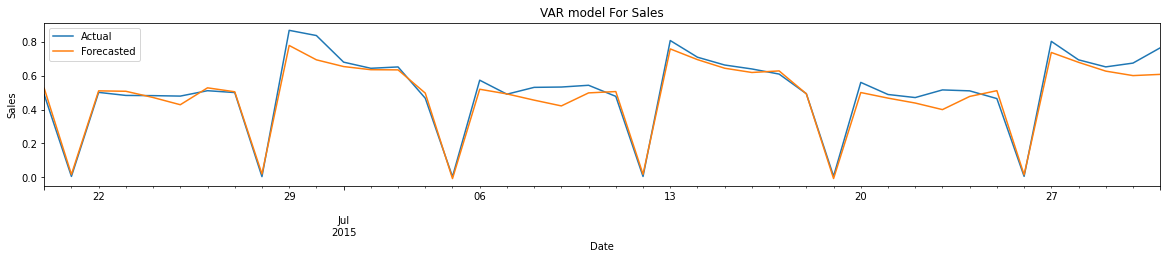

In [226]:
forecasted_timeseries_visualization(train_df_all_test['Sales'],train_df_all_test['VarForecastedSales'],'Sales','VAR')

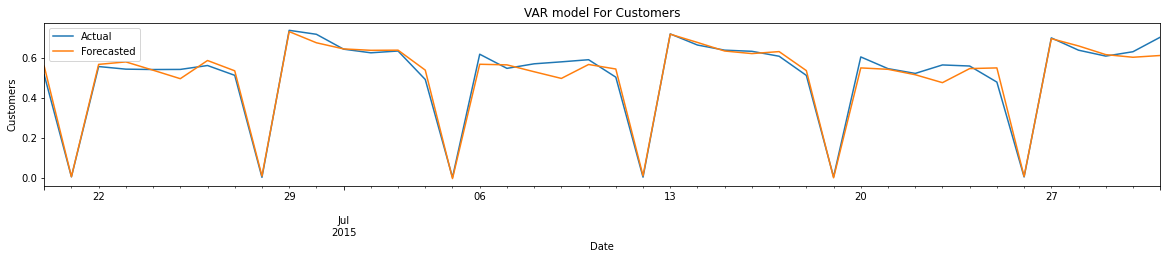

In [227]:
forecasted_timeseries_visualization(train_df_all_test['Customers'],train_df_all_test['VarForecastedCustomers'],'Customers','VAR')

In [228]:
summary_df=pd.DataFrame(columns=['Store','Model','RMSE_SALES','MAPE_SALES','RMSE_CUSTOMERS','MAPE_CUSTOMERS'])
summary_df.head()

Empty DataFrame
Columns: [Store, Model, RMSE_SALES, MAPE_SALES, RMSE_CUSTOMERS, MAPE_CUSTOMERS]
Index: []

In [229]:
def summary(s,fs,c,fc,store,model):
    rmse_sales = np.sqrt(mean_squared_error(s, fs)).round(2)
    mape_sales = np.round(np.mean(np.abs(s-fs)/s)*100,2)
    rmse_customers = np.sqrt(mean_squared_error(c, fc)).round(2)
    mape_customers = np.round(np.mean(np.abs(c-fc)/c)*100,2)
    temp=pd.DataFrame({'Store':[store],'Model':[model], 'RMSE_SALES': [rmse_sales],'MAPE_SALES': [mape_sales] , 
                            'RMSE_CUSTOMERS': [rmse_customers],'MAPE_CUSTOMERS': [mape_customers]})
    return temp

In [230]:
d=summary(train_df_all_test['Sales'], train_df_all_test['VarForecastedSales'],
       train_df_all_test['Customers'], train_df_all_test['VarForecastedCustomers'],'All','VAR')
summary_df = pd.concat([summary_df, d])
summary_df.head()

Store Model  RMSE_SALES  MAPE_SALES  RMSE_CUSTOMERS  MAPE_CUSTOMERS
0   All   VAR        0.05       45.83            0.04           19.99

## VARMAX

#### From above PACF and ACF plot we found, p=7 and q=0.

In [231]:
%%time
exog = train_df_all_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_all_train[['Sales', 'Customers']].astype(float)
varmax_model = sm.tsa.VARMAX(endog, order=(7,0),  exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                2780.284
                              + intercept   AIC                          -5462.569
Date:                    Mon, 10 May 2021   BIC                          -5227.251
Time:                            12:08:29   HQIC                         -5372.676
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):            0.04, 29.27   Jarque-Bera (JB):      7063.35, 958.09
Prob(Q):                        0.84, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.54, 1.42   Skew:                     -2.35, -1.16
P

In [232]:
exog_test = train_df_all_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog_test= train_df_all_test[['Sales','Customers']]
varmax_fc = varmax_model_fit.predict(start=train_df_all_test.index.min(),end=train_df_all_test.index.max(),exog=exog_test)
varmax_forecast = pd.DataFrame(varmax_fc, index=train_df_all_test.index, columns=['Sales','Customers'])
varmax_forecast.head()

Sales  Customers
Date                           
2015-06-20  0.527364   0.562015
2015-06-21  0.006069  -0.000635
2015-06-22  0.553271   0.591591
2015-06-23  0.498546   0.571074
2015-06-24  0.450365   0.531703

In [233]:
train_df_all_test['VarmaxForecastedSales']=varmax_forecast.Sales
train_df_all_test['VarmaxForecastedCustomers']=varmax_forecast.Customers

In [234]:
train_df_all_test[['Sales','VarForecastedSales','VarmaxForecastedSales','Customers','VarForecastedCustomers','VarmaxForecastedCustomers']].head()

Sales  VarForecastedSales  VarmaxForecastedSales  Customers  \
Date                                                                         
2015-06-20  0.489114            0.526668               0.527364   0.515547   
2015-06-21  0.004999            0.016443               0.006069   0.006074   
2015-06-22  0.502351            0.511349               0.553271   0.557306   
2015-06-23  0.484313            0.508895               0.498546   0.544263   
2015-06-24  0.483121            0.472050               0.450365   0.542395   

            VarForecastedCustomers  VarmaxForecastedCustomers  
Date                                                           
2015-06-20                0.559050                   0.562015  
2015-06-21                0.006448                  -0.000635  
2015-06-22                0.568124                   0.591591  
2015-06-23                0.580523                   0.571074  
2015-06-24                0.538974                   0.531703

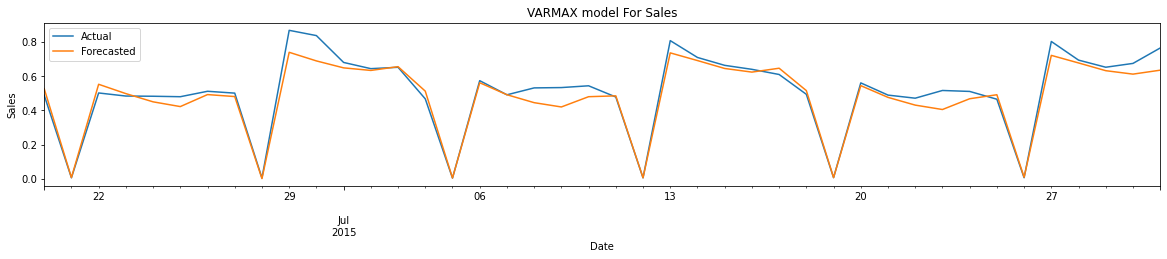

In [235]:
forecasted_timeseries_visualization(train_df_all_test['Sales'],train_df_all_test['VarmaxForecastedSales'],'Sales','VARMAX')

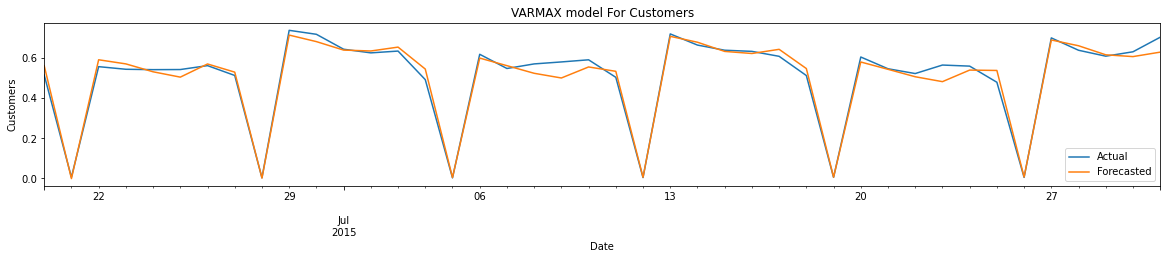

In [236]:
forecasted_timeseries_visualization(train_df_all_test['Customers'],train_df_all_test['VarmaxForecastedCustomers'],'Customers','VARMAX')

In [237]:
d=summary(train_df_all_test['Sales'], train_df_all_test['VarmaxForecastedSales'],
       train_df_all_test['Customers'], train_df_all_test['VarmaxForecastedCustomers'],'All','VARMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head()

Store   Model  RMSE_SALES  MAPE_SALES  RMSE_CUSTOMERS  MAPE_CUSTOMERS
0   All     VAR        0.05       45.83            0.04           19.99
0   All  VARMAX        0.06       11.03            0.03           11.07

## ARIMA

#### p=7,q=0,d=0(original series is stationary)

In [238]:
%%time

#Without exogenous and for sale
exog = train_df_all_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_all_train[['Sales']].astype(float)
arima_model = ARIMA(endog, order=(7,0,0))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                 210.963
Method:                       css-mle   S.D. of innovations              0.191
Date:                Mon, 10 May 2021   AIC                           -403.926
Time:                        12:08:30   BIC                           -360.704
Sample:                    01-01-2013   HQIC                          -387.415
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4875      0.008     62.147      0.000       0.472       0.503
ar.L1.Sales     0.0175      0.028      0.636      0.525      -0.036       0.071
ar.L2.Sales    -0.0055      0.027     -0.204    

In [239]:
arima_sales = arima_model_fit.predict(start=train_df_all_test.index.min(),end=train_df_all_test.index.max())
arima_forecast = pd.DataFrame(arima_sales, index=train_df_all_test.index, columns=['Sales'])
arima_forecast.head()

Sales
Date                
2015-06-20  0.504009
2015-06-21  0.102025
2015-06-22  0.612493
2015-06-23  0.564437
2015-06-24  0.528968

In [240]:
train_df_all_test['ArimaForecastedSales']=arima_forecast.Sales

In [241]:
endog = train_df_all_train[['Customers']].astype(float)
arima_model = ARIMA(endog, order=(7,0,0))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:              Customers   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                 350.648
Method:                       css-mle   S.D. of innovations              0.163
Date:                Mon, 10 May 2021   AIC                           -683.296
Time:                        12:08:31   BIC                           -640.074
Sample:                    01-01-2013   HQIC                          -666.785
                         - 06-19-2015                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.5135      0.005     93.540      0.000       0.503       0.524
ar.L1.Customers    -0.0849      0.026     -3.318      0.001      -0.135      -0.035
ar.L2.Customers    -0.1017      

In [242]:
arima_customers = arima_model_fit.predict(start=train_df_all_test.index.min(),end=train_df_all_test.index.max())
arima_forecast = pd.DataFrame(arima_customers, index=train_df_all_test.index, columns=['Customers'])
arima_forecast.head()

Customers
Date                 
2015-06-20   0.502133
2015-06-21   0.098283
2015-06-22   0.645423
2015-06-23   0.606323
2015-06-24   0.566906

In [243]:
train_df_all_test['ArimaForecastedCustomers']=arima_forecast.Customers

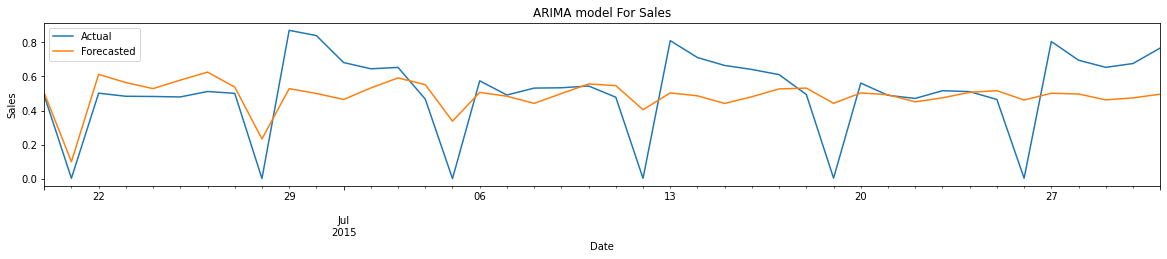

In [244]:
forecasted_timeseries_visualization(train_df_all_test['Sales'],train_df_all_test['ArimaForecastedSales'],'Sales','ARIMA')

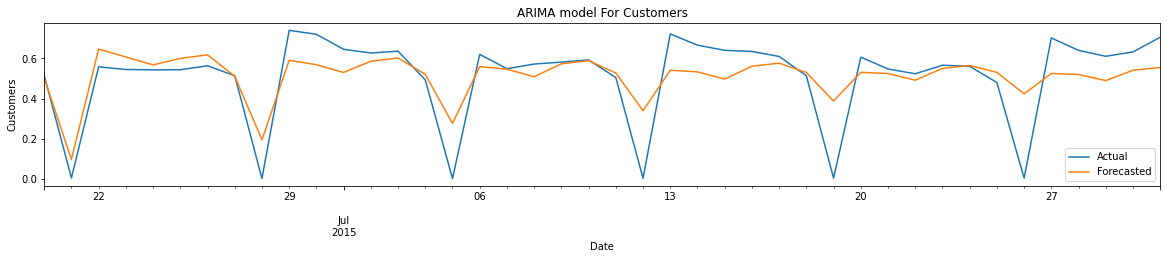

In [245]:
forecasted_timeseries_visualization(train_df_all_test['Customers'],train_df_all_test['ArimaForecastedCustomers'],'Customers','ARIMA')

In [246]:
d=summary(train_df_all_test['Sales'], train_df_all_test['ArimaForecastedSales'],
       train_df_all_test['Customers'], train_df_all_test['ArimaForecastedCustomers'],'All','ARIMA')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

Store   Model  RMSE_SALES  MAPE_SALES  RMSE_CUSTOMERS  MAPE_CUSTOMERS
0   All     VAR        0.05       45.83            0.04           19.99
0   All  VARMAX        0.06       11.03            0.03           11.07
0   All   ARIMA        0.20     1050.15            0.14          924.07

## ARIMAX

In [247]:
%%time

#With exogenous and for sale
exog = train_df_all_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_all_train[['Sales']].astype(float)
arimax_model = ARIMA(endog, order=(7,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                 679.611
Method:                       css-mle   S.D. of innovations              0.114
Date:                Mon, 10 May 2021   AIC                          -1325.222
Time:                        12:08:33   BIC                          -1243.582
Sample:                    01-01-2013   HQIC                         -1294.035
                         - 06-19-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5603      0.012     47.211      0.000       0.537       0.584
Promo             0.1975      0.009     22.053      0.000       0.180       0.215
SchoolHoliday    -0.0330      0.017     

In [248]:
exog_test = train_df_all_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)

arimax_sales = arimax_model_fit.predict(start=train_df_all_test.index.min(),end=train_df_all_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_sales, index=train_df_all_test.index, columns=['Sales'])
arimax_forecast.head()

Sales
Date                
2015-06-20  0.505358
2015-06-21  0.012417
2015-06-22  0.561040
2015-06-23  0.504880
2015-06-24  0.465101

In [249]:
train_df_all_test['ArimaxForecastedSales']=arimax_forecast.Sales

In [250]:
exog = train_df_all_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_all_train[['Customers']].astype(float)
arimax_model = ARIMA(endog, order=(7,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:              Customers   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                 712.363
Method:                       css-mle   S.D. of innovations              0.110
Date:                Mon, 10 May 2021   AIC                          -1390.726
Time:                        12:08:36   BIC                          -1309.086
Sample:                    01-01-2013   HQIC                         -1359.539
                         - 06-19-2015                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6075      0.011     53.854      0.000       0.585       0.630
Promo               0.1167      0.008     15.089      0.000       0.102       0.132
SchoolHoliday      -0.0479      

In [251]:
arimax_customers = arimax_model_fit.predict(start=train_df_all_test.index.min(),end=train_df_all_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_customers, index=train_df_all_test.index, columns=['Customers'])
arimax_forecast.head()

Customers
Date                 
2015-06-20   0.543267
2015-06-21   0.010720
2015-06-22   0.607204
2015-06-23   0.575085
2015-06-24   0.540528

In [252]:
train_df_all_test['ArimaxForecastedCustomes']=arimax_forecast.Customers

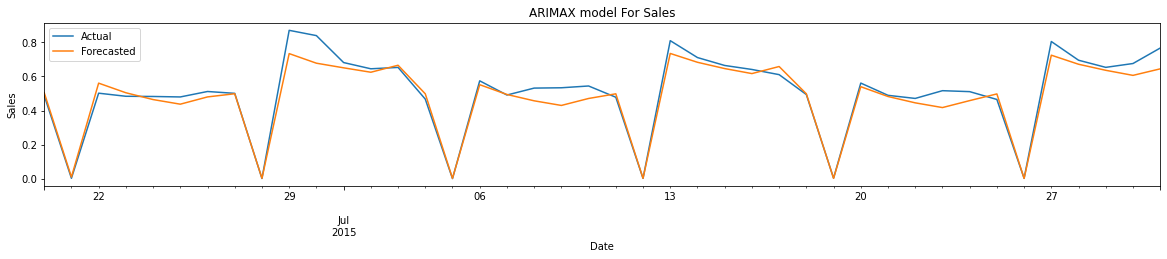

In [253]:
forecasted_timeseries_visualization(train_df_all_test['Sales'],train_df_all_test['ArimaxForecastedSales'],'Sales','ARIMAX')

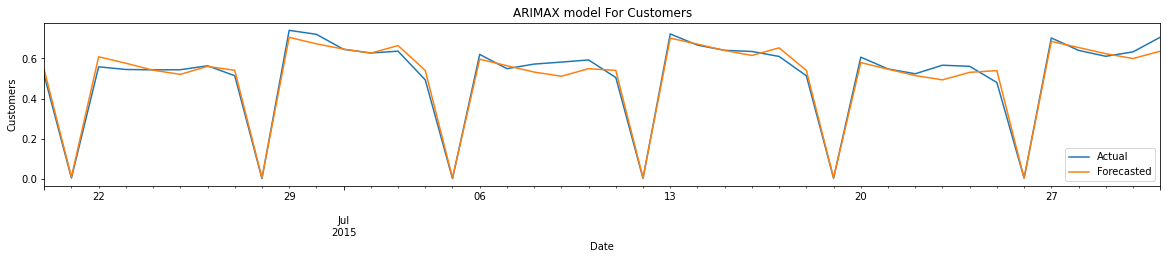

In [254]:
forecasted_timeseries_visualization(train_df_all_test['Customers'],train_df_all_test['ArimaxForecastedCustomes'],'Customers','ARIMAX')

In [255]:
d=summary(train_df_all_test['Sales'], train_df_all_test['ArimaxForecastedSales'],
       train_df_all_test['Customers'], train_df_all_test['ArimaxForecastedCustomes'],'All','ARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

Store   Model  RMSE_SALES  MAPE_SALES  RMSE_CUSTOMERS  MAPE_CUSTOMERS
0   All     VAR        0.05       45.83            0.04           19.99
0   All  VARMAX        0.06       11.03            0.03           11.07
0   All   ARIMA        0.20     1050.15            0.14          924.07
0   All  ARIMAX        0.06       12.62            0.03           12.38

## SARIMA

In [256]:
%%time

#Without exogenous and for sale
exog = train_df_all_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_all_train[['Sales']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                 631.691
Date:                            Mon, 10 May 2021   AIC                          -1217.383
Time:                                    12:11:08   BIC                          -1106.927
Sample:                                01-01-2013   HQIC                         -1175.188
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Promo             0.1971      0.010     19.183      0.000       0.177       0.217
SchoolHoliday    -0.0572  

In [257]:
sarimax_sales = sarima_model_fit.predict(start=train_df_all_test.index.min(),end=train_df_all_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_sales, index=train_df_all_test.index, columns=['Sales'])
sarimax_forecast.head()

Sales
Date            
2015-06-20   NaN
2015-06-21   NaN
2015-06-22   NaN
2015-06-23   NaN
2015-06-24   NaN

In [258]:
train_df_all_test['SarimaxForecastedSales']=sarimax_forecast.Sales

In [259]:
%%time

#Without exogenous and for sale
exog = train_df_all_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_all_train[['Customers']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Customers   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                 644.921
Date:                            Mon, 10 May 2021   AIC                          -1243.842
Time:                                    12:13:55   BIC                          -1133.387
Sample:                                01-01-2013   HQIC                         -1201.648
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Promo             0.1209      0.009     12.941      0.000       0.103       0.139
SchoolHoliday    -0.0463  

In [260]:
sarimax_customers = sarima_model_fit.predict(start=train_df_all_test.index.min(),end=train_df_all_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_customers, index=train_df_all_test.index, columns=['Customers'])
sarimax_forecast.head()

Customers
Date                
2015-06-20       NaN
2015-06-21       NaN
2015-06-22       NaN
2015-06-23       NaN
2015-06-24       NaN

In [261]:
train_df_all_test['SarimaxForecastedCustomers']=sarimax_forecast.Customers

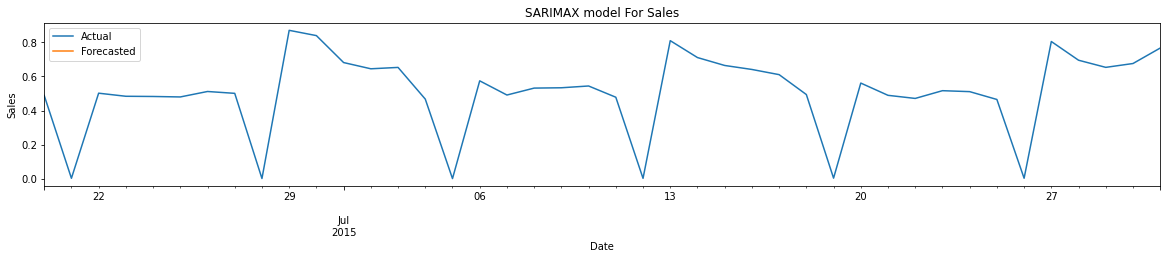

In [262]:
forecasted_timeseries_visualization(train_df_all_test['Sales'],train_df_all_test['SarimaxForecastedSales'],'Sales','SARIMAX')

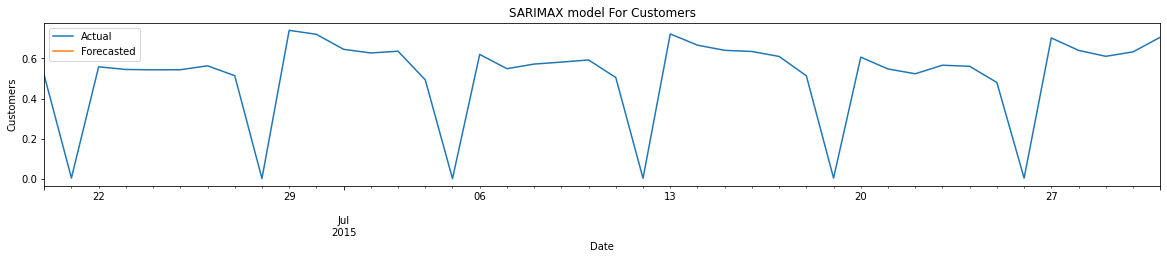

In [263]:
forecasted_timeseries_visualization(train_df_all_test['Customers'],train_df_all_test['SarimaxForecastedCustomers'],'Customers','SARIMAX')

In [265]:
d=summary(train_df_all_test['Sales'], train_df_all_test['SarimaxForecastedSales'],train_df_all_test['Customers'], train_df_all_test['SarimaxForecastedCustomers'],'All','SARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# TimeSeries analysis for key stores  1,3,8,9,13,25,29,31 and 46.

#### Take the data for which the sales and customers present

In [266]:
train_df_1=train_df.loc[train_df.Store==1,:]

In [267]:
train_df_1.head(7)

Store  Sales  Customers  Promo  SchoolHoliday  \
Date                                                        
2013-01-01      1      0          0      0              1   
2013-01-02      1   5530        668      0              1   
2013-01-03      1   4327        578      0              1   
2013-01-04      1   4486        619      0              1   
2013-01-05      1   4997        635      0              1   
2013-01-06      1      0          0      0              1   
2013-01-07      1   7176        785      1              1   

            CompetitionDistance  CompetitionOpenSinceDays  DayOfWeek_2  \
Date                                                                     
2013-01-01               1270.0                      1584            1   
2013-01-02               1270.0                      1585            0   
2013-01-03               1270.0                      1586            0   
2013-01-04               1270.0                      1587            0   
2013-01-05               1270.0                      1588            0   
2013-01-06               1270.0                      1589            0   
2013-01-07               1270.0                      1590            0   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2013-01-01            0            0            0            0            0  
2013-01-02            1            0            0            0            0  
2013-01-03            0            1            0            0            0  
2013-01-04            0            0            1            0            0  
2013-01-05            0            0            0            1            0  
2013-01-06            0            0            0            0            1  
2013-01-07            0            0            0            0            0

In [268]:
train_df_1.tail(7)

Store  Sales  Customers  Promo  SchoolHoliday  \
Date                                                        
2015-07-25      1   4364        500      0              0   
2015-07-26      1      0          0      0              0   
2015-07-27      1   6102        612      1              1   
2015-07-28      1   5011        560      1              1   
2015-07-29      1   4782        523      1              1   
2015-07-30      1   5020        546      1              1   
2015-07-31      1   5263        555      1              1   

            CompetitionDistance  CompetitionOpenSinceDays  DayOfWeek_2  \
Date                                                                     
2015-07-25               1270.0                      2519            0   
2015-07-26               1270.0                      2520            0   
2015-07-27               1270.0                      2521            0   
2015-07-28               1270.0                      2522            1   
2015-07-29               1270.0                      2523            0   
2015-07-30               1270.0                      2524            0   
2015-07-31               1270.0                      2525            0   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2015-07-25            0            0            0            1            0  
2015-07-26            0            0            0            0            1  
2015-07-27            0            0            0            0            0  
2015-07-28            0            0            0            0            0  
2015-07-29            1            0            0            0            0  
2015-07-30            0            1            0            0            0  
2015-07-31            0            0            1            0            0

### Time Series Visualizatin

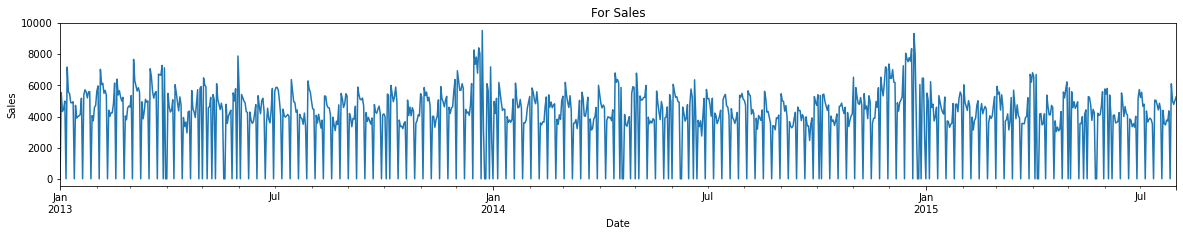

In [269]:
timeseries_visualization(train_df_1['Sales'],'Sales')

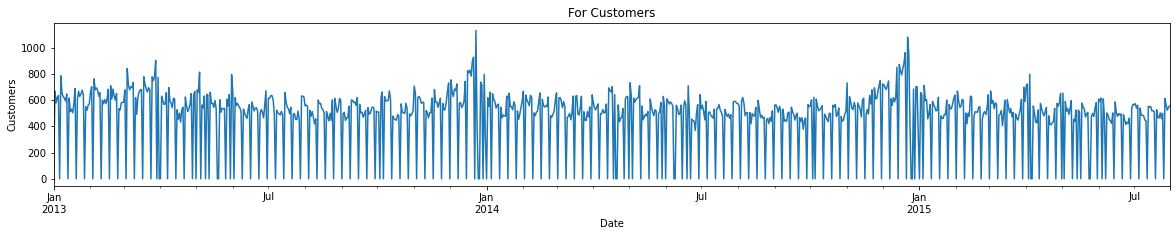

In [270]:
timeseries_visualization(train_df_1['Customers'],'Customers')

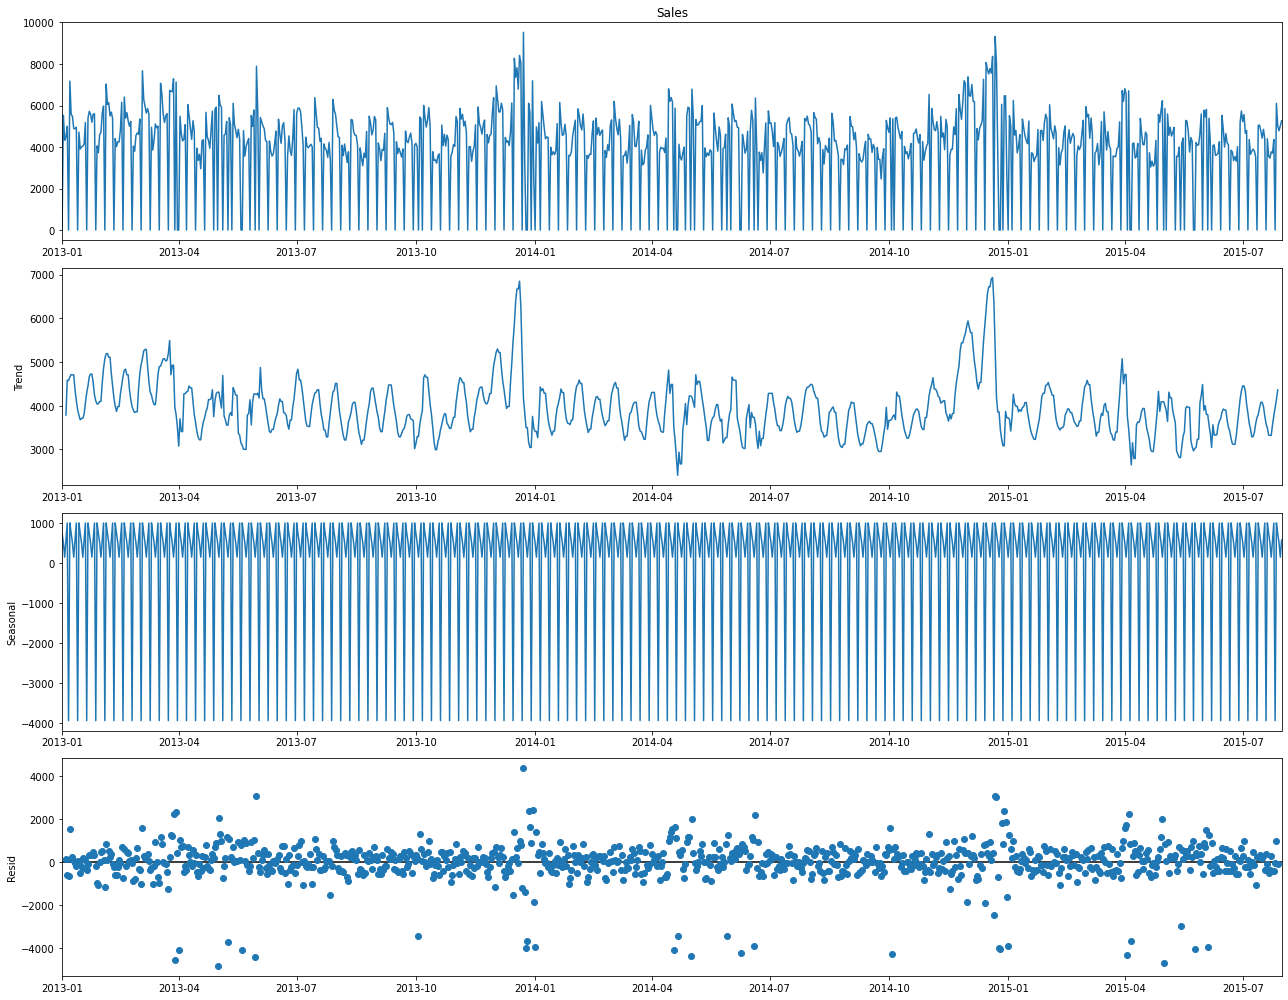

Mean Residual for Sales=0.2284083648050237


In [271]:
plot_seasonal_decomposition(train_df_1['Sales'],'Sales','additive')

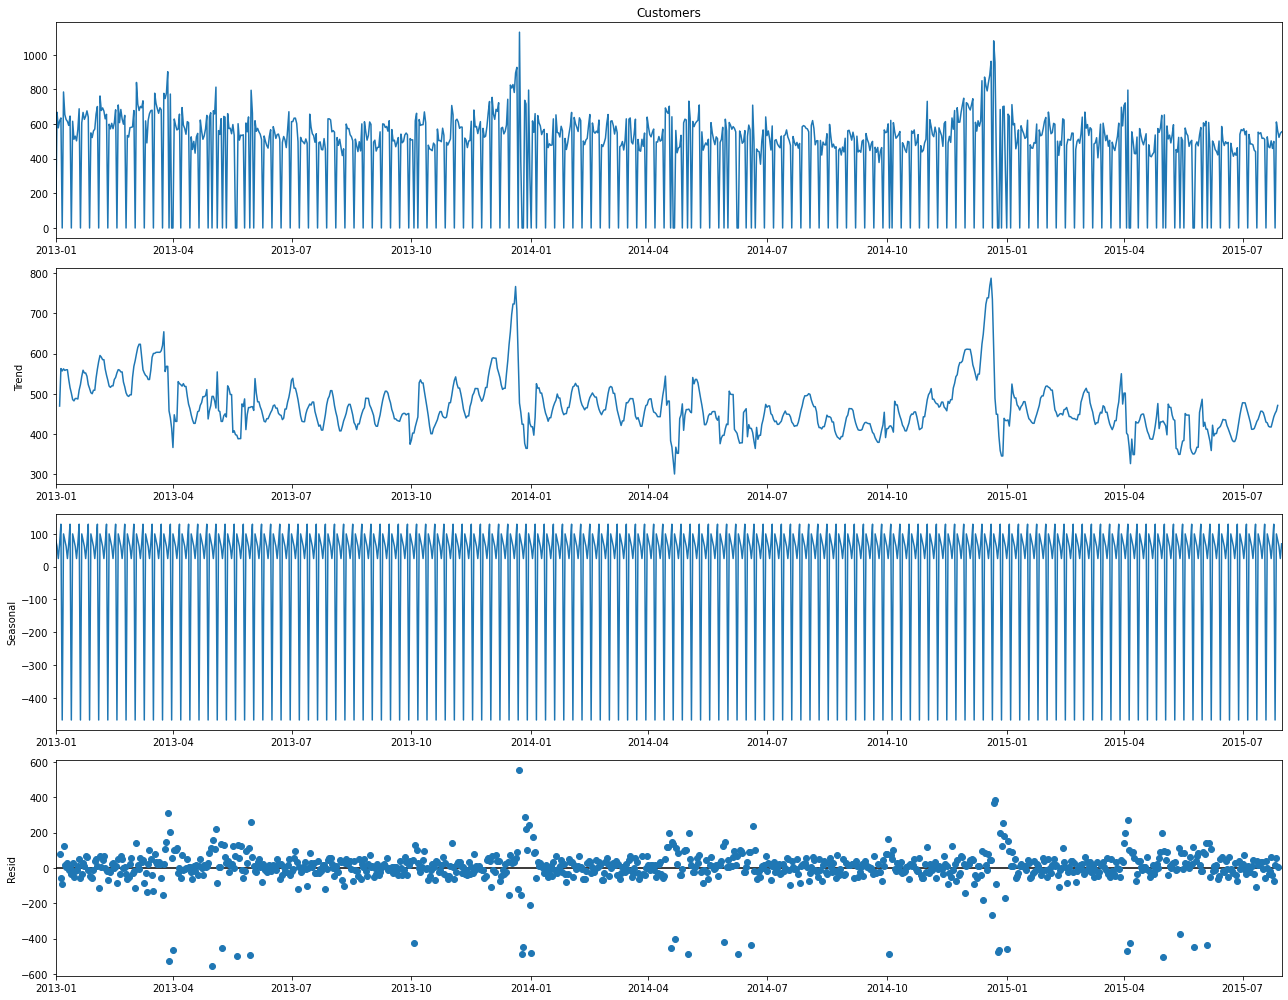

Mean Residual for Customers=0.05374119123580648


In [272]:
plot_seasonal_decomposition(train_df_1['Customers'],'Customers','additive')

In [273]:
train_df_1[['Sales','Customers']].corr()

Sales  Customers
Sales      1.000000   0.984341
Customers  0.984341   1.000000

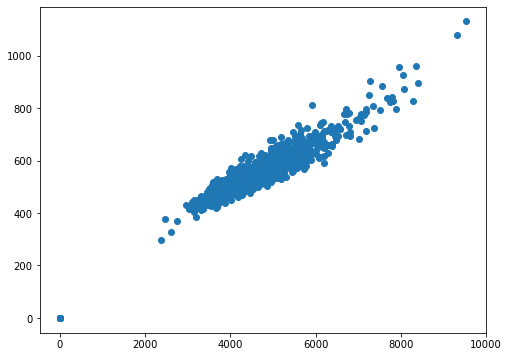

In [274]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(train_df_1['Sales'],train_df_1['Customers'])
plt.show()

#### Here we can see a strong relation between Sales and Customers.

### Causality testing

In [275]:
causality_sales=grangercausalitytests(train_df_1[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=114.7766, p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=115.1437, p=0.0000  , df=1
likelihood ratio test: chi2=108.6256, p=0.0000  , df=1
parameter F test:         F=114.7766, p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=59.1838 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=119.0005, p=0.0000  , df=2
likelihood ratio test: chi2=112.0489, p=0.0000  , df=2
parameter F test:         F=59.1838 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=38.8194 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=117.3328, p=0.0000  , df=3
likelihood ratio test: chi2=110.5608, p=0.0000  , df=3
parameter F test:         F=38.8194 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=30.0043 , p=0.0000  

In [276]:
causality_customers=grangercausalitytests(train_df_1[['Customers','Sales']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=46.8552 , p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=47.0051 , p=0.0000  , df=1
likelihood ratio test: chi2=45.8688 , p=0.0000  , df=1
parameter F test:         F=46.8552 , p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=22.4182 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=45.0761 , p=0.0000  , df=2
likelihood ratio test: chi2=44.0287 , p=0.0000  , df=2
parameter F test:         F=22.4182 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=16.0372 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=48.4730 , p=0.0000  , df=3
likelihood ratio test: chi2=47.2634 , p=0.0000  , df=3
parameter F test:         F=16.0372 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=12.4879 , p=0.0000  

#### Here all the tests signify causality at significance level 0.05. All indicates that causality exists between sales and customers.
### Testing for stationary


In [277]:
stationary_test(train_df_1[['Sales','Customers']])

For  Sales
****************************************************************************************************
ADF Statistic= -4.368104368168496
P value= 0.00033788346141424734
 => P-Value = 0.0003. Rejecting Null Hypothesis.
 => Series is Stationary.
For  Customers
****************************************************************************************************
ADF Statistic= -3.696842111734537
P value= 0.004157792561711086
 => P-Value = 0.0042. Rejecting Null Hypothesis.
 => Series is Stationary.


##### 1%:-3.44,5%:-2.86,10%:-2.56 . If we compare the ADF statistic value, for both Sales and Customers, the value is less than the value of 1%. Which means we have to reject null hypothesis i.e. Series is not stationary.
##### Here we can see the P value is less than -.05 for both Sales and Customers, which implys both sereies are stationary. As our original data is stationary the degree of integration is 0 (I(0)).
##### Here we do not have any othe time series except Sales and Customers. Other variables are not time series components . They can be considered as exogenous variables.
### Autocoorelation and degree of integration

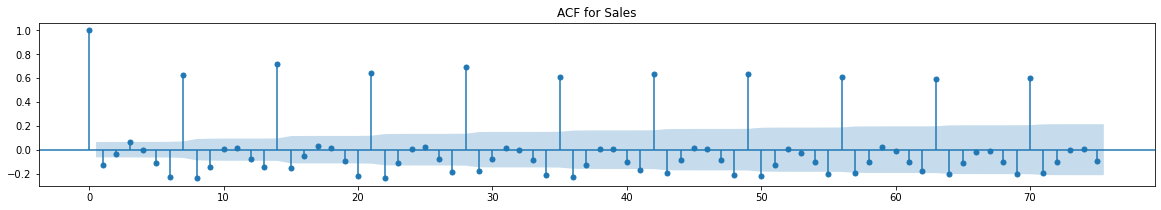

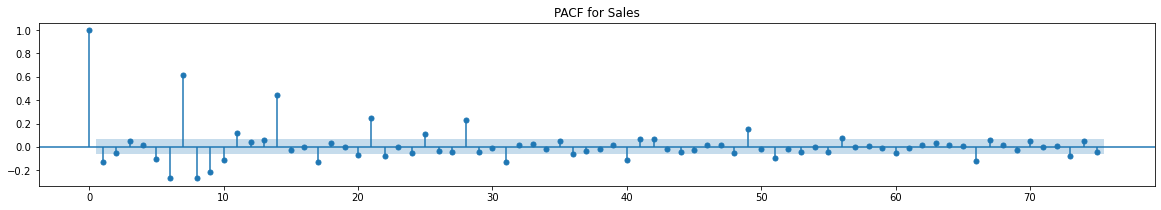

In [278]:
plot_acf_pacf(train_df_1['Sales'],'Sales')

#### From ACF plot , we can find q=0 as we do not have a point after which autocorrelation dies down.
#### From PACF plot , we can choose p=49, as the highest lag where partial autocorrelation is significantly high. But executionof the model will be very high and taking 49 component while modeling, then there is very high chance of overfitting because of high complexity. Hence let's select 7 as p which is the last highest value.

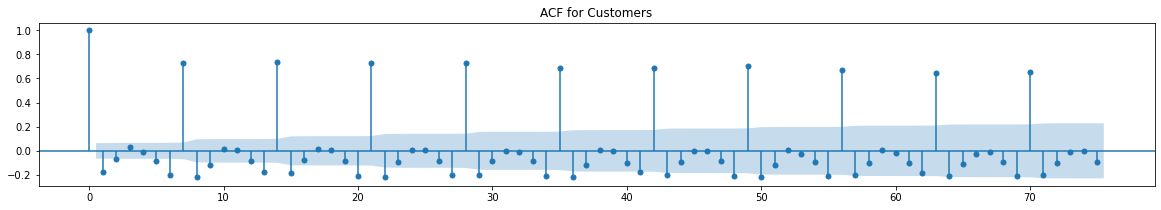

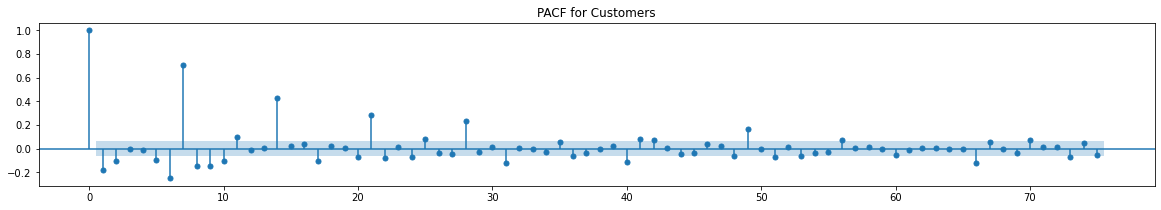

In [279]:
plot_acf_pacf(train_df_1['Customers'],'Customers')

#### From ACF plot , we can find q=0 as we do not have a point after which autocorrelation dies down.
#### From PACF plot , we can choose p=49, as the highest lag where partial autocorrelation is significantly high. But executionof the model will be very high and taking 49 component while modeling, then there is very high chance of overfitting because of high complexity. Hence let's select 7 as p which is the last highest value.
#### same as Sales. As they are cointegrated p, and q are same.

### Train and Test split

In [280]:
train_df_1.head()

Store  Sales  Customers  Promo  SchoolHoliday  \
Date                                                        
2013-01-01      1      0          0      0              1   
2013-01-02      1   5530        668      0              1   
2013-01-03      1   4327        578      0              1   
2013-01-04      1   4486        619      0              1   
2013-01-05      1   4997        635      0              1   

            CompetitionDistance  CompetitionOpenSinceDays  DayOfWeek_2  \
Date                                                                     
2013-01-01               1270.0                      1584            1   
2013-01-02               1270.0                      1585            0   
2013-01-03               1270.0                      1586            0   
2013-01-04               1270.0                      1587            0   
2013-01-05               1270.0                      1588            0   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2013-01-01            0            0            0            0            0  
2013-01-02            1            0            0            0            0  
2013-01-03            0            1            0            0            0  
2013-01-04            0            0            1            0            0  
2013-01-05            0            0            0            1            0

In [281]:
train_df_1.tail()

Store  Sales  Customers  Promo  SchoolHoliday  \
Date                                                        
2015-07-27      1   6102        612      1              1   
2015-07-28      1   5011        560      1              1   
2015-07-29      1   4782        523      1              1   
2015-07-30      1   5020        546      1              1   
2015-07-31      1   5263        555      1              1   

            CompetitionDistance  CompetitionOpenSinceDays  DayOfWeek_2  \
Date                                                                     
2015-07-27               1270.0                      2521            0   
2015-07-28               1270.0                      2522            1   
2015-07-29               1270.0                      2523            0   
2015-07-30               1270.0                      2524            0   
2015-07-31               1270.0                      2525            0   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2015-07-27            0            0            0            0            0  
2015-07-28            0            0            0            0            0  
2015-07-29            1            0            0            0            0  
2015-07-30            0            1            0            0            0  
2015-07-31            0            0            1            0            0

In [282]:
train_df_1.shape

(942, 13)

#### As we have to  forecast for next 6 weeks daily , which is 42 days, lets keep last 42 records for testing and first 900 records for training

In [283]:
train_len = 900
train_df_1_train=train_df_1.iloc[:train_len,:]
train_df_1_test=train_df_1.iloc[train_len:,:]

In [284]:
train_df_1_train.tail(2)

Store  Sales  Customers  Promo  SchoolHoliday  \
Date                                                        
2015-06-18      1   4645        498      1              0   
2015-06-19      1   4202        487      1              0   

            CompetitionDistance  CompetitionOpenSinceDays  DayOfWeek_2  \
Date                                                                     
2015-06-18               1270.0                      2482            0   
2015-06-19               1270.0                      2483            0   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2015-06-18            0            1            0            0            0  
2015-06-19            0            0            1            0            0

In [285]:
train_df_1_test.head(2)

Store  Sales  Customers  Promo  SchoolHoliday  \
Date                                                        
2015-06-20      1   4097        494      0              0   
2015-06-21      1      0          0      0              0   

            CompetitionDistance  CompetitionOpenSinceDays  DayOfWeek_2  \
Date                                                                     
2015-06-20               1270.0                      2484            0   
2015-06-21               1270.0                      2485            0   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2015-06-20            0            0            0            1            0  
2015-06-21            0            0            0            0            1

#### Standardize Sales Customers

In [286]:
train_df_1_train[['Sales','Customers']]=scaler.fit_transform(train_df_1_train[['Sales','Customers']])
train_df_1_train.head()

Store     Sales  Customers  Promo  SchoolHoliday  \
Date                                                           
2013-01-01      1  0.000000   0.000000      0              1   
2013-01-02      1  0.580395   0.591150      0              1   
2013-01-03      1  0.454135   0.511504      0              1   
2013-01-04      1  0.470823   0.547788      0              1   
2013-01-05      1  0.524454   0.561947      0              1   

            CompetitionDistance  CompetitionOpenSinceDays  DayOfWeek_2  \
Date                                                                     
2013-01-01               1270.0                      1584            1   
2013-01-02               1270.0                      1585            0   
2013-01-03               1270.0                      1586            0   
2013-01-04               1270.0                      1587            0   
2013-01-05               1270.0                      1588            0   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2013-01-01            0            0            0            0            0  
2013-01-02            1            0            0            0            0  
2013-01-03            0            1            0            0            0  
2013-01-04            0            0            1            0            0  
2013-01-05            0            0            0            1            0

In [287]:
#For test data
train_df_1_test[['Sales','Customers']]=scaler.transform(train_df_1_test[['Sales','Customers']])
train_df_1_test.head()

Store     Sales  Customers  Promo  SchoolHoliday  \
Date                                                           
2015-06-20      1  0.429996   0.437168      0              0   
2015-06-21      1  0.000000   0.000000      0              0   
2015-06-22      1  0.403652   0.432743      0              0   
2015-06-23      1  0.394836   0.395575      0              0   
2015-06-24      1  0.351175   0.366372      0              0   

            CompetitionDistance  CompetitionOpenSinceDays  DayOfWeek_2  \
Date                                                                     
2015-06-20               1270.0                      2484            0   
2015-06-21               1270.0                      2485            0   
2015-06-22               1270.0                      2486            0   
2015-06-23               1270.0                      2487            1   
2015-06-24               1270.0                      2488            0   

            DayOfWeek_3  DayOfWeek_4  DayOfWeek_5  DayOfWeek_6  DayOfWeek_7  
Date                                                                         
2015-06-20            0            0            0            1            0  
2015-06-21            0            0            0            0            1  
2015-06-22            0            0            0            0            0  
2015-06-23            0            0            0            0            0  
2015-06-24            1            0            0            0            0

#### We have seen, when compititor opens up and the distance is less , then only it impacts the sales for very few days.  If it is far then there is no impact. As CompetitionDistance is constant for store. We can ignore it and CompetitionOpenSinceDays from exogenous variable. We can consider ignore as CompetitionOpenSinceDays 

### VAR Model

In [288]:
exog = train_df_1_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_1_train[['Sales', 'Customers']].astype(float)
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)
print(res.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -11.69      -11.59   8.362e-06      -11.65
1       -11.76     -11.64*   7.841e-06      -11.71
2       -11.76      -11.62   7.781e-06      -11.71
3       -11.77      -11.61   7.701e-06      -11.71
4       -11.77      -11.59   7.719e-06      -11.70
5       -11.78      -11.57   7.673e-06      -11.70
6       -11.79      -11.56   7.580e-06      -11.70
7       -11.80      -11.55   7.484e-06      -11.71
8       -11.81      -11.54   7.464e-06      -11.70
9       -11.81      -11.52   7.440e-06      -11.70
10      -11.84      -11.52   7.235e-06     -11.72*
11     -11.84*      -11.50  7.232e-06*      -11.71
12      -11.83      -11.48   7.260e-06      -11.70
13      -11.84      -11.46   7.241e-06      -11.69
14      -11.83      -11.43   7.257e-06      -11.68
15      -11.83      -11.41   7.273e-06      -11.67
-------------------------------

#### In the above output, the AIC drops to lowest at lag 8, then same at lag 9,decrease at lag 10 and then continuously drops further.Let’s go with the lag 8 model.¶

In [289]:
var_model_final = var_model.fit(8)
var_model_final.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 10, May, 2021
Time:                     12:15:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.5434
Nobs:                     892.000    HQIC:                  -11.7094
Log likelihood:           2786.78    FPE:                7.41494e-06
AIC:                     -11.8120    Det(Omega_mle):     7.01615e-06
--------------------------------------------------------------------
Results for equation Sales
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.237337         0.036520            6.499           0.000
Promo                 0.141430         0.014399            9.822           0.000
SchoolHoliday        -0.018132         0.009209           -1

#### From here we fond the lap(p) as 10. Perform Johansen test with P=10-1

In [290]:
train_df_1['Sales']=train_df_1['Sales'].apply(lambda x:round(x))
train_df_1['Customers']=train_df_1['Customers'].apply(lambda x:round(x))

In [291]:
cointegration_test(train_df_1[['Sales','Customers']],7)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Sales  ::  165.54    > 12.3212   =>   True
Customers ::  0.93      > 4.1296    =>   False


In [292]:
rank_result=select_coint_rank(train_df_1[['Sales','Customers']],-1,9)

In [293]:
print(rank_result.rank)

1


#### Here we are checking for 2 time series i.e. N=1, we can see the rank is 1 (< N). Hence time series are cointegrated, it means they have a long run, statistically significant relationship.
#### As cointegration exists , we will be needing error correction techniques. We will implement VARMAX algorith, as the MA part of VARMAX will handle error correction.
#### Before that let's forecast and evaluate VAR model¶

In [294]:
# Get the lag order
lag_order = var_model_final.k_ar
print(lag_order) 
forecast_input = train_df_1_train[['Sales','Customers']].values[-lag_order:]
forecast_input

8


array([[0.38780437, 0.37345133],
       [0.44668346, 0.44424779],
       [0.        , 0.        ],
       [0.57913518, 0.51858407],
       [0.50923594, 0.44513274],
       [0.41981528, 0.42123894],
       [0.4875105 , 0.44070796],
       [0.44101595, 0.43097345]])

In [295]:
exog_test = train_df_1_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
fc = var_model_final.forecast(y=forecast_input, steps=42,exog_future=exog_test)
var_forecast = pd.DataFrame(fc, index=train_df_1_test.index, columns=['Sales','Customers'])
var_forecast

Sales  Customers
Date                           
2015-06-20  0.496366   0.498933
2015-06-21 -0.009721  -0.013503
2015-06-22  0.403207   0.415869
2015-06-23  0.409562   0.431309
2015-06-24  0.366617   0.399130
2015-06-25  0.325371   0.366212
2015-06-26  0.393838   0.424589
2015-06-27  0.501973   0.516990
2015-06-28 -0.003186  -0.002936
2015-06-29  0.575904   0.533899
2015-06-30  0.553321   0.521214
2015-07-01  0.524465   0.498286
2015-07-02  0.489449   0.469506
2015-07-03  0.528620   0.505008
2015-07-04  0.519499   0.527549
2015-07-05 -0.005859  -0.005903
2015-07-06  0.443574   0.457051
2015-07-07  0.412953   0.439779
2015-07-08  0.395526   0.431165
2015-07-09  0.348832   0.389553
2015-07-10  0.407884   0.441168
2015-07-11  0.521634   0.536428
2015-07-12  0.006534   0.007893
2015-07-13  0.586376   0.545718
2015-07-14  0.565047   0.533626
2015-07-15  0.532387   0.507480
2015-07-16  0.499319   0.480075
2015-07-17  0.536506   0.513384
2015-07-18  0.525891   0.534561
2015-07-19  0.000542   0.000842
2015-07-20  0.448531   0.462485
2015-07-21  0.417806   0.445074
2015-07-22  0.400007   0.435991
2015-07-23  0.352620   0.393709
2015-07-24  0.411506   0.445058
2015-07-25  0.524700   0.539736
2015-07-26  0.009251   0.010842
2015-07-27  0.570749   0.527871
2015-07-28  0.550489   0.515586
2015-07-29  0.516635   0.487970
2015-07-30  0.481026   0.458120
2015-07-31  0.518330   0.491319

In [296]:
train_df_1_test['VarForecastedSales']=var_forecast.Sales
train_df_1_test['VarForecastedCustomers']=var_forecast.Customers

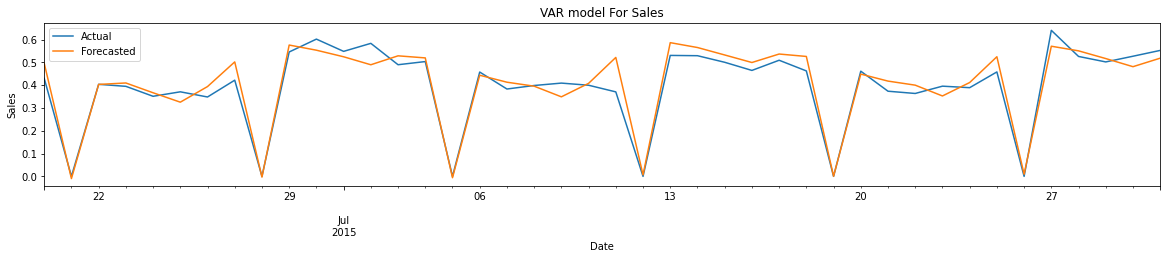

In [297]:
forecasted_timeseries_visualization(train_df_1_test['Sales'],train_df_1_test['VarForecastedSales'],'Sales','VAR')

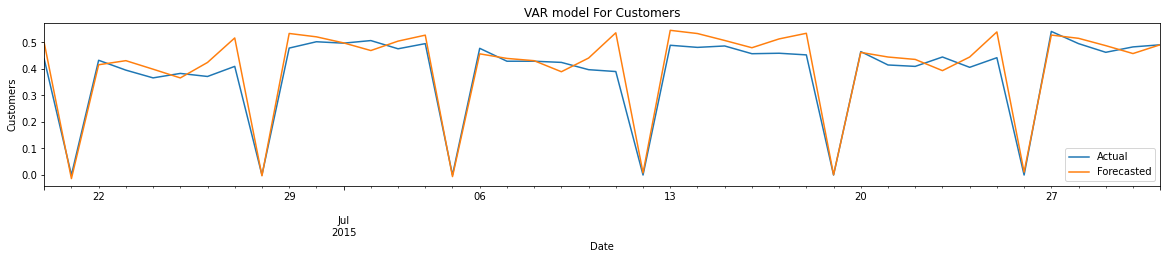

In [298]:
forecasted_timeseries_visualization(train_df_1_test['Customers'],train_df_1_test['VarForecastedCustomers'],'Customers','VAR')

In [299]:
train_df_1_test_temp=train_df_1_test.loc[(train_df_1_test.Sales!=0) & (train_df_1_test.Customers!=0),:]

In [300]:
d=summary(train_df_1_test_temp['Sales'], train_df_1_test_temp['VarForecastedSales'],
       train_df_1_test_temp['Customers'], train_df_1_test_temp['VarForecastedCustomers'],'Store-1','VAR')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

Store   Model  RMSE_SALES  MAPE_SALES  RMSE_CUSTOMERS  MAPE_CUSTOMERS
0      All     VAR        0.05       45.83            0.04           19.99
0      All  VARMAX        0.06       11.03            0.03           11.07
0      All   ARIMA        0.20     1050.15            0.14          924.07
0      All  ARIMAX        0.06       12.62            0.03           12.38
0  Store-1     VAR        0.05        8.94            0.05            8.78

## VARMAX

#### From above PACF and ACF plot we found, p=7 and q=0.

In [301]:
%%time
exog = train_df_1_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_1_train[['Sales', 'Customers']].astype(float)
varmax_model = sm.tsa.VARMAX(endog, order=(7,0),  exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                2795.441
                              + intercept   AIC                          -5492.882
Date:                    Mon, 10 May 2021   BIC                          -5257.564
Time:                            12:17:04   HQIC                         -5402.989
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (L1) (Q):             0.59, 2.63   Jarque-Bera (JB):       3768.04, 44.71
Prob(Q):                        0.44, 0.11   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.40, 1.06   Skew:                     -1.73, -0.23
P

In [302]:
exog_test = train_df_1_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog_test= train_df_1_test[['Sales','Customers']]
varmax_fc = varmax_model_fit.predict(start=train_df_1_test.index.min(),end=train_df_1_test.index.max(),exog=exog_test)
varmax_forecast = pd.DataFrame(varmax_fc, index=train_df_1_test.index, columns=['Sales','Customers'])
varmax_forecast.head()

Sales  Customers
Date                           
2015-06-20  0.497112   0.500205
2015-06-21 -0.007365  -0.011241
2015-06-22  0.407480   0.418456
2015-06-23  0.405647   0.428315
2015-06-24  0.359648   0.393487

In [303]:
train_df_1_test['VarmaxForecastedSales']=varmax_forecast.Sales
train_df_1_test['VarmaxForecastedCustomers']=varmax_forecast.Customers

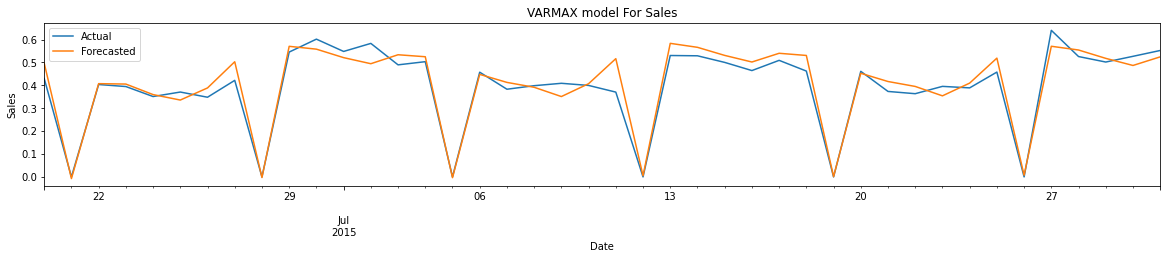

In [304]:
forecasted_timeseries_visualization(train_df_1_test['Sales'],train_df_1_test['VarmaxForecastedSales'],'Sales','VARMAX')

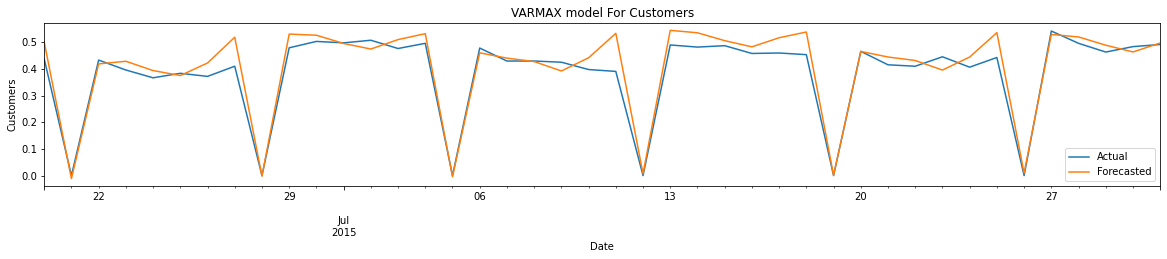

In [305]:
forecasted_timeseries_visualization(train_df_1_test['Customers'],train_df_1_test['VarmaxForecastedCustomers'],'Customers','VARMAX')

In [306]:
train_df_1_test_temp=train_df_1_test.loc[(train_df_1_test.Sales!=0) & (train_df_1_test.Customers!=0),:]
d=summary(train_df_1_test_temp['Sales'], train_df_1_test_temp['VarmaxForecastedSales'],
       train_df_1_test_temp['Customers'], train_df_1_test_temp['VarmaxForecastedCustomers'],'Store-1','VARMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(10)

Store   Model  RMSE_SALES  MAPE_SALES  RMSE_CUSTOMERS  MAPE_CUSTOMERS
0      All     VAR        0.05       45.83            0.04           19.99
0      All  VARMAX        0.06       11.03            0.03           11.07
0      All   ARIMA        0.20     1050.15            0.14          924.07
0      All  ARIMAX        0.06       12.62            0.03           12.38
0  Store-1     VAR        0.05        8.94            0.05            8.78
0  Store-1  VARMAX        0.05        8.61            0.05            8.58

## ARIMA

In [307]:
%%time

#With exogenous and for sale
exog = train_df_1_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_1_train[['Sales']].astype(float)
arimax_model = ARIMA(endog, order=(7,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                 733.618
Method:                       css-mle   S.D. of innovations              0.107
Date:                Mon, 10 May 2021   AIC                          -1433.236
Time:                        12:17:06   BIC                          -1351.595
Sample:                    01-01-2013   HQIC                         -1402.048
                         - 06-19-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4491      0.013     35.267      0.000       0.424       0.474
Promo             0.1399      0.007     18.940      0.000       0.125       0.154
SchoolHoliday    -0.0213      0.012     

In [308]:
exog_test = train_df_1_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)

arimax_sales = arimax_model_fit.predict(start=train_df_1_test.index.min(),end=train_df_1_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_sales, index=train_df_1_test.index, columns=['Sales'])
arimax_forecast.head()

Sales
Date                
2015-06-20  0.492650
2015-06-21 -0.009125
2015-06-22  0.417065
2015-06-23  0.396533
2015-06-24  0.370145

In [309]:
train_df_1_test['ArimaxForecastedSales']=arimax_forecast.Sales

In [310]:
exog = train_df_1_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_1_train[['Customers']].astype(float)
arimax_model = ARIMA(endog, order=(7,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:              Customers   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                 785.067
Method:                       css-mle   S.D. of innovations              0.101
Date:                Mon, 10 May 2021   AIC                          -1536.133
Time:                        12:17:08   BIC                          -1454.492
Sample:                    01-01-2013   HQIC                         -1504.946
                         - 06-19-2015                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4656      0.012     38.125      0.000       0.442       0.490
Promo               0.0812      0.007     12.067      0.000       0.068       0.094
SchoolHoliday      -0.0262      

In [311]:
arimax_customers = arimax_model_fit.predict(start=train_df_1_test.index.min(),end=train_df_1_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_customers, index=train_df_1_test.index, columns=['Customers'])
arimax_forecast.head()

Customers
Date                 
2015-06-20   0.505507
2015-06-21  -0.015120
2015-06-22   0.432524
2015-06-23   0.416361
2015-06-24   0.403274

In [312]:
train_df_1_test['ArimaxForecastedCustomes']=arimax_forecast.Customers

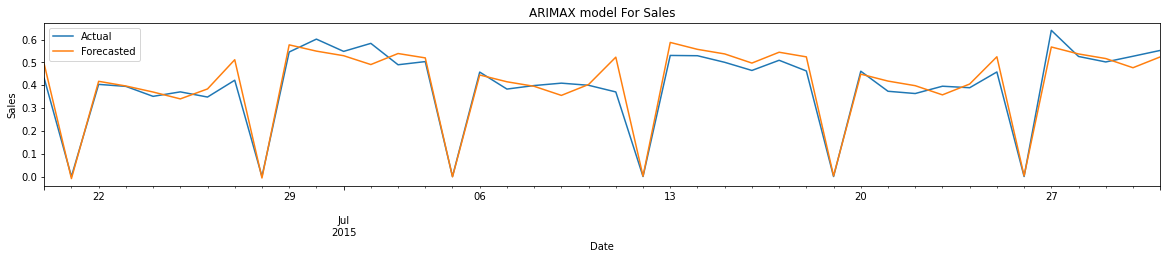

In [313]:
forecasted_timeseries_visualization(train_df_1_test['Sales'],train_df_1_test['ArimaxForecastedSales'],'Sales','ARIMAX')

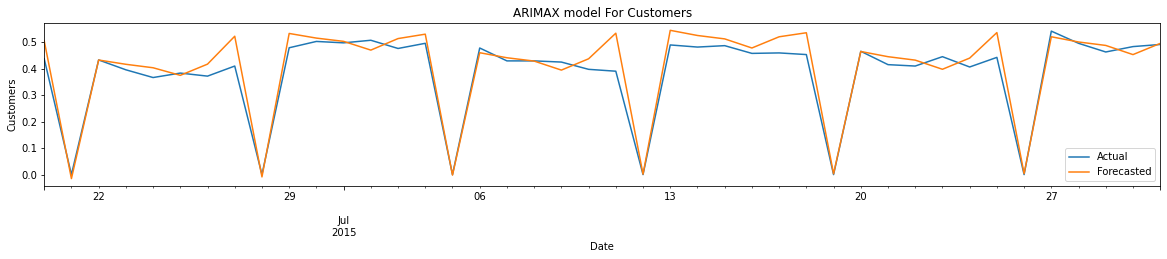

In [314]:
forecasted_timeseries_visualization(train_df_1_test['Customers'],train_df_1_test['ArimaxForecastedCustomes'],'Customers','ARIMAX')

In [315]:
train_df_1_test_temp=train_df_1_test.loc[(train_df_1_test.Sales!=0) & (train_df_1_test.Customers!=0),:]
d=summary(train_df_1_test_temp['Sales'], train_df_1_test_temp['ArimaxForecastedSales'],
       train_df_1_test_temp['Customers'], train_df_1_test_temp['ArimaxForecastedCustomes'],'Store-1','ARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

Store   Model  RMSE_SALES  MAPE_SALES  RMSE_CUSTOMERS  MAPE_CUSTOMERS
0      All     VAR        0.05       45.83            0.04           19.99
0      All  VARMAX        0.06       11.03            0.03           11.07
0      All   ARIMA        0.20     1050.15            0.14          924.07
0      All  ARIMAX        0.06       12.62            0.03           12.38
0  Store-1     VAR        0.05        8.94            0.05            8.78
0  Store-1  VARMAX        0.05        8.61            0.05            8.58
0  Store-1  ARIMAX        0.05        8.66            0.05            8.40

## SARIMA

In [316]:
%%time

#Without exogenous and for sale
exog = train_df_1_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_1_train[['Sales']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                 706.608
Date:                            Mon, 10 May 2021   AIC                          -1367.216
Time:                                    12:19:42   BIC                          -1256.761
Sample:                                01-01-2013   HQIC                         -1325.021
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Promo             0.1410      0.009     16.542      0.000       0.124       0.158
SchoolHoliday    -0.0310  

In [317]:
sarimax_sales = sarima_model_fit.predict(start=train_df_1_test.index.min(),end=train_df_1_test.index.max(),exog=exog_test,freq='D')
sarimax_forecast = pd.DataFrame(sarimax_sales, index=train_df_1_test.index, columns=['Sales'])
# sarimax_forecast.head()

In [318]:
sarimax_forecast.head()

Sales
Date            
2015-06-20   NaN
2015-06-21   NaN
2015-06-22   NaN
2015-06-23   NaN
2015-06-24   NaN

In [319]:

train_df_1_test['SarimaxForecastedSales']=sarimax_forecast.Sales

In [320]:
%%time

#Without exogenous and for sale
exog = train_df_1_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_1_train[['Customers']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                          Customers   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                 755.892
Date:                            Mon, 10 May 2021   AIC                          -1465.784
Time:                                    12:22:05   BIC                          -1355.329
Sample:                                01-01-2013   HQIC                         -1423.589
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Promo             0.0799      0.008      9.943      0.000       0.064       0.096
SchoolHoliday    -0.0337  

In [321]:
sarimax_customers = sarima_model_fit.predict(start=train_df_1_test.index.min(),end=train_df_1_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_customers, index=train_df_1_test.index, columns=['Customers'])
sarimax_forecast.head()

Customers
Date                
2015-06-20       NaN
2015-06-21       NaN
2015-06-22       NaN
2015-06-23       NaN
2015-06-24       NaN

In [322]:

train_df_1_test['SarimaxForecastedCustomers']=sarimax_forecast.Customers

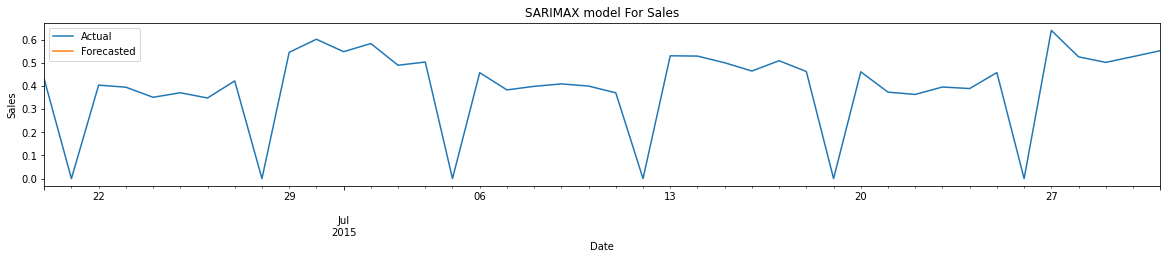

In [323]:
forecasted_timeseries_visualization(train_df_1_test['Sales'],train_df_1_test['SarimaxForecastedSales'],'Sales','SARIMAX')

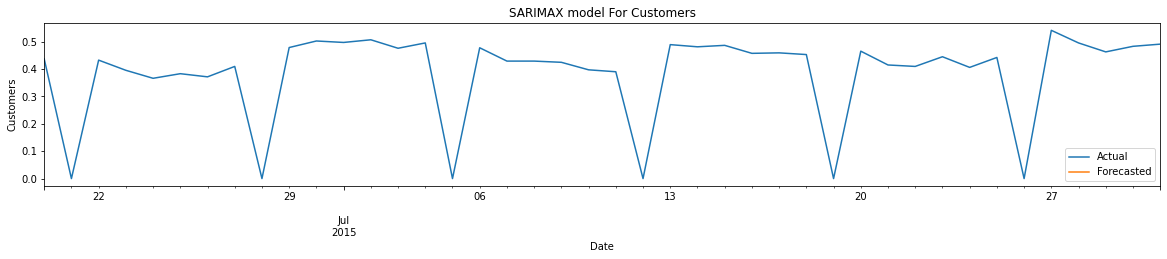

In [324]:
forecasted_timeseries_visualization(train_df_1_test['Customers'],train_df_1_test['SarimaxForecastedCustomers'],'Customers','SARIMAX')

In [325]:
train_df_1_test_temp=train_df_1_test.loc[(train_df_1_test.Sales!=0) & (train_df_1_test.Customers!=0),:]
d=summary(train_df_1_test_temp['Sales'], train_df_1_test_temp['SarimaxForecastedSales'],
       train_df_1_test_temp['Customers'], train_df_1_test_temp['SarimaxForecastedCustomers'],'Store-1','SARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

#### With m=365 for daily in seasonal_order, out of memory error is coming.
#### Tried with different combination of seasonal_order=(2, 1, 1, 12)/(1, 1, 1, 12)/(7, 0, 0, 12)/(0,1,0,12)/(0,2,0,12). For all the cases the values are coming as NaN.
#### We do not have any null value nor we have any date missing from the index list
#### Investigate later

In [ ]:
train_df_3=train_df.loc[train_df.Store==3,:]

In [ ]:
train_df_3.head(7)

In [ ]:
train_df_3.tail(7)

In [ ]:
train_df_3.shape

In [ ]:
pd.date_range(start = train_df_3.index.min(), end = train_df_3.index.max() ).difference(train_df_3.index)


In [ ]:
train_df_3=train_df_3.reset_index()
train_df_3.head()

## Time Series Visualizatin

In [ ]:
timeseries_visualization(train_df_3['Sales'],'Sales')

In [ ]:
timeseries_visualization(train_df_3['Customers'],'Customers')

In [ ]:
plot_seasonal_decomposition_period(train_df_3['Sales'],'Sales','additive')

In [ ]:
plot_seasonal_decomposition_period(train_df_3['Customers'],'Customers','additive')

In [ ]:
train_df_3[['Sales','Customers']].corr()

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(train_df_3['Sales'],train_df_3['Customers'])
plt.show()

#### Here we can see a strong relation between Sales and Customers.

### Causality testing

In [ ]:
causality_sales=grangercausalitytests(train_df_3[['Sales','Customers']].dropna(), 4)

In [ ]:
causality_customers=grangercausalitytests(train_df_3[['Customers','Sales']].dropna(), 4)

#### Here all the tests signify causality at significance level 0.05. All indicates that causality exists between sales and customers.
### Testing for stationary

In [ ]:
stationary_test(train_df_3[['Sales','Customers']])

#### 1%:-3.44,5%:-2.86,10%:-2.56 . If we compare the ADF statistic value, for both Sales and Customers, the value is less than the value of 1%. Which means we have to reject null hypothesis i.e. Series is not stationary.
#### Here we can see the P value is less than -.05 for both Sales and Customers, which implys both sereies are stationary. As our original data is stationary the degree of integration is 0 (I(0)).
#### Here we do not have any othe time series except Sales and Customers. Other variables are not time series components . They can be considered as exogenous variables.
### Autocoorelation and degree of integration

In [ ]:
plot_acf_pacf(train_df_3['Sales'],'Sales')

#### From ACF plot , we can find q=0 as we do not have a point after which autocorrelation dies down.
#### From PACF plot , we can choose p=27, as the highest lag where partial autocorrelation is significantly high. But executionof the model will be very high and taking 27 component while modeling, then there is very high chance of overfitting because of high complexity. Hence let's select 14 as p which is the last highest value.

In [ ]:
plot_acf_pacf(train_df_3['Customers'],'Customers')

#### From ACF plot , we can find q=0 as we do not have a point after which autocorrelation dies down.
#### From PACF plot , we can choose p=27, as the highest lag where partial autocorrelation is significantly high. But executionof the model will be very high and taking 27 component while modeling, then there is very high chance of overfitting because of high complexity. Hence let's select 14 as p which is the last highest value.

### Train and Test split

In [ ]:
train_df_3.shape

#### As we have to forecast for next 6 weeks daily , which is 42 days, lets keep last 42 records for testing and first 899 records for training

In [ ]:
train_len = 899
train_df_3_train=train_df_3.iloc[:train_len,:]
train_df_3_test=train_df_3.iloc[train_len:,:]

### Standardize Sales Customers

In [ ]:
train_df_3_train[['Sales','Customers']]=scaler.fit_transform(train_df_3_train[['Sales','Customers']])
train_df_3_train.head()

In [ ]:
#For test data
train_df_3_test[['Sales','Customers']]=scaler.transform(train_df_3_test[['Sales','Customers']])
train_df_3_test.head()

### VAR

In [ ]:
exog = train_df_3_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_3_train[['Sales', 'Customers']].astype(float)
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)
print(res.summary())

#### In the above output, the AIC drops to lowest at lag 14, then decrease at lag 15 .Let’s go with the lag 14.

In [ ]:
var_model_final = var_model.fit(14)
var_model_final.summary()

#### From here we found the lap(p) as 14. Perform Johansen test with P=14-1

In [ ]:
train_df_3['Sales']=train_df_3['Sales'].apply(lambda x:round(x))
train_df_3['Customers']=train_df_3['Customers'].apply(lambda x:round(x))

In [ ]:
cointegration_test(train_df_3[['Sales','Customers']],13)

In [ ]:
rank_result=select_coint_rank(train_df_3[['Sales','Customers']],-1,13)

In [ ]:
print(rank_result.rank)

#### Here we are checking for 2 time series i.e. N=1, we can see the rank is 1 (< N). Hence time series are cointegrated, it means they have a long run, statistically significant relationship.
#### As cointegration exists , we will be needing error correction techniques. We will implement VARMAX algorith, as the MA part of VARMAX will handle error correction.
#### Before that let's forecast and evaluate VAR model¶

In [ ]:
# Get the lag order
lag_order = var_model_final.k_ar
print(lag_order) 
forecast_input = train_df_3_train[['Sales','Customers']].values[-lag_order:]
forecast_input

In [ ]:
exog_test = train_df_3_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
fc = var_model_final.forecast(y=forecast_input, steps=42,exog_future=exog_test)
var_forecast = pd.DataFrame(fc, index=train_df_3_test.index, columns=['Sales','Customers'])
var_forecast.head()

In [ ]:
train_df_3_test['VarForecastedSales']=var_forecast.Sales
train_df_3_test['VarForecastedCustomers']=var_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_3_test['Sales'],train_df_3_test['VarForecastedSales'],'Sales','VAR')

In [ ]:
forecasted_timeseries_visualization(train_df_3_test['Customers'],train_df_3_test['VarForecastedCustomers'],'Customers','VAR')

In [ ]:
train_df_3_test_temp=train_df_3_test.loc[(train_df_3_test.Sales!=0) & (train_df_3_test.Customers!=0),:]
d=summary(train_df_3_test_temp['Sales'], train_df_3_test_temp['VarForecastedSales'],
       train_df_3_test_temp['Customers'], train_df_3_test_temp['VarForecastedCustomers'],'Store-3','VAR')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

### VARMAX
#### From above PACF and ACF plot we found, p=14 and q=0.

In [ ]:
%%time
exog = train_df_3_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_3_train[['Sales', 'Customers']].astype(float)
varmax_model = sm.tsa.VARMAX(endog, order=(14,0), exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

In [ ]:
exog_test = train_df_3_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog_test= train_df_3_test[['Sales','Customers']]
varmax_fc = varmax_model_fit.predict(start=train_df_3_test.index.min(),end=train_df_3_test.index.max(),exog=exog_test)
varmax_forecast = pd.DataFrame(varmax_fc, index=train_df_3_test.index, columns=['Sales','Customers'])
varmax_forecast.head()

In [ ]:
train_df_3_test['VarmaxForecastedSales']=varmax_forecast.Sales
train_df_3_test['VarmaxForecastedCustomers']=varmax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_3_test['Sales'],train_df_3_test['VarmaxForecastedSales'],'Sales','VARMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_3_test['Customers'],train_df_3_test['VarmaxForecastedCustomers'],'Customers','VARMAX')

In [ ]:
train_df_3_test_temp=train_df_3_test.loc[(train_df_3_test.Sales!=0) & (train_df_3_test.Customers!=0),:]
d=summary(train_df_3_test_temp['Sales'], train_df_3_test_temp['VarmaxForecastedSales'],
       train_df_3_test_temp['Customers'], train_df_3_test_temp['VarmaxForecastedCustomers'],'Store-3','VARMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

## ARIMA¶

In [ ]:
%%time

#With exogenous and for sale
exog = train_df_3_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_3_train[['Sales']].astype(float)
arimax_model = ARIMA(endog, order=(14,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
exog_test = train_df_3_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)

arimax_sales = arimax_model_fit.predict(start=train_df_3_test.index.min(),end=train_df_3_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_sales, index=train_df_3_test.index, columns=['Sales'])
arimax_forecast.head()

In [ ]:
train_df_3_test['ArimaxForecastedSales']=arimax_forecast.Sales

In [ ]:
exog = train_df_3_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_3_train[['Customers']].astype(float)
arimax_model = ARIMA(endog, order=(14,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
arimax_customers = arimax_model_fit.predict(start=train_df_3_test.index.min(),end=train_df_3_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_customers, index=train_df_3_test.index, columns=['Customers'])
arimax_forecast.head()

In [ ]:
train_df_3_test['ArimaxForecastedCustomes']=arimax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_3_test['Sales'],train_df_3_test['ArimaxForecastedSales'],'Sales','ARIMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_3_test['Customers'],train_df_3_test['ArimaxForecastedCustomes'],'Customers','ARIMAX')

In [ ]:
train_df_3_test_temp=train_df_3_test.loc[(train_df_3_test.Sales!=0) & (train_df_3_test.Customers!=0),:]
d=summary(train_df_3_test_temp['Sales'], train_df_3_test_temp['ArimaxForecastedSales'],
       train_df_3_test_temp['Customers'], train_df_3_test_temp['ArimaxForecastedCustomes'],'Store-3','ARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

In [ ]:
%%time

#Without exogenous and for sale
exog = train_df_3_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_3_train[['Sales']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())


In [ ]:
sarimax_sales = sarima_model_fit.predict(start=train_df_3_test.index.min(),end=train_df_3_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_sales, index=train_df_3_test.index, columns=['Sales'])
sarimax_forecast.head()

In [ ]:
train_df_3_test['SarimaxForecastedSales']=sarimax_forecast.Sales

In [ ]:
%%time

#Without exogenous and for sale
exog = train_df_3_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_3_train[['Customers']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())


In [ ]:
sarimax_customers = sarima_model_fit.predict(start=train_df_3_test.index.min(),end=train_df_3_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_customers, index=train_df_3_test.index, columns=['Customers'])
sarimax_forecast.head()

In [ ]:
train_df_3_test['SarimaxForecastedCustomers']=sarimax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_3_test['Sales'],train_df_3_test['SarimaxForecastedSales'],'Sales','SARIMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_3_test['Customers'],train_df_3_test['SarimaxForecastedCustomers'],'Customers','SARIMAX')

In [ ]:

train_df_3_test_temp=train_df_3_test.loc[(train_df_3_test.Sales!=0) & (train_df_3_test.Customers!=0),:]
d=summary(train_df_3_test_temp['Sales'], train_df_3_test_temp['SarimaxForecastedSales'],
       train_df_3_test_temp['Customers'], train_df_3_test_temp['SarimaxForecastedCustomers'],'Store-3','SARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(25)

In [ ]:
# For store 8
train_df_8=train_df.loc[train_df.Store==8,:]

In [ ]:
train_df_8.shape

In [ ]:
timeseries_visualization(train_df_8['Sales'],'Sales')

In [ ]:
timeseries_visualization(train_df_8['Customers'],'Customers')

In [ ]:
plot_seasonal_decomposition(train_df_8['Sales'],'Sales','additive')

In [ ]:
plot_seasonal_decomposition(train_df_8['Customers'],'Customers','additive')

In [ ]:
train_df_8[['Sales','Customers']].corr()

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(train_df_8['Sales'],train_df_8['Customers'])
plt.show()

#### Here we can see a strong relation between Sales and Customers.
## Causality testing

In [ ]:
causality_sales=grangercausalitytests(train_df_8[['Sales','Customers']].dropna(), 4)

In [ ]:
causality_customers=grangercausalitytests(train_df_8[['Customers','Sales']].dropna(), 4)

#### Here all the tests signify causality at significance level 0.05. All indicates that causality exists between sales and customers.
### Testing for stationary

In [ ]:
stationary_test(train_df_8[['Sales','Customers']])

#### 1%:-3.44,5%:-2.86,10%:-2.56 . If we compare the ADF statistic value, for both Sales and Customers, the value is less than the value of 1%. Which means we have to reject null hypothesis i.e. Series is not stationary.
#### Here we can see the P value is less than -.05 for both Sales and Customers, which implys both sereies are stationary. As our original data is stationary the degree of integration is 0 (I(0)).
#### Here we do not have any othe time series except Sales and Customers. Other variables are not time series components . They can be considered as exogenous variables.
### Autocoorelation and degree of integration

In [ ]:
plot_acf_pacf(train_df_8['Sales'],'Sales')

#### From ACF plot , we can find q=0 as we do not have a point after which autocorrelation dies down.
#### From PACF plot , we can choose p=27, as the highest lag where partial autocorrelation is significantly high. But executionof the model will be very high and taking 27 component while modeling, then there is very high chance of overfitting because of high complexity. Hence let's select 14 as p which is the last highest value.

In [ ]:
plot_acf_pacf(train_df_8['Customers'],'Customers')

##### Same as Sales
### Train and Test split

In [ ]:
train_df_8.shape

In [ ]:
train_len = 900
train_df_8_train=train_df_8.iloc[:train_len,:]
train_df_8_test=train_df_8.iloc[train_len:,:]

### Standardize Sales Customers

In [ ]:
train_df_8_train[['Sales','Customers']]=scaler.fit_transform(train_df_8_train[['Sales','Customers']])
train_df_8_train.head()

In [ ]:
#For test data
train_df_8_test[['Sales','Customers']]=scaler.transform(train_df_8_test[['Sales','Customers']])
train_df_8_test.head()

### VAR

In [ ]:
exog = train_df_8_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_8_train[['Sales', 'Customers']].astype(float)
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)
print(res.summary())

#### In the above output, the AIC drops to lowest at lag 14, then same at lag 15 .Let’s go with the lag 14.

In [ ]:
var_model_final = var_model.fit(14)
var_model_final.summary()

#### From here we found the lap(p) as 14. Perform Johansen test with P=14-1

In [ ]:
train_df_8['Sales']=train_df_8['Sales'].apply(lambda x:round(x))
train_df_8['Customers']=train_df_8['Customers'].apply(lambda x:round(x))

In [ ]:
cointegration_test(train_df_8[['Sales','Customers']],13)

In [ ]:
rank_result=select_coint_rank(train_df_8[['Sales','Customers']],-1,13)


In [ ]:
print(rank_result.rank)

#### Here we are checking for 2 time series i.e. N=1, we can see the rank is 1 (< N). Hence time series are cointegrated, it means they have a long run, statistically significant relationship.
##### As cointegration exists , we will be needing error correction techniques. We will implement VARMAX algorith, as the MA part of VARMAX will handle error correction.
#### Before that let's forecast and evaluate VAR model¶¶

In [ ]:
# Get the lag order
lag_order = var_model_final.k_ar
print(lag_order) 
forecast_input = train_df_8_train[['Sales','Customers']].values[-lag_order:]
forecast_input

In [ ]:
exog_test = train_df_8_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
fc = var_model_final.forecast(y=forecast_input, steps=42,exog_future=exog_test)
var_forecast = pd.DataFrame(fc, index=train_df_8_test.index, columns=['Sales','Customers'])
var_forecast.head()

In [ ]:
train_df_8_test['VarForecastedSales']=var_forecast.Sales
train_df_8_test['VarForecastedCustomers']=var_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_8_test['Sales'],train_df_8_test['VarForecastedSales'],'Sales','VAR')

In [ ]:
forecasted_timeseries_visualization(train_df_8_test['Customers'],train_df_8_test['VarForecastedCustomers'],'Customers','VAR')

In [ ]:
train_df_8_test_temp=train_df_8_test.loc[(train_df_8_test.Sales!=0) & (train_df_8_test.Customers!=0),:]
d=summary(train_df_8_test_temp['Sales'], train_df_8_test_temp['VarForecastedSales'],
       train_df_8_test_temp['Customers'], train_df_8_test_temp['VarForecastedCustomers'],'Store-8','VAR')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

### VARMAX
#### From above PACF and ACF plot we found, p=14 and q=0.

In [ ]:
%%time
exog = train_df_8_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_8_train[['Sales', 'Customers']].astype(float)
varmax_model = sm.tsa.VARMAX(endog, order=(7,0),  exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

In [ ]:
exog_test = train_df_8_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog_test= train_df_8_test[['Sales','Customers']]
varmax_fc = varmax_model_fit.predict(start=train_df_8_test.index.min(),end=train_df_8_test.index.max(),exog=exog_test)
varmax_forecast = pd.DataFrame(varmax_fc, index=train_df_8_test.index, columns=['Sales','Customers'])
varmax_forecast.head()

In [ ]:
train_df_8_test['VarmaxForecastedSales']=varmax_forecast.Sales
train_df_8_test['VarmaxForecastedCustomers']=varmax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_8_test['Sales'],train_df_8_test['VarmaxForecastedSales'],'Sales','VARMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_8_test['Customers'],train_df_8_test['VarmaxForecastedCustomers'],'Customers','VARMAX')

In [ ]:
train_df_8_test_temp=train_df_8_test.loc[(train_df_8_test.Sales!=0) & (train_df_8_test.Customers!=0),:]
d=summary(train_df_8_test_temp['Sales'], train_df_8_test_temp['VarmaxForecastedSales'],
       train_df_8_test_temp['Customers'], train_df_8_test_temp['VarmaxForecastedCustomers'],'Store-8','VARMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

### ARIMA

In [ ]:
%%time

#With exogenous and for sale
exog = train_df_8_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_8_train[['Sales']].astype(float)
arimax_model = ARIMA(endog, order=(7,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
exog_test = train_df_8_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)

arimax_sales = arimax_model_fit.predict(start=train_df_8_test.index.min(),end=train_df_8_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_sales, index=train_df_8_test.index, columns=['Sales'])
arimax_forecast.head()

In [ ]:
train_df_8_test['ArimaxForecastedSales']=arimax_forecast.Sales

In [ ]:
exog = train_df_8_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_8_train[['Customers']].astype(float)
arimax_model = ARIMA(endog, order=(7,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
arimax_customers = arimax_model_fit.predict(start=train_df_8_test.index.min(),end=train_df_8_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_customers, index=train_df_8_test.index, columns=['Customers'])
arimax_forecast.head()

In [ ]:
train_df_8_test['ArimaxForecastedCustomes']=arimax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_8_test['Sales'],train_df_8_test['ArimaxForecastedSales'],'Sales','ARIMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_8_test['Customers'],train_df_8_test['ArimaxForecastedCustomes'],'Customers','ARIMAX')

In [ ]:
train_df_8_test_temp=train_df_8_test.loc[(train_df_8_test.Sales!=0) & (train_df_8_test.Customers!=0),:]
d=summary(train_df_8_test_temp['Sales'], train_df_8_test_temp['ArimaxForecastedSales'],
       train_df_8_test_temp['Customers'], train_df_8_test_temp['ArimaxForecastedCustomes'],'Store-8','ARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

In [ ]:
%%time

#Without exogenous and for sale
exog = train_df_8_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_8_train[['Sales']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

In [ ]:
sarimax_sales = sarima_model_fit.predict(start=train_df_8_test.index.min(),end=train_df_8_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_sales, index=train_df_8_test.index, columns=['Sales'])
sarimax_forecast.head()


In [ ]:
train_df_8_test['SarimaxForecastedSales']=sarimax_forecast.Sales

In [ ]:
%%time

#Without exogenous and for sale
exog = train_df_8_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_8_train[['Customers']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

In [ ]:
sarimax_customers = sarima_model_fit.predict(start=train_df_8_test.index.min(),end=train_df_8_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_customers, index=train_df_8_test.index, columns=['Customers'])
sarimax_forecast.head()

In [ ]:
train_df_8_test['SarimaxForecastedCustomers']=sarimax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_8_test['Sales'],train_df_8_test['SarimaxForecastedSales'],'Sales','SARIMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_8_test['Customers'],train_df_8_test['SarimaxForecastedCustomers'],'Customers','SARIMAX')

In [ ]:
train_df_8_test_temp=train_df_8_test.loc[(train_df_8_test.Sales!=0) & (train_df_8_test.Customers!=0),:]
d=summary(train_df_8_test_temp['Sales'], train_df_8_test_temp['SarimaxForecastedSales'],
       train_df_8_test_temp['Customers'], train_df_8_test_temp['SarimaxForecastedCustomers'],'Store-8','SARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(30)

In [ ]:
train_df_9=train_df.loc[train_df.Store==9,:]

In [ ]:
train_df_9.shape

## Time Series Visualization

In [ ]:
timeseries_visualization(train_df_9['Sales'],'Sales')

In [ ]:
timeseries_visualization(train_df_9['Customers'],'Customers')

In [ ]:
plot_seasonal_decomposition(train_df_9['Sales'],'Sales','additive')

In [ ]:
plot_seasonal_decomposition(train_df_9['Customers'],'Customers','additive')

In [ ]:
train_df_9[['Sales','Customers']].corr()

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(train_df_9['Sales'],train_df_9['Customers'])
plt.show()

#### Here we can see a strong relation between Sales and Customers.
## Causality testing

In [ ]:
causality_sales=grangercausalitytests(train_df_9[['Sales','Customers']].dropna(), 4)

In [ ]:
causality_customers=grangercausalitytests(train_df_9[['Customers','Sales']].dropna(), 4)

#### Here all the tests signify causality at significance level 0.05. All indicates that causality exists between sales and customers.
#### Testing for stationary

In [ ]:
stationary_test(train_df_9[['Sales','Customers']])

#### 1%:-3.44,5%:-2.86,10%:-2.56 . If we compare the ADF statistic value, for both Sales and Customers, the value is less than the value of 1%. Which means we have to reject null hypothesis i.e. Series is not stationary.
#### Here we can see the P value is less than -.05 for both Sales and Customers, which implys both sereies are stationary. As our original data is stationary the degree of integration is 0 (I(0)).
#### Here we do not have any othe time series except Sales and Customers. Other variables are not time series components . They can be considered as exogenous variables.¶

#### Autocoorelation and degree of integration

In [ ]:
plot_acf_pacf(train_df_9['Sales'],'Sales')

#### From ACF plot , we can find q=0 as we do not have a point after which autocorrelation dies down.
#### From PACF plot , we can choose p=49, as the highest lag where partial autocorrelation is significantly high. But executionof the model will be very high and taking 49 component while modeling, then there is very high chance of overfitting because of high complexity. Hence let's select 7 as p which is the last highest value.

In [ ]:
plot_acf_pacf(train_df_9['Customers'],'Customers')

#### From ACF plot , we can find q=0 as we do not have a point after which autocorrelation dies down.
#### From PACF plot , we can choose p=49, as the highest lag where partial autocorrelation is significantly high. But executionof the model will be very high and taking 49 component while modeling, then there is very high chance of overfitting because of high complexity. Hence let's select 7 as p which is the last highest value.

#### Train and Test split¶

In [ ]:
train_len = 900
train_df_9_train=train_df_9.iloc[:train_len,:]
train_df_9_test=train_df_9.iloc[train_len:,:]

### Standardize Sales Customers

In [ ]:
train_df_9_train[['Sales','Customers']]=scaler.fit_transform(train_df_9_train[['Sales','Customers']])
train_df_9_train.head()

In [ ]:
#For test data
train_df_9_test[['Sales','Customers']]=scaler.transform(train_df_9_test[['Sales','Customers']])
train_df_9_test.head()

### VAR

In [ ]:
exog = train_df_9_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_9_train[['Sales', 'Customers']].astype(float)
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)
print(res.summary())

#### In the above output, the AIC drops to lowest at lag 14, then decrease at lag 15 .Let’s go with the lag 14.

In [ ]:
var_model_final = var_model.fit(14)
var_model_final.summary()

#### From here we found the lap(p) as 14. Perform Johansen test with P=14-1¶

In [ ]:
train_df_9['Sales']=train_df_9['Sales'].apply(lambda x:round(x))
train_df_9['Customers']=train_df_9['Customers'].apply(lambda x:round(x))

In [ ]:
cointegration_test(train_df_9[['Sales','Customers']],13)

In [ ]:
rank_result=select_coint_rank(train_df_9[['Sales','Customers']],-1,13)

In [ ]:
print(rank_result.rank)

#### Here we are checking for 2 time series i.e. N=1, we can see the rank is 1 (< N). Hence time series are cointegrated, it means they have a long run, statistically significant relationship.
#### As cointegration exists , we will be needing error correction techniques. We will implement VARMAX algorith, as the MA part of VARMAX will handle error correction.
#### Before that let's forecast and evaluate VAR model¶

In [ ]:
# Get the lag order
lag_order = var_model_final.k_ar
print(lag_order) 
forecast_input = train_df_9_train[['Sales','Customers']].values[-lag_order:]
forecast_input

In [ ]:
exog_test = train_df_9_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
fc = var_model_final.forecast(y=forecast_input, steps=42,exog_future=exog_test)
var_forecast = pd.DataFrame(fc, index=train_df_9_test.index, columns=['Sales','Customers'])
var_forecast.head()

In [ ]:
train_df_9_test['VarForecastedSales']=var_forecast.Sales
train_df_9_test['VarForecastedCustomers']=var_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_9_test['Sales'],train_df_9_test['VarForecastedSales'],'Sales','VAR')

In [ ]:
forecasted_timeseries_visualization(train_df_9_test['Customers'],train_df_9_test['VarForecastedCustomers'],'Customers','VAR')

In [ ]:
train_df_9_test_temp=train_df_9_test.loc[(train_df_9_test.Sales!=0) & (train_df_9_test.Customers!=0),:]
d=summary(train_df_9_test_temp['Sales'], train_df_9_test_temp['VarForecastedSales'],
       train_df_9_test_temp['Customers'], train_df_9_test_temp['VarForecastedCustomers'],'Store-9','VAR')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

### VARMAX
#### From above PACF and ACF plot we found, p=14 and q=0.

In [ ]:
%%time
exog = train_df_9_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_9_train[['Sales', 'Customers']].astype(float)
varmax_model = sm.tsa.VARMAX(endog, order=(7,0),  exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

In [ ]:
exog_test = train_df_9_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog_test= train_df_9_test[['Sales','Customers']]
varmax_fc = varmax_model_fit.predict(start=train_df_9_test.index.min(),end=train_df_9_test.index.max(),exog=exog_test)
varmax_forecast = pd.DataFrame(varmax_fc, index=train_df_9_test.index, columns=['Sales','Customers'])
varmax_forecast.head()

In [ ]:
train_df_9_test['VarmaxForecastedSales']=varmax_forecast.Sales
train_df_9_test['VarmaxForecastedCustomers']=varmax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_9_test['Sales'],train_df_9_test['VarmaxForecastedSales'],'Sales','VARMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_9_test['Customers'],train_df_9_test['VarmaxForecastedCustomers'],'Customers','VARMAX')

In [ ]:
train_df_9_test_temp=train_df_9_test.loc[(train_df_9_test.Sales!=0) & (train_df_9_test.Customers!=0),:]
d=summary(train_df_9_test_temp['Sales'], train_df_9_test_temp['VarmaxForecastedSales'],
       train_df_9_test_temp['Customers'], train_df_9_test_temp['VarmaxForecastedCustomers'],'Store-9','VARMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

In [ ]:
summary_df.head(20)

### ARIMA¶

In [ ]:
%%time

#With exogenous and for sale
exog = train_df_9_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_9_train[['Sales']].astype(float)
arimax_model = ARIMA(endog, order=(7,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
exog_test = train_df_9_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)

arimax_sales = arimax_model_fit.predict(start=train_df_9_test.index.min(),end=train_df_9_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_sales, index=train_df_9_test.index, columns=['Sales'])
arimax_forecast.head()

In [ ]:
train_df_9_test['ArimaxForecastedSales']=arimax_forecast.Sales

In [ ]:
exog = train_df_9_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_9_train[['Customers']].astype(float)
arimax_model = ARIMA(endog, order=(7,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
arimax_customers = arimax_model_fit.predict(start=train_df_9_test.index.min(),end=train_df_9_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_customers, index=train_df_9_test.index, columns=['Customers'])
arimax_forecast.head()

In [ ]:
train_df_9_test['ArimaxForecastedCustomes']=arimax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_9_test['Sales'],train_df_9_test['ArimaxForecastedSales'],'Sales','ARIMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_9_test['Customers'],train_df_9_test['ArimaxForecastedCustomes'],'Customers','ARIMAX')

In [ ]:
train_df_9_test_temp=train_df_9_test.loc[(train_df_9_test.Sales!=0) & (train_df_9_test.Customers!=0),:]
d=summary(train_df_9_test_temp['Sales'], train_df_9_test_temp['ArimaxForecastedSales'],
       train_df_9_test_temp['Customers'], train_df_9_test_temp['ArimaxForecastedCustomes'],'Store-9','ARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(25)

In [ ]:
%%time

#Without exogenous and for sale
exog = train_df_9_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_9_train[['Sales']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

In [ ]:
sarimax_sales = sarima_model_fit.predict(start=train_df_9_test.index.min(),end=train_df_9_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_sales, index=train_df_9_test.index, columns=['Sales'])
sarimax_forecast.head()


In [ ]:
train_df_9_test['SarimaxForecastedSales']=sarimax_forecast.Sales

In [ ]:
%%time

#Without exogenous and for sale
exog = train_df_9_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_9_train[['Customers']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())


In [ ]:
sarimax_customers = sarima_model_fit.predict(start=train_df_9_test.index.min(),end=train_df_9_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_customers, index=train_df_9_test.index, columns=['Customers'])
sarimax_forecast.head()

In [ ]:
train_df_9_test['SarimaxForecastedCustomers']=sarimax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_9_test['Sales'],train_df_9_test['SarimaxForecastedSales'],'Sales','SARIMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_9_test['Customers'],train_df_9_test['SarimaxForecastedCustomers'],'Customers','SARIMAX')

In [ ]:
train_df_9_test_temp=train_df_9_test.loc[(train_df_9_test.Sales!=0) & (train_df_9_test.Customers!=0),:]
d=summary(train_df_9_test_temp['Sales'], train_df_9_test_temp['SarimaxForecastedSales'],
       train_df_9_test_temp['Customers'], train_df_9_test_temp['SarimaxForecastedCustomers'],'Store-9','SARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(50)

In [ ]:
train_df_13=train_df.loc[train_df.Store==13,:]

In [ ]:
train_df_13.head()

In [ ]:
train_df_13.shape

In [ ]:
pd.date_range(start = train_df_13.index.min(), end = train_df_13.index.max() ).difference(train_df_13.index)


In [ ]:
train_df_13=train_df_13.reset_index()
train_df_13.head()

### Time Series Visualizati0n

In [ ]:
timeseries_visualization(train_df_13['Sales'],'Sales')

In [ ]:
timeseries_visualization(train_df_13['Customers'],'Customers')

In [ ]:
plot_seasonal_decomposition_period(train_df_13['Sales'],'Sales','additive')

In [ ]:
plot_seasonal_decomposition_period(train_df_13['Customers'],'Customers','additive')

In [ ]:
train_df_13[['Sales','Customers']].corr()

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(train_df_13['Sales'],train_df_13['Customers'])
plt.show()

#### Here we can see a strong relation between Sales and Customers.
#### Causality testing

In [ ]:
causality_sales=grangercausalitytests(train_df_13[['Sales','Customers']].dropna(), 4)

In [ ]:
causality_customers=grangercausalitytests(train_df_13[['Customers','Sales']].dropna(), 4)

#### Here all the tests signify causality at significance level 0.05. All indicates that causality exists between sales and customers.
### Testing for stationary

In [ ]:
stationary_test(train_df_13[['Sales','Customers']])

##### 1%:-3.44,5%:-2.86,10%:-2.56 . If we compare the ADF statistic value, for both Sales and Customers, the value is less than the value of 1%. Which means we have to reject null hypothesis i.e. Series is not stationary.
#### Here we can see the P value is less than -.05 for both Sales and Customers, which implys both sereies are stationary. As our original data is stationary the degree of integration is 0 (I(0)).
#### Here we do not have any othe time series except Sales and Customers. Other variables are not time series components . They can be considered as exogenous variables.
### Autocoorelation and degree of integration¶

In [ ]:
plot_acf_pacf(train_df_13['Sales'],'Sales')

#### From ACF plot , we can find q=0 as we do not have a point after which autocorrelation dies down.
#### From PACF plot , we can choose p=28, as the highest lag where partial autocorrelation is significantly high. But executionof the model will be very high and taking 28 component while modeling, then there is very high chance of overfitting because of high complexity. Hence let's select 14 as p which is the last highest value.

In [ ]:
plot_acf_pacf(train_df_13['Customers'],'Customers')

#### From ACF plot , we can find q=0 as we do not have a point after which autocorrelation dies down.
#### From PACF plot , we can choose p=28, as the highest lag where partial autocorrelation is significantly high. But executionof the model will be very high and taking 28 component while modeling, then there is very high chance of overfitting because of high complexity. Hence let's select 14 as p which is the last highest value.
### Train and Test split

In [ ]:
train_df_13.shape

#### As we have to forecast for next 6 weeks daily , which is 42 days, lets keep last 42 records for testing and first 899 records for training

In [ ]:
train_len = 716
train_df_13_train=train_df_13.iloc[:train_len,:]
train_df_13_test=train_df_13.iloc[train_len:,:]

#### Standardize Sales Customers

In [ ]:
train_df_13_train[['Sales','Customers']]=scaler.fit_transform(train_df_13_train[['Sales','Customers']])
train_df_13_train.head()

In [ ]:
#For test data
train_df_13_test[['Sales','Customers']]=scaler.transform(train_df_13_test[['Sales','Customers']])
train_df_13_test.head()

### VAR

In [ ]:
exog = train_df_13_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_13_train[['Sales', 'Customers']].astype(float)
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)
print(res.summary())

In the above output, the AIC drops to lowest at lag 11, then increase or remains same .Let’s go with the lag 11.


In [ ]:
var_model_final = var_model.fit(11)
var_model_final.summary()

#### From here we found the lap(p) as 11. Perform Johansen test with P=11-1¶

In [ ]:
train_df_13['Sales']=train_df_13['Sales'].apply(lambda x:round(x))
train_df_13['Customers']=train_df_13['Customers'].apply(lambda x:round(x))

In [ ]:
cointegration_test(train_df_13[['Sales','Customers']],10)

In [ ]:
rank_result=select_coint_rank(train_df_13[['Sales','Customers']],-1,11)

In [ ]:
print(rank_result.rank)

#### Here we are checking for 2 time series i.e. N=1, we can see the rank is 1 (< N). Hence time series are cointegrated, it means they have a long run, statistically significant relationship.
#### As cointegration exists , we will be needing error correction techniques. We will implement VARMAX algorith, as the MA part of VARMAX will handle error correction.
#### Before that let's forecast and evaluate VAR model¶


In [ ]:
# Get the lag order
lag_order = var_model_final.k_ar
print(lag_order) 
forecast_input = train_df_13_train[['Sales','Customers']].values[-lag_order:]
forecast_input

In [ ]:
exog_test = train_df_13_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
fc = var_model_final.forecast(y=forecast_input, steps=42,exog_future=exog_test)
var_forecast = pd.DataFrame(fc, index=train_df_13_test.index, columns=['Sales','Customers'])
var_forecast.head()

In [ ]:
train_df_13_test['VarForecastedSales']=var_forecast.Sales
train_df_13_test['VarForecastedCustomers']=var_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_13_test['Sales'],train_df_13_test['VarForecastedSales'],'Sales','VAR')

In [ ]:
forecasted_timeseries_visualization(train_df_13_test['Customers'],train_df_13_test['VarForecastedCustomers'],'Customers','VAR')

In [ ]:
train_df_13_test_temp=train_df_13_test.loc[(train_df_13_test.Sales!=0) & (train_df_13_test.Customers!=0),:]
d=summary(train_df_13_test_temp['Sales'], train_df_13_test_temp['VarForecastedSales'],
       train_df_13_test_temp['Customers'], train_df_13_test_temp['VarForecastedCustomers'],'Store-13','VAR')
summary_df = pd.concat([summary_df, d])
summary_df.head(20)

### VARMAX
##### From above PACF and ACF plot we found, p=14 and q=0

In [ ]:
%%time
exog = train_df_13_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_13_train[['Sales', 'Customers']].astype(float)
varmax_model = sm.tsa.VARMAX(endog, order=(14,0), exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

In [ ]:
exog_test = train_df_13_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog_test= train_df_13_test[['Sales','Customers']]
varmax_fc = varmax_model_fit.predict(start=train_df_13_test.index.min(),end=train_df_13_test.index.max(),exog=exog_test)
varmax_forecast = pd.DataFrame(varmax_fc, index=train_df_13_test.index, columns=['Sales','Customers'])
varmax_forecast.head()

In [ ]:
train_df_13_test['VarmaxForecastedSales']=varmax_forecast.Sales
train_df_13_test['VarmaxForecastedCustomers']=varmax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_13_test['Sales'],train_df_13_test['VarmaxForecastedSales'],'Sales','VARMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_13_test['Customers'],train_df_13_test['VarmaxForecastedCustomers'],'Customers','VARMAX')

In [ ]:
train_df_13_test_temp=train_df_13_test.loc[(train_df_13_test.Sales!=0) & (train_df_13_test.Customers!=0),:]
d=summary(train_df_13_test_temp['Sales'], train_df_13_test_temp['VarmaxForecastedSales'],
       train_df_13_test_temp['Customers'], train_df_13_test_temp['VarmaxForecastedCustomers'],'Store-13','VARMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(25)

### ARIMA

In [ ]:
%%time

#With exogenous and for sale
exog = train_df_13_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_13_train[['Sales']].astype(float)
arimax_model = ARIMA(endog, order=(14,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
exog_test = train_df_13_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)

arimax_sales = arimax_model_fit.predict(start=train_df_13_test.index.min(),end=train_df_13_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_sales, index=train_df_13_test.index, columns=['Sales'])
arimax_forecast.head()

In [ ]:
train_df_13_test['ArimaxForecastedSales']=arimax_forecast.Sales

In [ ]:
exog = train_df_13_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_13_train[['Customers']].astype(float)
arimax_model = ARIMA(endog, order=(14,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
arimax_customers = arimax_model_fit.predict(start=train_df_13_test.index.min(),end=train_df_13_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_customers, index=train_df_13_test.index, columns=['Customers'])
arimax_forecast.head()

In [ ]:
train_df_13_test['ArimaxForecastedCustomes']=arimax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_13_test['Sales'],train_df_13_test['ArimaxForecastedSales'],'Sales','ARIMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_13_test['Customers'],train_df_13_test['ArimaxForecastedCustomes'],'Customers','ARIMAX')

In [ ]:
train_df_13_test_temp=train_df_13_test.loc[(train_df_13_test.Sales!=0) & (train_df_13_test.Customers!=0),:]
d=summary(train_df_13_test_temp['Sales'], train_df_13_test_temp['ArimaxForecastedSales'],
       train_df_13_test_temp['Customers'], train_df_13_test_temp['ArimaxForecastedCustomes'],'Store-13','ARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(25)

In [ ]:
train_df_25=train_df.loc[train_df.Store==25,:]

In [ ]:
train_df_25.head()

In [ ]:
train_df_25.shape

In [ ]:
pd.date_range(start = train_df_25.index.min(), end = train_df_25.index.max() ).difference(train_df_25.index)


In [ ]:
train_df_25=train_df_25.reset_index()
train_df_25.head()

### Time Series Visualization¶

In [ ]:
timeseries_visualization(train_df_25['Sales'],'Sales')

In [ ]:
timeseries_visualization(train_df_25['Customers'],'Customers')

In [ ]:
plot_seasonal_decomposition_period(train_df_25['Sales'],'Sales','additive')

In [ ]:
plot_seasonal_decomposition_period(train_df_25['Customers'],'Customers','additive')

In [ ]:
train_df_25[['Sales','Customers']].corr()

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(train_df_25['Sales'],train_df_25['Customers'])
plt.show()

#### Here we can see a strong relation between Sales and Customers.
### Causality testing¶

In [ ]:
causality_sales=grangercausalitytests(train_df_25[['Sales','Customers']].dropna(), 4)

In [ ]:
causality_customers=grangercausalitytests(train_df_25[['Customers','Sales']].dropna(), 4)

#### Here all the tests signify causality at significance level 0.05. All indicates that causality exists between sales and customers.
### Testing for stationary

In [ ]:
stationary_test(train_df_25[['Sales','Customers']])

#### 1%:-3.44,5%:-2.86,10%:-2.56 . If we compare the ADF statistic value, for both Sales and Customers, the value is less than the value of 1%. Which means we have to reject null hypothesis i.e. Series is not stationary.
#### Here we can see the P value is less than -.05 for both Sales and Customers, which implys both sereies are stationary. As our original data is stationary the degree of integration is 0 (I(0)).
#### Here we do not have any othe time series except Sales and Customers. Other variables are not time series components . They can be considered as exogenous variables.
### Autocoorelation and degree of integration

In [ ]:
plot_acf_pacf(train_df_25['Sales'],'Sales')

From ACF plot , we can find q=27 after which autocorrelation dies down. But this value will overft the model. So we will go with 14.
From PACF plot , p=7.

In [ ]:
plot_acf_pacf(train_df_25['Customers'],'Customers')

#### Same as Sales

### Train and Test split

In [ ]:
train_df_25.shape

In [ ]:
train_len = 890-42
train_df_25_train=train_df_25.iloc[:train_len,:]
train_df_25_test=train_df_25.iloc[train_len:,:]

### Standardize Sales Customers

In [ ]:
train_df_25_train[['Sales','Customers']]=scaler.fit_transform(train_df_25_train[['Sales','Customers']])
train_df_25_train.head()

In [ ]:
#For test data
train_df_25_test[['Sales','Customers']]=scaler.transform(train_df_25_test[['Sales','Customers']])
train_df_25_test.head()

### VAR¶

In [ ]:
exog = train_df_25_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_25_train[['Sales', 'Customers']].astype(float)
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)
print(res.summary())

#### In the above output, the AIC drops to lowest at lag 7, then increases at lag 8.Let’s go with the lag 7

In [ ]:
var_model_final = var_model.fit(7)
var_model_final.summary()

#### From here we found the lap(p) as 7. Perform Johansen test with P=7-1

In [ ]:
train_df_25['Sales']=train_df_25['Sales'].apply(lambda x:round(x))
train_df_25['Customers']=train_df_25['Customers'].apply(lambda x:round(x))

In [ ]:
cointegration_test(train_df_25[['Sales','Customers']],6)

In [ ]:
rank_result=select_coint_rank(train_df_25[['Sales','Customers']],-1,6)

In [ ]:
print(rank_result.rank)

#### Here we are checking for 2 time series i.e. N=1, we can see the rank is 1 (< N). Hence time series are cointegrated, it means they have a long run, statistically significant relationship.
#### As cointegration exists , we will be needing error correction techniques. We will implement VARMAX algorith, as the MA part of VARMAX will handle error correction.
#### Before that let's forecast and evaluate VAR model¶

In [ ]:
# Get the lag order
lag_order = var_model_final.k_ar
print(lag_order) 
forecast_input = train_df_25_train[['Sales','Customers']].values[-lag_order:]
forecast_input

In [ ]:
exog_test = train_df_25_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
fc = var_model_final.forecast(y=forecast_input, steps=42,exog_future=exog_test)
var_forecast = pd.DataFrame(fc, index=train_df_25_test.index, columns=['Sales','Customers'])
var_forecast.head()

In [ ]:
train_df_25_test['VarForecastedSales']=var_forecast.Sales
train_df_25_test['VarForecastedCustomers']=var_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_25_test['Sales'],train_df_25_test['VarForecastedSales'],'Sales','VAR')

In [ ]:
forecasted_timeseries_visualization(train_df_25_test['Customers'],train_df_25_test['VarForecastedCustomers'],'Customers','VAR')

In [ ]:
train_df_25_test_temp=train_df_25_test.loc[(train_df_25_test.Sales!=0) & (train_df_25_test.Customers!=0),:]
d=summary(train_df_25_test_temp['Sales'], train_df_25_test_temp['VarForecastedSales'],
       train_df_25_test_temp['Customers'], train_df_25_test_temp['VarForecastedCustomers'],'Store-25','VAR')
summary_df = pd.concat([summary_df, d])
summary_df.head(25)

### VARMAX
#### From above PACF and ACF plot we found, p=7 and q=14.

In [ ]:
%%time
exog = train_df_25_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_25_train[['Sales', 'Customers']].astype(float)
varmax_model = sm.tsa.VARMAX(endog, order=(7,14),  exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

In [ ]:
exog_test = train_df_25_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog_test= train_df_25_test[['Sales','Customers']]
varmax_fc = varmax_model_fit.predict(start=train_df_25_test.index.min(),end=train_df_25_test.index.max(),exog=exog_test)
varmax_forecast = pd.DataFrame(varmax_fc, index=train_df_25_test.index, columns=['Sales','Customers'])
varmax_forecast.head()

In [ ]:
train_df_25_test['VarmaxForecastedSales']=varmax_forecast.Sales
train_df_25_test['VarmaxForecastedCustomers']=varmax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_25_test['Sales'],train_df_25_test['VarmaxForecastedSales'],'Sales','VARMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_25_test['Customers'],train_df_25_test['VarmaxForecastedCustomers'],'Customers','VARMAX')

In [ ]:
train_df_25_test_temp=train_df_25_test.loc[(train_df_25_test.Sales!=0) & (train_df_25_test.Customers!=0),:]
d=summary(train_df_25_test_temp['Sales'], train_df_25_test_temp['VarmaxForecastedSales'],
       train_df_25_test_temp['Customers'], train_df_25_test_temp['VarmaxForecastedCustomers'],'Store-25','VARMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(25)

### ARIMA¶

In [ ]:
%%time

#With exogenous and for sale
exog = train_df_25_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_25_train[['Sales']].astype(float)
arimax_model = ARIMA(endog, order=(7,0,6),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
exog_test = train_df_25_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)

arimax_sales = arimax_model_fit.predict(start=train_df_25_test.index.min(),end=train_df_25_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_sales, index=train_df_25_test.index, columns=['Sales'])
arimax_forecast.head()

In [ ]:
train_df_25_test['ArimaxForecastedSales']=arimax_forecast.Sales

In [ ]:
exog = train_df_25_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_25_train[['Customers']].astype(float)
arimax_model = ARIMA(endog, order=(7,0,6),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
arimax_customers = arimax_model_fit.predict(start=train_df_25_test.index.min(),end=train_df_25_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_customers, index=train_df_25_test.index, columns=['Customers'])
arimax_forecast.head()

In [ ]:
train_df_25_test['ArimaxForecastedCustomes']=arimax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_25_test['Sales'],train_df_25_test['ArimaxForecastedSales'],'Sales','ARIMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_25_test['Customers'],train_df_25_test['ArimaxForecastedCustomes'],'Customers','ARIMAX')

In [ ]:
train_df_25_test_temp=train_df_25_test.loc[(train_df_25_test.Sales!=0) & (train_df_25_test.Customers!=0),:]
d=summary(train_df_25_test_temp['Sales'], train_df_25_test_temp['ArimaxForecastedSales'],
       train_df_25_test_temp['Customers'], train_df_25_test_temp['ArimaxForecastedCustomes'],'Store-25','ARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

In [ ]:
%%time

#Without exogenous and for sale
exog = train_df_25_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_25_train[['Sales']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())


In [ ]:
sarimax_sales = sarima_model_fit.predict(start=train_df_25_test.index.min(),end=train_df_25_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_sales, index=train_df_25_test.index, columns=['Sales'])
sarimax_forecast.head()

In [ ]:
train_df_25_test['SarimaxForecastedSales']=sarimax_forecast.Sales

In [ ]:
%%time

#Without exogenous and for sale
exog = train_df_25_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_25_train[['Customers']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

In [ ]:
sarimax_customers = sarima_model_fit.predict(start=train_df_25_test.index.min(),end=train_df_25_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_customers, index=train_df_25_test.index, columns=['Customers'])
sarimax_forecast.head()

In [ ]:
train_df_25_test['SarimaxForecastedCustomers']=sarimax_forecast.Customers


In [ ]:
forecasted_timeseries_visualization(train_df_25_test['Sales'],train_df_25_test['SarimaxForecastedSales'],'Sales','SARIMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_25_test['Customers'],train_df_25_test['SarimaxForecastedCustomers'],'Customers','SARIMAX')

In [ ]:
train_df_25_test_temp=train_df_25_test.loc[(train_df_25_test.Sales!=0) & (train_df_25_test.Customers!=0),:]
d=summary(train_df_25_test_temp['Sales'], train_df_25_test_temp['SarimaxForecastedSales'],
       train_df_25_test_temp['Customers'], train_df_25_test_temp['SarimaxForecastedCustomers'],'Store-25','SARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(50)

In [ ]:
train_df_29=train_df.loc[train_df.Store==29,:]

In [ ]:
train_df_29.shape

In [ ]:
pd.date_range(start = train_df_29.index.min(), end = train_df_29.index.max() ).difference(train_df_29.index)

In [ ]:
train_df_29=train_df_29.reset_index()
train_df_29.head()

### Time Series Visualization

In [ ]:
timeseries_visualization(train_df_29['Sales'],'Sales')

In [ ]:
timeseries_visualization(train_df_29['Customers'],'Customers')

In [ ]:
plot_seasonal_decomposition_period(train_df_29['Sales'],'Sales','additive')

In [ ]:
plot_seasonal_decomposition_period(train_df_29['Customers'],'Customers','additive')

In [ ]:
train_df_29[['Sales','Customers']].corr()

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(train_df_29['Sales'],train_df_29['Customers'])
plt.show()

#### Here we can see a strong relation between Sales and Customers.
### Causality testing¶

In [ ]:
causality_sales=grangercausalitytests(train_df_29[['Sales','Customers']].dropna(), 4)

In [ ]:
causality_customers=grangercausalitytests(train_df_29[['Customers','Sales']].dropna(), 4)

#### Here all the tests signify causality at significance level 0.05. All indicates that causality exists between sales and customers.
### Testing for stationary¶

In [ ]:
stationary_test(train_df_29[['Sales','Customers']])

#### 1%:-3.44,5%:-2.86,10%:-2.56 . If we compare the ADF statistic value, for both Sales and Customers, the value is less than the value of 1%. Which means we have to reject null hypothesis i.e. Series is not stationary.
#### Here we can see the P value is less than -.05 for both Sales and Customers, which implys both sereies are stationary. As our original data is stationary the degree of integration is 0 (I(0)).
#### Here we do not have any othe time series except Sales and Customers. Other variables are not time series components . They can be considered as exogenous variables.
### Autocoorelation and degree of integration¶

In [ ]:
plot_acf_pacf(train_df_29['Sales'],'Sales')

#### From ACF plot , we can find q=0 as we do not have a point after which autocorrelation dies down.
#### From PACF plot , we can choose p=27, as the highest lag where partial autocorrelation is significantly high. But executionof the model will be very high and taking 27 component while modeling, then there is very high chance of overfitting because of high complexity. Hence let's select 14 as p which is the last highest value.

In [ ]:
plot_acf_pacf(train_df_29['Customers'],'Customers')

#### Same as Sales

### Train and Test split

In [ ]:
train_len = train_df_29.shape[0]-42
train_df_29_train=train_df_29.iloc[:train_len,:]
train_df_29_test=train_df_29.iloc[train_len:,:]

### Standardize Sales Customers

In [ ]:
train_df_29_train[['Sales','Customers']]=scaler.fit_transform(train_df_29_train[['Sales','Customers']])
train_df_29_train.head()

In [ ]:
#For test data
train_df_29_test[['Sales','Customers']]=scaler.transform(train_df_29_test[['Sales','Customers']])
train_df_29_test.head()

### VAR¶

In [ ]:
exog = train_df_29_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_29_train[['Sales', 'Customers']].astype(float)
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)
print(res.summary())

#### In the above output, the AIC drops to lowest at lag 14, then same at lag 15 .Let’s go with the lag 14.

In [ ]:
var_model_final = var_model.fit(14)
var_model_final.summary()

#### From here we found the lap(p) as 14. Perform Johansen test with P=14-1

In [ ]:
train_df_29['Sales']=train_df_29['Sales'].apply(lambda x:round(x))
train_df_29['Customers']=train_df_29['Customers'].apply(lambda x:round(x))

In [ ]:
cointegration_test(train_df_29[['Sales','Customers']],13)

In [ ]:
rank_result=select_coint_rank(train_df_29[['Sales','Customers']],-1,13)

In [ ]:
print(rank_result.rank)

#### Here we are checking for 2 time series i.e. N=1, we can see the rank is 1 (< N). Hence time series are cointegrated, it means they have a long run, statistically significant relationship.
#### As cointegration exists , we will be needing error correction techniques. We will implement VARMAX algorith, as the MA part of VARMAX will handle error correction.
#### Before that let's forecast and evaluate VAR model¶

In [ ]:
# Get the lag order
lag_order = var_model_final.k_ar
print(lag_order) 
forecast_input = train_df_29_train[['Sales','Customers']].values[-lag_order:]
forecast_input

In [ ]:
exog_test = train_df_29_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
fc = var_model_final.forecast(y=forecast_input, steps=42,exog_future=exog_test)
var_forecast = pd.DataFrame(fc, index=train_df_29_test.index, columns=['Sales','Customers'])
var_forecast.head()

In [ ]:
train_df_29_test['VarForecastedSales']=var_forecast.Sales
train_df_29_test['VarForecastedCustomers']=var_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_29_test['Sales'],train_df_29_test['VarForecastedSales'],'Sales','VAR')

In [ ]:
forecasted_timeseries_visualization(train_df_29_test['Customers'],train_df_29_test['VarForecastedCustomers'],'Customers','VAR')

In [ ]:
train_df_29_test_temp=train_df_29_test.loc[(train_df_29_test.Sales!=0) & (train_df_29_test.Customers!=0),:]
d=summary(train_df_29_test_temp['Sales'], train_df_29_test_temp['VarForecastedSales'],
       train_df_29_test_temp['Customers'], train_df_29_test_temp['VarForecastedCustomers'],'Store-29','VAR')
summary_df = pd.concat([summary_df, d])
summary_df.head(30)

### VARMAX
#### From above PACF and ACF plot we found, p=14 and q=0.

In [ ]:
%%time
exog = train_df_29_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_29_train[['Sales', 'Customers']].astype(float)
varmax_model = sm.tsa.VARMAX(endog, order=(14,0), exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

In [ ]:
exog_test = train_df_29_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog_test= train_df_29_test[['Sales','Customers']]
varmax_fc = varmax_model_fit.predict(start=train_df_29_test.index.min(),end=train_df_29_test.index.max(),exog=exog_test)
varmax_forecast = pd.DataFrame(varmax_fc, index=train_df_29_test.index, columns=['Sales','Customers'])
varmax_forecast.head()

In [ ]:
train_df_29_test['VarmaxForecastedSales']=varmax_forecast.Sales
train_df_29_test['VarmaxForecastedCustomers']=varmax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_29_test['Sales'],train_df_29_test['VarmaxForecastedSales'],'Sales','VARMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_29_test['Customers'],train_df_29_test['VarmaxForecastedCustomers'],'Customers','VARMAX')

In [ ]:
train_df_29_test_temp=train_df_29_test.loc[(train_df_29_test.Sales!=0) & (train_df_29_test.Customers!=0),:]
d=summary(train_df_29_test_temp['Sales'], train_df_29_test_temp['VarmaxForecastedSales'],
       train_df_29_test_temp['Customers'], train_df_29_test_temp['VarmaxForecastedCustomers'],'Store-29','VARMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(30)

### ARIMA

In [ ]:
%%time

#With exogenous and for sale
exog = train_df_29_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_29_train[['Sales']].astype(float)
arimax_model = ARIMA(endog, order=(14,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
exog_test = train_df_29_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)

arimax_sales = arimax_model_fit.predict(start=train_df_29_test.index.min(),end=train_df_29_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_sales, index=train_df_29_test.index, columns=['Sales'])
arimax_forecast.head()

In [ ]:
train_df_29_test['ArimaxForecastedSales']=arimax_forecast.Sales

In [ ]:
exog = train_df_29_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_29_train[['Customers']].astype(float)
arimax_model = ARIMA(endog, order=(14,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
arimax_customers = arimax_model_fit.predict(start=train_df_29_test.index.min(),end=train_df_29_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_customers, index=train_df_29_test.index, columns=['Customers'])
arimax_forecast.head()

In [ ]:
train_df_29_test['ArimaxForecastedCustomes']=arimax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_29_test['Sales'],train_df_29_test['ArimaxForecastedSales'],'Sales','ARIMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_29_test['Customers'],train_df_29_test['ArimaxForecastedCustomes'],'Customers','ARIMAX')

In [ ]:
train_df_29_test_temp=train_df_29_test.loc[(train_df_29_test.Sales!=0) & (train_df_29_test.Customers!=0),:]
d=summary(train_df_29_test_temp['Sales'], train_df_29_test_temp['ArimaxForecastedSales'],
       train_df_29_test_temp['Customers'], train_df_29_test_temp['ArimaxForecastedCustomes'],'Store-29','ARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(15)

In [ ]:
%%time

#Without exogenous and for sale
exog = train_df_29_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_29_train[['Sales']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())


In [ ]:
sarimax_sales = sarima_model_fit.predict(start=train_df_29_test.index.min(),end=train_df_29_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_sales, index=train_df_29_test.index, columns=['Sales'])
sarimax_forecast.head()


In [ ]:
train_df_29_test['SarimaxForecastedSales']=sarimax_forecast.Sales

In [ ]:
%%time

#Without exogenous and for sale
exog = train_df_29_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_29_train[['Customers']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

In [ ]:
sarimax_customers = sarima_model_fit.predict(start=train_df_29_test.index.min(),end=train_df_29_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_customers, index=train_df_29_test.index, columns=['Customers'])
sarimax_forecast.head()


In [ ]:
train_df_29_test['SarimaxForecastedCustomers']=sarimax_forecast.Customers


In [ ]:
forecasted_timeseries_visualization(train_df_29_test['Sales'],train_df_29_test['SarimaxForecastedSales'],'Sales','SARIMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_29_test['Customers'],train_df_29_test['SarimaxForecastedCustomers'],'Customers','SARIMAX')

In [ ]:
train_df_29_test_temp=train_df_29_test.loc[(train_df_29_test.Sales!=0) & (train_df_29_test.Customers!=0),:]
d=summary(train_df_29_test_temp['Sales'], train_df_29_test_temp['SarimaxForecastedSales'],
       train_df_29_test_temp['Customers'], train_df_29_test_temp['SarimaxForecastedCustomers'],'Store-29','SARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(50)

In [ ]:
train_df_31=train_df.loc[train_df.Store==31,:]

In [ ]:
train_df_31.head(7)

In [ ]:
train_df_31.shape

### Time Series Visualizatin

In [ ]:
timeseries_visualization(train_df_31['Sales'],'Sales')

In [ ]:
timeseries_visualization(train_df_31['Customers'],'Customers')

In [ ]:
plot_seasonal_decomposition(train_df_31['Sales'],'Sales','additive')

In [ ]:
plot_seasonal_decomposition(train_df_31['Customers'],'Customers','additive')

In [ ]:
train_df_31[['Sales','Customers']].corr()

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(train_df_31['Sales'],train_df_31['Customers'])
plt.show()

#### Here we can see a strong relation between Sales and Customers.
### Causality testing

In [ ]:
causality_sales=grangercausalitytests(train_df_31[['Sales','Customers']].dropna(), 4)

In [ ]:
causality_customers=grangercausalitytests(train_df_31[['Customers','Sales']].dropna(), 4)

#### Here all the tests signify causality at significance level 0.05. All indicates that causality exists between sales and customers.
### Testing for stationary

In [ ]:
stationary_test(train_df_31[['Sales','Customers']])

#### 1%:-3.44,5%:-2.86,10%:-2.56 . If we compare the ADF statistic value, for both Sales and Customers, the value is less than the value of 1%. Which means we have to reject null hypothesis i.e. Series is not stationary.
#### Here we can see the P value is less than -.05 for both Sales and Customers, which implys both sereies are stationary. As our original data is stationary the degree of integration is 0 (I(0)).
#### Here we do not have any othe time series except Sales and Customers. Other variables are not time series components . They can be considered as exogenous variables.
### Autocoorelation and degree of integration

In [ ]:
plot_acf_pacf(train_df_31['Sales'],'Sales')

#### From ACF plot , we can find q=0 as we do not have a point after which autocorrelation dies down.
#### From PACF plot , we can choose p=27, as the highest lag where partial autocorrelation is significantly high. But executionof the model will be very high and taking 27 component while modeling, then there is very high chance of overfitting because of high complexity. Hence let's select 7 as p which is the last highest value.¶

In [ ]:
plot_acf_pacf(train_df_31['Customers'],'Customers')

#### Same as sales
### Train and Test split

In [ ]:
train_len = train_df_31.shape[0]-42
train_df_31_train=train_df_31.iloc[:train_len,:]
train_df_31_test=train_df_31.iloc[train_len:,:]

#### Standardize Sales Customers

In [ ]:
train_df_31_train[['Sales','Customers']]=scaler.fit_transform(train_df_31_train[['Sales','Customers']])
train_df_31_train.head()

In [ ]:
#For test data
train_df_31_test[['Sales','Customers']]=scaler.transform(train_df_31_test[['Sales','Customers']])
train_df_31_test.head()

### VAR

In [ ]:
exog = train_df_31_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_31_train[['Sales', 'Customers']].astype(float)
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)
print(res.summary())

#### In the above output, the AIC drops to lowest at lag 11, then same at lag 12 .Let’s go with the lag 11.

In [ ]:
var_model_final = var_model.fit(11)
var_model_final.summary()

#### From here we found the lap(p) as 11. Perform Johansen test with P=11-1

In [ ]:
train_df_31['Sales']=train_df_31['Sales'].apply(lambda x:round(x))
train_df_31['Customers']=train_df_31['Customers'].apply(lambda x:round(x))

In [ ]:
cointegration_test(train_df_31[['Sales','Customers']],10)

In [ ]:
rank_result=select_coint_rank(train_df_1[['Sales','Customers']],-1,10)

In [ ]:
print(rank_result.rank)

#### Here we are checking for 2 time series i.e. N=1, we can see the rank is 1 (< N). Hence time series are cointegrated, it means they have a long run, statistically significant relationship.
#### As cointegration exists , we will be needing error correction techniques. We will implement VARMAX algorith, as the MA part of VARMAX will handle error correction.
#### Before that let's forecast and evaluate VAR model¶


In [ ]:
# Get the lag order
lag_order = var_model_final.k_ar
print(lag_order) 
forecast_input = train_df_31_train[['Sales','Customers']].values[-lag_order:]
forecast_input

In [ ]:
exog_test = train_df_31_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
fc = var_model_final.forecast(y=forecast_input, steps=42,exog_future=exog_test)
var_forecast = pd.DataFrame(fc, index=train_df_31_test.index, columns=['Sales','Customers'])
var_forecast.head()

In [ ]:
train_df_31_test['VarForecastedSales']=var_forecast.Sales
train_df_31_test['VarForecastedCustomers']=var_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_31_test['Sales'],train_df_31_test['VarForecastedSales'],'Sales','VAR')

In [ ]:
forecasted_timeseries_visualization(train_df_31_test['Customers'],train_df_31_test['VarForecastedCustomers'],'Customers','VAR')

In [ ]:
train_df_31_test_temp=train_df_31_test.loc[(train_df_31_test.Sales!=0) & (train_df_31_test.Customers!=0),:]
d=summary(train_df_31_test_temp['Sales'], train_df_31_test_temp['VarForecastedSales'],
       train_df_31_test_temp['Customers'], train_df_31_test_temp['VarForecastedCustomers'],'Store-31','VAR')
summary_df = pd.concat([summary_df, d])
summary_df.head(30)

### VARMAX
#### From above PACF and ACF plot we found, p=7 and q=0.

In [ ]:
%%time
exog = train_df_31_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_31_train[['Sales', 'Customers']].astype(float)
varmax_model = sm.tsa.VARMAX(endog, order=(7,0),  exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

In [ ]:
exog_test = train_df_31_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog_test= train_df_31_test[['Sales','Customers']]
varmax_fc = varmax_model_fit.predict(start=train_df_31_test.index.min(),end=train_df_31_test.index.max(),exog=exog_test)
varmax_forecast = pd.DataFrame(varmax_fc, index=train_df_31_test.index, columns=['Sales','Customers'])
varmax_forecast.head()

In [ ]:
train_df_31_test['VarmaxForecastedSales']=varmax_forecast.Sales
train_df_31_test['VarmaxForecastedCustomers']=varmax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_31_test['Sales'],train_df_31_test['VarmaxForecastedSales'],'Sales','VARMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_31_test['Customers'],train_df_31_test['VarmaxForecastedCustomers'],'Customers','VARMAX')

In [ ]:
train_df_31_test_temp=train_df_31_test.loc[(train_df_31_test.Sales!=0) & (train_df_31_test.Customers!=0),:]
d=summary(train_df_31_test_temp['Sales'], train_df_31_test_temp['VarmaxForecastedSales'],
       train_df_31_test_temp['Customers'], train_df_31_test_temp['VarmaxForecastedCustomers'],'Store-31','VARMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(30)

### ARIMA

In [ ]:
%%time

#With exogenous and for sale
exog = train_df_31_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_31_train[['Sales']].astype(float)
arimax_model = ARIMA(endog, order=(7,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
exog_test = train_df_31_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)

arimax_sales = arimax_model_fit.predict(start=train_df_31_test.index.min(),end=train_df_31_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_sales, index=train_df_31_test.index, columns=['Sales'])
arimax_forecast.head()

In [ ]:
train_df_31_test['ArimaxForecastedSales']=arimax_forecast.Sales

In [ ]:
exog = train_df_31_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_31_train[['Customers']].astype(float)
arimax_model = ARIMA(endog, order=(7,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
arimax_customers = arimax_model_fit.predict(start=train_df_31_test.index.min(),end=train_df_31_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_customers, index=train_df_31_test.index, columns=['Customers'])
arimax_forecast.head()

In [ ]:
train_df_31_test['ArimaxForecastedCustomes']=arimax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_31_test['Sales'],train_df_31_test['ArimaxForecastedSales'],'Sales','ARIMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_31_test['Customers'],train_df_31_test['ArimaxForecastedCustomes'],'Customers','ARIMAX')

In [ ]:
train_df_31_test_temp=train_df_31_test.loc[(train_df_31_test.Sales!=0) & (train_df_31_test.Customers!=0),:]
d=summary(train_df_31_test_temp['Sales'], train_df_31_test_temp['ArimaxForecastedSales'],
       train_df_31_test_temp['Customers'], train_df_31_test_temp['ArimaxForecastedCustomes'],'Store-31','ARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(31)

In [ ]:
%%time

#Without exogenous and for sale
exog = train_df_31_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_31_train[['Sales']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

In [ ]:
sarimax_sales = sarima_model_fit.predict(start=train_df_31_test.index.min(),end=train_df_31_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_sales, index=train_df_31_test.index, columns=['Sales'])
sarimax_forecast.head()

In [ ]:
train_df_31_test['SarimaxForecastedSales']=sarimax_forecast.Sales

In [ ]:
%%time

#Without exogenous and for sale
exog = train_df_31_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_31_train[['Customers']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())


In [ ]:
sarimax_customers = sarima_model_fit.predict(start=train_df_31_test.index.min(),end=train_df_31_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_customers, index=train_df_31_test.index, columns=['Customers'])
sarimax_forecast.head()

In [ ]:
train_df_31_test['SarimaxForecastedCustomers']=sarimax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_31_test['Sales'],train_df_31_test['SarimaxForecastedSales'],'Sales','SARIMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_31_test['Customers'],train_df_31_test['SarimaxForecastedCustomers'],'Customers','SARIMAX')


In [ ]:
train_df_31_test_temp=train_df_31_test.loc[(train_df_31_test.Sales!=0) & (train_df_31_test.Customers!=0),:]
d=summary(train_df_31_test_temp['Sales'], train_df_31_test_temp['SarimaxForecastedSales'],
       train_df_31_test_temp['Customers'], train_df_31_test_temp['SarimaxForecastedCustomers'],'Store-31','SARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(50)

In [ ]:
train_df_46=train_df.loc[train_df.Store==46,:]

In [ ]:
train_df_46.head(7)

In [ ]:
train_df_46.shape

In [ ]:
pd.date_range(start = train_df_46.index.min(), end = train_df_46.index.max() ).difference(train_df_46.index)


In [ ]:
train_df_46=train_df_46.reset_index()
train_df_46.head()

### Time Series Visualizatin

In [ ]:
timeseries_visualization(train_df_46['Sales'],'Sales')

In [ ]:
timeseries_visualization(train_df_46['Customers'],'Customers')

In [ ]:
plot_seasonal_decomposition_period(train_df_46['Sales'],'Sales','additive')

In [ ]:
plot_seasonal_decomposition_period(train_df_46['Customers'],'Customers','additive')

In [ ]:
train_df_46[['Sales','Customers']].corr()

In [ ]:
fig = plt.figure(figsize=(8, 6))
plt.scatter(train_df_46['Sales'],train_df_46['Customers'])
plt.show()

#### Here we can see a strong relation between Sales and Customers.
### Causality testing

In [ ]:
causality_sales=grangercausalitytests(train_df_46[['Sales','Customers']].dropna(), 4)

In [ ]:
causality_customers=grangercausalitytests(train_df_46[['Customers','Sales']].dropna(), 4)

#### Here all the tests signify causality at significance level 0.05. All indicates that causality exists between sales and customers.
### Testing for stationary

In [ ]:
stationary_test(train_df_46[['Sales','Customers']])

##### 1%:-3.44,5%:-2.86,10%:-2.56 . If we compare the ADF statistic value, for both Sales and Customers, the value is less than the value of 1%. Which means we have to reject null hypothesis i.e. Series is not stationary.
#### Here we can see the P value is less than -.05 for both Sales and Customers, which implys both sereies are stationary. As our original data is stationary the degree of integration is 0 (I(0)).
#### Here we do not have any othe time series except Sales and Customers. Other variables are not time series components . They can be considered as exogenous variables.¶

### Autocoorelation and degree of integration

In [ ]:
plot_acf_pacf(train_df_46['Sales'],'Sales')

#### From ACF plot , we can find q=0 as we do not have a point after which autocorrelation dies down.
#### From PACF plot , we can choose p=27, as the highest lag where partial autocorrelation is significantly high. But executionof the model will be very high and taking 27 component while modeling, then there is very high chance of overfitting because of high complexity. Hence let's select 14 as p which is the last highest value.

In [ ]:
plot_acf_pacf(train_df_46['Customers'],'Customers')

#### Same as Sales

### Train and Test split

In [ ]:
train_len = train_df_46.shape[0]-42
train_df_46_train=train_df_46.iloc[:train_len,:]
train_df_46_test=train_df_46.iloc[train_len:,:]

### Standardize Sales Customers

In [ ]:
train_df_46_train[['Sales','Customers']]=scaler.fit_transform(train_df_46_train[['Sales','Customers']])
train_df_46_train.head()

In [ ]:
#For test data
train_df_46_test[['Sales','Customers']]=scaler.transform(train_df_46_test[['Sales','Customers']])
train_df_46_test.head()

### VAR

In [ ]:
exog = train_df_46_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_46_train[['Sales', 'Customers']].astype(float)
var_model = sm.tsa.VAR(endog,exog)
res=var_model.select_order(maxlags=15)
print(res.summary())

In the above output, the AIC drops to lowest at lag 14, then increase at lag 15 .Let’s go with the lag 14.

In [ ]:
var_model_final = var_model.fit(14)
var_model_final.summary()

#### From here we found the lap(p) as 14. Perform Johansen test with P=14-1

In [ ]:
train_df_46['Sales']=train_df_46['Sales'].apply(lambda x:round(x))
train_df_46['Customers']=train_df_46['Customers'].apply(lambda x:round(x))

In [ ]:
cointegration_test(train_df_46[['Sales','Customers']],13)

In [ ]:
rank_result=select_coint_rank(train_df_46[['Sales','Customers']],-1,13)

In [ ]:
print(rank_result.rank)

#### Here we are checking for 2 time series i.e. N=1, we can see the rank is 1 (< N). Hence time series are cointegrated, it means they have a long run, statistically significant relationship.
#### As cointegration exists , we will be needing error correction techniques. We will implement VARMAX algorith, as the MA part of VARMAX will handle error correction.
#### Before that let's forecast and evaluate VAR model¶

In [ ]:
# Get the lag order
lag_order = var_model_final.k_ar
print(lag_order) 
forecast_input = train_df_46_train[['Sales','Customers']].values[-lag_order:]
forecast_input

In [ ]:
exog_test = train_df_46_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
fc = var_model_final.forecast(y=forecast_input, steps=42,exog_future=exog_test)
var_forecast = pd.DataFrame(fc, index=train_df_46_test.index, columns=['Sales','Customers'])
var_forecast.head()

In [ ]:
train_df_46_test['VarForecastedSales']=var_forecast.Sales
train_df_46_test['VarForecastedCustomers']=var_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_46_test['Sales'],train_df_46_test['VarForecastedSales'],'Sales','VAR')

In [ ]:
forecasted_timeseries_visualization(train_df_46_test['Customers'],train_df_46_test['VarForecastedCustomers'],'Customers','VAR')

In [ ]:
train_df_46_test_temp=train_df_46_test.loc[(train_df_46_test.Sales!=0) & (train_df_46_test.Customers!=0),:]
d=summary(train_df_46_test_temp['Sales'], train_df_46_test_temp['VarForecastedSales'],
       train_df_46_test_temp['Customers'], train_df_46_test_temp['VarForecastedCustomers'],'Store-46','VAR')
summary_df = pd.concat([summary_df, d])
summary_df.head(35)

### VARMAX
#### From above PACF and ACF plot we found, p=14 and q=0.

In [ ]:
%%time
exog = train_df_46_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_46_train[['Sales', 'Customers']].astype(float)
varmax_model = sm.tsa.VARMAX(endog, order=(14,0), exog=exog)
varmax_model_fit = varmax_model.fit(maxiter=1000, disp=False)
print(varmax_model_fit.summary())

In [ ]:
exog_test = train_df_46_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog_test= train_df_46_test[['Sales','Customers']]
varmax_fc = varmax_model_fit.predict(start=train_df_46_test.index.min(),end=train_df_46_test.index.max(),exog=exog_test)
varmax_forecast = pd.DataFrame(varmax_fc, index=train_df_46_test.index, columns=['Sales','Customers'])
varmax_forecast.head()

In [ ]:
train_df_46_test['VarmaxForecastedSales']=varmax_forecast.Sales
train_df_46_test['VarmaxForecastedCustomers']=varmax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_46_test['Sales'],train_df_46_test['VarmaxForecastedSales'],'Sales','VARMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_46_test['Customers'],train_df_46_test['VarmaxForecastedCustomers'],'Customers','VARMAX')

In [ ]:
train_df_46_test_temp=train_df_46_test.loc[(train_df_46_test.Sales!=0) & (train_df_46_test.Customers!=0),:]
d=summary(train_df_46_test_temp['Sales'], train_df_46_test_temp['VarmaxForecastedSales'],
       train_df_46_test_temp['Customers'], train_df_46_test_temp['VarmaxForecastedCustomers'],'Store-46','VARMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(35)

### ARIMA

In [ ]:
%%time

#With exogenous and for sale
exog = train_df_46_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_46_train[['Sales']].astype(float)
arimax_model = ARIMA(endog, order=(14,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
exog_test = train_df_46_test[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)

arimax_sales = arimax_model_fit.predict(start=train_df_46_test.index.min(),end=train_df_46_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_sales, index=train_df_46_test.index, columns=['Sales'])
arimax_forecast.head()

In [ ]:
train_df_46_test['ArimaxForecastedSales']=arimax_forecast.Sales

In [ ]:
exog = train_df_46_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_46_train[['Customers']].astype(float)
arimax_model = ARIMA(endog, order=(14,0,0),exog=exog)
arimax_model_fit = arimax_model.fit()
print(arimax_model_fit.summary())

In [ ]:
arimax_customers = arimax_model_fit.predict(start=train_df_46_test.index.min(),end=train_df_46_test.index.max(),exog=exog_test)
arimax_forecast = pd.DataFrame(arimax_customers, index=train_df_46_test.index, columns=['Customers'])
arimax_forecast.head()

In [ ]:
train_df_46_test['ArimaxForecastedCustomes']=arimax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_46_test['Sales'],train_df_46_test['ArimaxForecastedSales'],'Sales','ARIMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_46_test['Customers'],train_df_46_test['ArimaxForecastedCustomes'],'Customers','ARIMAX')

In [ ]:
train_df_46_test_temp=train_df_46_test.loc[(train_df_46_test.Sales!=0) & (train_df_46_test.Customers!=0),:]
d=summary(train_df_46_test_temp['Sales'], train_df_46_test_temp['ArimaxForecastedSales'],
       train_df_46_test_temp['Customers'], train_df_46_test_temp['ArimaxForecastedCustomes'],'Store-46','ARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(35)

In [ ]:
%%time

#Without exogenous and for sale
exog = train_df_46_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_46_train[['Sales']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

In [ ]:

sarimax_sales = sarima_model_fit.predict(start=train_df_46_test.index.min(),end=train_df_46_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_sales, index=train_df_46_test.index, columns=['Sales'])
sarimax_forecast.head()

In [ ]:
train_df_46_test['SarimaxForecastedSales']=sarimax_forecast.Sales

In [ ]:
%%time

#Without exogenous and for sale
exog = train_df_46_train[['Promo','SchoolHoliday','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
endog = train_df_46_train[['Customers']].astype(float)
sarima_model = SARIMAX(endog, order=(7,0,0),seasonal_order=(7, 0, 0, 12),exog=exog)
sarima_model_fit = sarima_model.fit()
print(sarima_model_fit.summary())

In [ ]:
sarimax_customers = sarima_model_fit.predict(start=train_df_46_test.index.min(),end=train_df_46_test.index.max(),exog=exog_test)
sarimax_forecast = pd.DataFrame(sarimax_customers, index=train_df_46_test.index, columns=['Customers'])
sarimax_forecast.head()

In [ ]:
train_df_46_test['SarimaxForecastedCustomers']=sarimax_forecast.Customers

In [ ]:
forecasted_timeseries_visualization(train_df_46_test['Sales'],train_df_46_test['SarimaxForecastedSales'],'Sales','SARIMAX')

In [ ]:
forecasted_timeseries_visualization(train_df_46_test['Customers'],train_df_46_test['SarimaxForecastedCustomers'],'Customers','SARIMAX')

In [ ]:
train_df_46_test_temp=train_df_46_test.loc[(train_df_46_test.Sales!=0) & (train_df_46_test.Customers!=0),:]
d=summary(train_df_46_test_temp['Sales'], train_df_46_test_temp['SarimaxForecastedSales'],
       train_df_46_test_temp['Customers'], train_df_46_test_temp['SarimaxForecastedCustomers'],'Store-46','SARIMAX')
summary_df = pd.concat([summary_df, d])
summary_df.head(50)

In [ ]:
fig = plt.figure(figsize=(10, 6))
sns.barplot(y='RMSE_SALES',x='Store',hue='Model',data=summary_df)
plt.title("RMSE_SALES vs Store vs Model")
plt.show()

#### Here we can see VAR or ARIMAX is giving lower value of RMSE for sales

In [ ]:
fig = plt.figure(figsize=(10, 6))
sns.barplot(y='MAPE_SALES',x='Store',hue='Model',data=summary_df)
plt.title("MAPE_SALES vs Store vs Model")
plt.show()

#### Here we can see VAR or ARIMAX is giving lower value of MAPE for sales

In [ ]:
summary_df.loc[summary_df.Model.isin(['ARIMAX','VAR']),['Store','Model','RMSE_SALES','MAPE_SALES']].sort_values(by='MAPE_SALES')

#### From abore report it is concluded that , most of the time ARIMAX leads to VAR. Let's select ARIMAX as our final model.
#### Note: Here the forecasted values are in minmax standardize form. Find forecasted values for all key stores.

In [ ]:
train_df_46_test[['Sales','Customers']]=scaler.inverse_transform(train_df_46_test[['Sales','Customers']])
train_df_46_test.head()

In [ ]:
train_df_46_test['ActualSales']=train_df_46_test['Sales']
train_df_46_test['ActualCustomers']=train_df_46_test['Customers']
train_df_46_test['Sales']=train_df_46_test['ArimaxForecastedSales']
train_df_46_test['Customers']=train_df_46_test['ArimaxForecastedCustomes']
train_df_46_test.head()

In [ ]:
train_df_46_test[['Sales','Customers']]=scaler.inverse_transform(train_df_46_test[['Sales','Customers']])
train_df_46_test.head()

In [ ]:
round(train_df_46_test[['Date','ActualSales','Sales','ActualCustomers','Customers']]).head()

#### Here Sales are forecasted sales and ActualSales are actual sale happened for the day.

#### 1)Is the sales data non-stationary? If so, how do you find it and correct for it?
A- Luckily our data is stationary while modeling for all stores and individual stores . We tested this by using 
adfuller algorithm.According to this algorithm, the H0 is series is not stationary, H1:Series is stationary.
If p value of adfuller<0.05 then, we fail to accept H0. In our case , for all, the value is <0.05 for both sales and
customers. So it is stationary.<br>

For  Sales<br>
****************************************************************************************************<br>
ADF Statistic= -5.52158329420173<br>
P value= 1.872403965434803e-06<br>
 => P-Value = 0.0. Rejecting Null Hypothesis.<br>
 => Series is Stationary.<br>
For  Customers<br>
****************************************************************************************************<br>
ADF Statistic= -5.603083138337721<br>
P value= 1.2518649400890193e-06<br>
 => P-Value = 0.0. Rejecting Null Hypothesis.<br>
 => Series is Stationary.<br>

If it was not stationary then we had to transform it by using boxcox transform to make variance constant and differencing 
 the series to make mean constant.
    

#### 2)Is the data co-integrated? Which variables are co-integrated and how do you find it?
A-The data is co-integrated. Sales and Customers are cointegrated. here we did Johansen's cointegration testing to find out 
the endogenous variables are cointegrated or not. From the Johansen's cointegration testing, we found the rank is < no of 
parameters.
Here N=2(Sales and Customers), in all cases we found r=1. Also we checked for the trace and max eigen statistics, all statistics
are greater than the 95% value, which concluded the data is cointgrated.
If r=0 or N , then, we could say , data is not cointegrated.<br>
Name   ::  Test Stat > C(95%)    =>   Signif  <br>
----------------------------------------<br>
Sales  ::  52.71     > 12.3212   =>   True<br>
Customers ::  0.32      > 4.1296    =>   False<br>
select_coint_rank(train_df_3[['Sales','Customers']],-1,13).rank = 1
        
#### 3)What is the impact of the number of customers on sales? How do you measure it?
 A-No of customers and no of sales are highly correlated with correlation value >0.95 for all cases(stores). Also we found 
cuasality exists between these 2, we did grangercausalitytests for the same. The sate statistics indicates , 
the existance of causality. Also we found they are cointegrated which means there is long run.
train_df_1[['Sales','Customers']].corr()<br>
Sales	Customers<br>
Sales	1.000000	0.984341<br>
Customers	0.984341	1.000000<br>

##### Name   ::  Test Stat > C(95%)    =>   Signif  
##### ----------------------------------------
Sales  ::  52.71     > 12.3212   =>   True<br>
Customers ::  0.32      > 4.1296    =>   False<br>
select_coint_rank(train_df_3[['Sales','Customers']],-1,13).rank = 1

##### 4)What is the impact of promo and promo2 variables on sales? How do you measure it?
 A- Promo2 is a cointinuous promotion offer for 1 month and prom is a short term promotion offer(may be for one day).
We calculated Promo2 actual based on 'Promo2SinceWeek','Promo2SinceYear','PromoInterval' . If the Date is greater than 
'Promo2SinceWeek'+'Promo2SinceYear' and the month is in 'PromoInterval' , then promo2 is available, otherwise not.
 While doing EDA, we found that there is no impact of Promo2 on sales, but promo has greater impact. refere cell no - 132. 

#### 5)Forecast sales for the next 6 weeks? Report the accuracy of the model using MAPE.
We have forested sales for next 6 weeks. PFB the report of the model using MAPE.



In [ ]:
round(train_df_46_test[['Date','ActualSales','Sales','ActualCustomers','Customers']]).head()

In [ ]:
summary_df.loc[summary_df.Model.isin(['ARIMAX']),['Store','Model','MAPE_SALES']].sort_values(by='MAPE_SALES')

#### 6)Let’s say promo2 is decided based on the sales in the previous day. How do you measure the impact of promo2 on sales and the impact of sales on promo2?

A - As promo2 is continuous promotion offer and lasts for 1 month, we did not see any impact on sales because of this.
Based on this inference , we can say if promo2 is decided based on sales in previous day, still it will not have any impact.
Looks like there in no impact of continuous offer, it is same as any other day.


#### 7) Which independent variables have long term impact on sales and which have short term impact? Describe the approach in detail.

A- We did johansen cointegration test for this. If data is contegrated then there exist long run. We did 
Johansen's cointegration testinf for endogenous varuable Sales,Customers. We found that they are cointegrated as 
here N=2 and rank is 1 and rank<N.Hence between Sales and Customers we have long run.<br>
Name :: Test Stat > C(95%) => Signif<br>
----------------------------------------<br>
Sales :: 52.71 > 12.3212 => True<br>
Customers :: 0.32 > 4.1296 => False<br>
select_coint_rank(train_df_3[['Sales','Customers']],-1,13).rank = 1<br>

We found customers has long term impact on sales, As the customer increases , Sales increases. 
Promotion, SchoolHoliday, Weekday has short term impact. Also we found if compitiotor has very short term impact, like if compititor is opened recently and distance of compititor is less, then for few days sales value is going down marginally.But, if distance is high and it is opened long before then there is no impact.
Hence we take Promo,SchoolHoliday,WeekDay as exogenous variable and Sales , Customers as endogenous variable in our modeling.